Install Library

In [11]:
%pip install tensorflow
%pip install opencv-python
%pip install matplotlib
%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install pillow
%pip install tensorflow-addons

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons


In [2]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

loader

In [1]:
import pandas as pd
from pathlib import Path

class RawDataImporter:
    def __init__(self, base_path="Datasets"):
        self.base_path = Path(base_path)
    
    def import_character_data(self):
        """Import character data - RAW"""
        char_df = pd.read_csv(self.base_path / "Character" / "image_labels.csv")
        char_images_path = self.base_path / "Character" / "Char_Images"
        
        return {
            'dataframe': char_df,
            'images_path': char_images_path
        }
    
    def import_word_data(self):
        """Import word data - RAW"""
        word_df = pd.read_csv(self.base_path / "Words" / "words_labels.csv")
        word_images_path = self.base_path / "Words" / "Word_Images" / "words"
        
        return {
            'dataframe': word_df,
            'images_path': word_images_path
        }

# 🚀 IMPORT DATA
importer = RawDataImporter()

char_data = importer.import_character_data()
word_data = importer.import_word_data()

print("✅ CHARACTER DATA IMPORTED")
print(f"   CSV rows: {len(char_data['dataframe'])}")
print(f"   Images path: {char_data['images_path']}")

print("✅ WORD DATA IMPORTED") 
print(f"   CSV rows: {len(word_data['dataframe'])}")
print(f"   Images path: {word_data['images_path']}")

print("🎯 DATASETS READY!")

✅ CHARACTER DATA IMPORTED
   CSV rows: 13640
   Images path: Datasets\Character\Char_Images
✅ WORD DATA IMPORTED
   CSV rows: 44564
   Images path: Datasets\Words\Word_Images\words
🎯 DATASETS READY!


In [52]:
import pandas as pd
from pathlib import Path

class RawDataImporter:
    def __init__(self, base_path="Datasets"):
        self.base_path = Path(base_path)
    
    def import_full_character_data(self):
        """Import ALL character data - NO PREPROCESSING"""
        print("📥 Importing FULL character dataset (raw)...")
        
        char_df = pd.read_csv(self.base_path / "Character" / "image_labels.csv")
        char_images_path = self.base_path / "Character" / "Char_Images"
        
        # Just return the file paths and labels - NO IMAGE LOADING
        file_paths = []
        labels = []
        
        for idx, row in char_df.iterrows():
            img_path = char_images_path / row['filename']
            if img_path.exists():
                file_paths.append(str(img_path))
                labels.append(row['label'])
        
        print(f"✅ Characters: {len(file_paths)} file paths")
        
        return {
            'file_paths': file_paths,
            'labels': labels,
            'dataframe': char_df
        }
    
    def import_full_word_data(self):
        """Import ALL word data - NO PREPROCESSING"""
        print("📥 Importing FULL word dataset (raw)...")
        
        word_df = pd.read_csv(self.base_path / "Words" / "words_labels.csv")
        word_base_path = self.base_path / "Words" / "Word_Images" / "words"
        
        file_paths = []
        labels = []
        
        for idx, row in word_df.iterrows():
            csv_filename = row['filename'] + '.png'
            
            # Search in 3-level structure
            found = False
            for l1_folder in word_base_path.iterdir():
                if l1_folder.is_dir():
                    for l2_folder in l1_folder.iterdir():
                        if l2_folder.is_dir():
                            img_path = l2_folder / csv_filename
                            if img_path.exists():
                                file_paths.append(str(img_path))
                                labels.append(row['label'])
                                found = True
                                break
                    if found:
                        break
        
        print(f"✅ Words: {len(file_paths)} file paths")
        
        return {
            'file_paths': file_paths,
            'labels': labels,
            'dataframe': word_df
        }
    
    def import_both_raw(self):
        """Import BOTH datasets without preprocessing"""
        print("🚀 IMPORTING FULL DATASETS (RAW)")
        print("=" * 50)
        
        character_data = self.import_full_character_data()
        word_data = self.import_full_word_data()
        
        print(f"\n📊 FULL DATASET SUMMARY:")
        print(f"Character files: {len(character_data['file_paths'])}")
        print(f"Word files: {len(word_data['file_paths'])}")
        print(f"Total files: {len(character_data['file_paths']) + len(word_data['file_paths'])}")
        
        return {
            'character': character_data,
            'word': word_data
        }

# 🚀 IMPORT EVERYTHING - FAST (NO PREPROCESSING)
importer = RawDataImporter()
datasets = importer.import_both_raw()

print(f"\n🎯 RAW DATA READY!")
print(f"Access character files: datasets['character']['file_paths']")
print(f"Access word files: datasets['word']['file_paths']")

🚀 IMPORTING FULL DATASETS (RAW)
📥 Importing FULL character dataset (raw)...
✅ Characters: 13640 file paths
📥 Importing FULL word dataset (raw)...
✅ Words: 44564 file paths

📊 FULL DATASET SUMMARY:
Character files: 13640
Word files: 44564
Total files: 58204

🎯 RAW DATA READY!
Access character files: datasets['character']['file_paths']
Access word files: datasets['word']['file_paths']


preprocess

In [42]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os

class AdvancedWordPreprocessor:
    def __init__(self, base_path="Datasets"):
        self.base_path = Path(base_path)
        self.target_size = (300, 100)  # (width, height) for OpenCV = 300x100
        
    def advanced_preprocess_image(self, img):
        """Advanced pre-processing pipeline for word images"""
        if img is None:
            return None
            
        # Step 1: Noise reduction
        img_clean = cv2.medianBlur(img, 3)
        
        # Step 2: Adaptive thresholding for better binarization
        img_binary = cv2.adaptiveThreshold(
            img_clean, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY, 11, 2
        )
        
        # Step 3: Morphological operations to clean up
        kernel = np.ones((2, 2), np.uint8)
        img_morph = cv2.morphologyEx(img_binary, cv2.MORPH_CLOSE, kernel)
        
        # Step 4: Resize to target size (300x100)
        img_resized = cv2.resize(img_morph, self.target_size, interpolation=cv2.INTER_AREA)
        
        # Step 5: Contrast enhancement using CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_enhanced = clahe.apply(img_resized)
        
        # Step 6: Final normalization
        img_final = cv2.normalize(img_enhanced, None, 0, 255, cv2.NORM_MINMAX)
        
        return img_final
    
    def smart_resize_with_padding(self, img, target_width=100, target_height=300):
        """Smart resize that maintains aspect ratio with padding"""
        h, w = img.shape
        
        # Calculate scaling factor
        scale = min(target_width / w, target_height / h)
        new_w = int(w * scale)
        new_h = int(h * scale)
        
        # Resize maintaining aspect ratio
        img_resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        
        # Calculate padding
        delta_w = target_width - new_w
        delta_h = target_height - new_h
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)
        
        # Add padding (white background)
        img_padded = cv2.copyMakeBorder(
            img_resized, top, bottom, left, right, 
            cv2.BORDER_CONSTANT, value=255
        )
        
        return img_padded
    
    def find_all_word_images(self):
        """Find all word images in the original folder"""
        print("🔍 Finding all word images...")
        
        original_dir = self.base_path / "Words" / "Word_Images"
        all_images = []
        
        # Recursively find all PNG files
        for img_path in original_dir.rglob("*.png"):
            relative_path = img_path.relative_to(original_dir)
            all_images.append({
                'full_path': img_path,
                'relative_path': str(relative_path),
                'filename': img_path.name
            })
        
        print(f"📷 Found {len(all_images)} word images")
        return all_images
    
    def preprocess_all_images(self, use_smart_resize=True):
        """Pre-process all images with advanced pipeline"""
        print("🔄 STARTING ADVANCED WORD IMAGES PRE-PROCESSING")
        print("=" * 60)
        print(f"🎯 Target size: 300x100 pixels")
        print(f"📁 Output: Processed_word folder")
        print(f"📄 Labels: Processed_label.csv")
        print("=" * 60)
        
        # Create output directory
        processed_dir = self.base_path / "Words" / "Processed_word"
        processed_dir.mkdir(parents=True, exist_ok=True)
        
        # Find all images
        all_images = self.find_all_word_images()
        
        if not all_images:
            print("❌ No images found!")
            return None
        
        # Read original labels
        original_csv = self.base_path / "Words" / "words_labels.csv"
        if not original_csv.exists():
            print(f"❌ Original labels CSV not found: {original_csv}")
            return None
            
        original_df = pd.read_csv(original_csv)
        print(f"📊 Original labels: {len(original_df)} entries")
        
        # Create label dictionary
        label_dict = {}
        for idx, row in original_df.iterrows():
            label_dict[row['filename']] = row['label']
        
        # Process images
        processed_data = []
        success_count = 0
        error_count = 0
        
        print("🎯 Processing images with advanced pipeline...")
        
        for img_info in tqdm(all_images):
            try:
                # Load original image
                img = cv2.imread(str(img_info['full_path']), cv2.IMREAD_GRAYSCALE)
                if img is None:
                    error_count += 1
                    continue
                
                # Advanced pre-processing
                if use_smart_resize:
                    processed_img = self.smart_resize_with_padding(img)
                else:
                    processed_img = self.advanced_preprocess_image(img)
                
                # Verify dimensions
                if processed_img.shape != (300, 100):  # (height, width)
                    print(f"⚠️  Wrong shape: {processed_img.shape}, resizing...")
                    processed_img = cv2.resize(processed_img, self.target_size)
                
                # Generate new filename
                new_filename = f"word_300x100_{success_count:06d}.png"
                save_path = processed_dir / new_filename
                
                # Save processed image
                cv2.imwrite(str(save_path), processed_img)
                
                # Get label from original filename (without extension)
                old_filename_stem = Path(img_info['filename']).stem
                label = label_dict.get(old_filename_stem, "UNKNOWN")
                
                # Store mapping data
                processed_data.append({
                    'new_filename': new_filename,
                    'old_filename': img_info['filename'],
                    'old_full_path': str(img_info['full_path']),
                    'label': label,
                    'image_index': success_count
                })
                
                success_count += 1
                
            except Exception as e:
                print(f"❌ Error processing {img_info['filename']}: {e}")
                error_count += 1
                continue
        
        print(f"\n📊 PROCESSING RESULTS:")
        print(f"   ✅ Successfully processed: {success_count} images")
        print(f"   ❌ Errors: {error_count} images")
        print(f"   📈 Success rate: {success_count/len(all_images)*100:.1f}%")
        
        # Save processed labels CSV
        processed_df = pd.DataFrame(processed_data)
        labels_csv_path = self.base_path / "Words" / "Processed_label.csv"
        processed_df.to_csv(labels_csv_path, index=False)
        
        print(f"💾 Saved processed labels: {labels_csv_path}")
        print(f"📊 Processed dataset: {len(processed_df)} images")
        print(f"🏷️ Unique labels: {processed_df['label'].nunique()}")
        
        return processed_df
    
    def verify_processing(self):
        """Verify the processed images"""
        print("\n🔍 VERIFYING PROCESSED IMAGES...")
        print("=" * 60)
        
        processed_dir = self.base_path / "Words" / "Processed_word"
        labels_csv = self.base_path / "Words" / "Processed_label.csv"
        
        if not processed_dir.exists():
            print("❌ Processed directory not found!")
            return
        
        if not labels_csv.exists():
            print("❌ Processed labels CSV not found!")
            return
        
        # Count images
        image_files = list(processed_dir.glob("*.png"))
        df = pd.read_csv(labels_csv)
        
        print(f"📊 Verification:")
        print(f"   Images in folder: {len(image_files)}")
        print(f"   Entries in CSV: {len(df)}")
        print(f"   Match: {len(image_files) == len(df)}")
        
        # Check dimensions of random samples
        correct_dims = 0
        total_checked = min(50, len(image_files))
        
        for i in range(total_checked):
            img_path = processed_dir / df.iloc[i]['new_filename']
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            if img is not None and img.shape == (300, 100):
                correct_dims += 1
        
        print(f"   Correct dimensions (300x100): {correct_dims}/{total_checked}")
        print(f"   Dimension accuracy: {correct_dims/total_checked*100:.1f}%")
        
        print("=" * 60)

# 🚀 RUN THE ADVANCED PRE-PROCESSING
print("🎯 ADVANCED WORD IMAGES PRE-PROCESSING")
print("USING BEST OPENCV METHODS")
print("=" * 60)

preprocessor = AdvancedWordPreprocessor()

# Process all images
processed_df = preprocessor.preprocess_all_images(use_smart_resize=True)

# Verify results
if processed_df is not None:
    preprocessor.verify_processing()
    
    print("\n🎉 PRE-PROCESSING COMPLETED SUCCESSFULLY!")
    print("📁 Output files:")
    print("   - Processed_word/ (300x100 pre-processed images)")
    print("   - Processed_label.csv (mapping with labels)")
    print(f"📊 Dataset: {len(processed_df)} images, {processed_df['label'].nunique()} labels")
else:
    print("\n❌ Pre-processing failed!")

🎯 ADVANCED WORD IMAGES PRE-PROCESSING
USING BEST OPENCV METHODS
🔄 STARTING ADVANCED WORD IMAGES PRE-PROCESSING
🎯 Target size: 300x100 pixels
📁 Output: Processed_word folder
📄 Labels: Processed_label.csv
🔍 Finding all word images...
📷 Found 115320 word images
📊 Original labels: 44564 entries
🎯 Processing images with advanced pipeline...


100%|██████████| 115320/115320 [22:27<00:00, 85.58it/s]  



📊 PROCESSING RESULTS:
   ✅ Successfully processed: 115318 images
   ❌ Errors: 2 images
   📈 Success rate: 100.0%
💾 Saved processed labels: Datasets\Words\Processed_label.csv
📊 Processed dataset: 115318 images
🏷️ Unique labels: 7428

🔍 VERIFYING PROCESSED IMAGES...
📊 Verification:
   Images in folder: 21844
   Entries in CSV: 115318
   Match: False
   Correct dimensions (300x100): 50/50
   Dimension accuracy: 100.0%

🎉 PRE-PROCESSING COMPLETED SUCCESSFULLY!
📁 Output files:
   - Processed_word/ (300x100 pre-processed images)
   - Processed_label.csv (mapping with labels)
📊 Dataset: 115318 images, 7428 labels


In [45]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

class FixedWordPreprocessor:
    def __init__(self, base_path="Datasets"):
        self.base_path = Path(base_path)
        
    def improved_preprocess_image(self, img):
        """IMPROVED pre-processing with better parameters"""
        if img is None:
            return None
            
        # Step 1: Noise reduction (gentle)
        img_clean = cv2.medianBlur(img, 3)
        
        # Step 2: BETTER adaptive thresholding
        img_binary = cv2.adaptiveThreshold(
            img_clean, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY, 15, 8  # Better parameters
        )
        
        # Step 3: Resize to 300x100 FIRST
        img_resized = cv2.resize(img_binary, (300, 100), interpolation=cv2.INTER_CUBIC)
        
        # Step 4: CONTRAST ENHANCEMENT (FIXED)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        img_enhanced = clahe.apply(img_resized)
        
        # Step 5: Final normalization to ensure proper range
        img_final = cv2.normalize(img_enhanced, None, 0, 255, cv2.NORM_MINMAX)
        
        return img_final
    
    def reprocess_dataset(self):
        """Re-process the entire dataset with improved parameters"""
        print("🔄 RE-PROCESSING DATASET WITH IMPROVED PARAMETERS")
        print("=" * 60)
        
        # Create new output directory
        processed_dir = self.base_path / "Words" / "Processed_word_IMPROVED"
        processed_dir.mkdir(parents=True, exist_ok=True)
        
        # Read original data
        original_csv = self.base_path / "Words" / "words_labels.csv"
        original_df = pd.read_csv(original_csv)
        
        # Create label dictionary
        label_dict = {}
        for idx, row in original_df.iterrows():
            label_dict[row['filename']] = row['label']
        
        # Process images
        processed_data = []
        success_count = 0
        
        print("🎯 Re-processing with improved pipeline...")
        
        for idx, row in tqdm(original_df.iterrows(), total=len(original_df)):
            original_filename = row['filename']
            label = row['label']
            
            # Construct original image path
            parts = original_filename.split('-')
            if len(parts) >= 3:
                subfolder = f"{parts[0]}-{parts[1]}"
                image_path = self.base_path / "Words" / "Word_Images" / "words" / parts[0] / subfolder / f"{original_filename}.png"
                
                if image_path.exists():
                    try:
                        img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
                        if img is not None:
                            # Apply improved preprocessing
                            processed_img = self.improved_preprocess_image(img)
                            
                            if processed_img is not None and processed_img.shape == (100, 300):
                                # Save image
                                new_filename = f"word_300x100_{success_count:06d}.png"
                                save_path = processed_dir / new_filename
                                cv2.imwrite(str(save_path), processed_img)
                                
                                # Store data
                                processed_data.append({
                                    'new_filename': new_filename,
                                    'old_filename': original_filename,
                                    'label': label,
                                    'image_index': success_count
                                })
                                success_count += 1
                                
                    except Exception as e:
                        continue
        
        # Save new CSV
        processed_df = pd.DataFrame(processed_data)
        new_csv_path = self.base_path / "Words" / "Processed_label_IMPROVED.csv"
        processed_df.to_csv(new_csv_path, index=False)
        
        print(f"\n✅ IMPROVED PROCESSING COMPLETE:")
        print(f"   Processed images: {success_count}")
        print(f"   Output folder: Processed_word_IMPROVED")
        print(f"   Labels CSV: Processed_label_IMPROVED.csv")
        
        return processed_df

# 🚀 RUN THE IMPROVED PREPROCESSING
print("🎯 RUNNING IMPROVED PREPROCESSING")
print("With better contrast and thresholding parameters")
print("=" * 60)

fixed_preprocessor = FixedWordPreprocessor()
improved_df = fixed_preprocessor.reprocess_dataset()

🎯 RUNNING IMPROVED PREPROCESSING
With better contrast and thresholding parameters
🔄 RE-PROCESSING DATASET WITH IMPROVED PARAMETERS
🎯 Re-processing with improved pipeline...


100%|██████████| 44564/44564 [25:20<00:00, 29.31it/s]   



✅ IMPROVED PROCESSING COMPLETE:
   Processed images: 44563
   Output folder: Processed_word_IMPROVED
   Labels CSV: Processed_label_IMPROVED.csv


visualization

🎯 DATA VISUALIZATION WITH ERROR HANDLING
This will show:
1. Dataset statistics
2. Corrupt image check
3. Character samples (28x28)
4. Word samples (200x80)

📊 DATASET STATISTICS
CHARACTER DATASET:
  Total images: 13640
  CSV entries: 13640
  Unique labels: 62
  Most common characters:
label
0    220
1    220
2    220
3    220
4    220
5    220
6    220
7    220
8    220
9    220
Name: count, dtype: int64

WORD DATASET:
  Total images: 21844
  CSV entries: 44563
  Unique labels: 7427
  Most common words:
label
the    2528
.      1906
,      1819
of     1294
to     1104
and     908
a       869
in      781
"       625
is      602
Name: count, dtype: int64

🔍 CHECKING FOR CORRUPT IMAGES...
📊 CORRUPT IMAGE CHECK:
   Characters: 0/13640 corrupt
   Words: 44563/44563 corrupt

🖼️ Visualizing Character Samples...


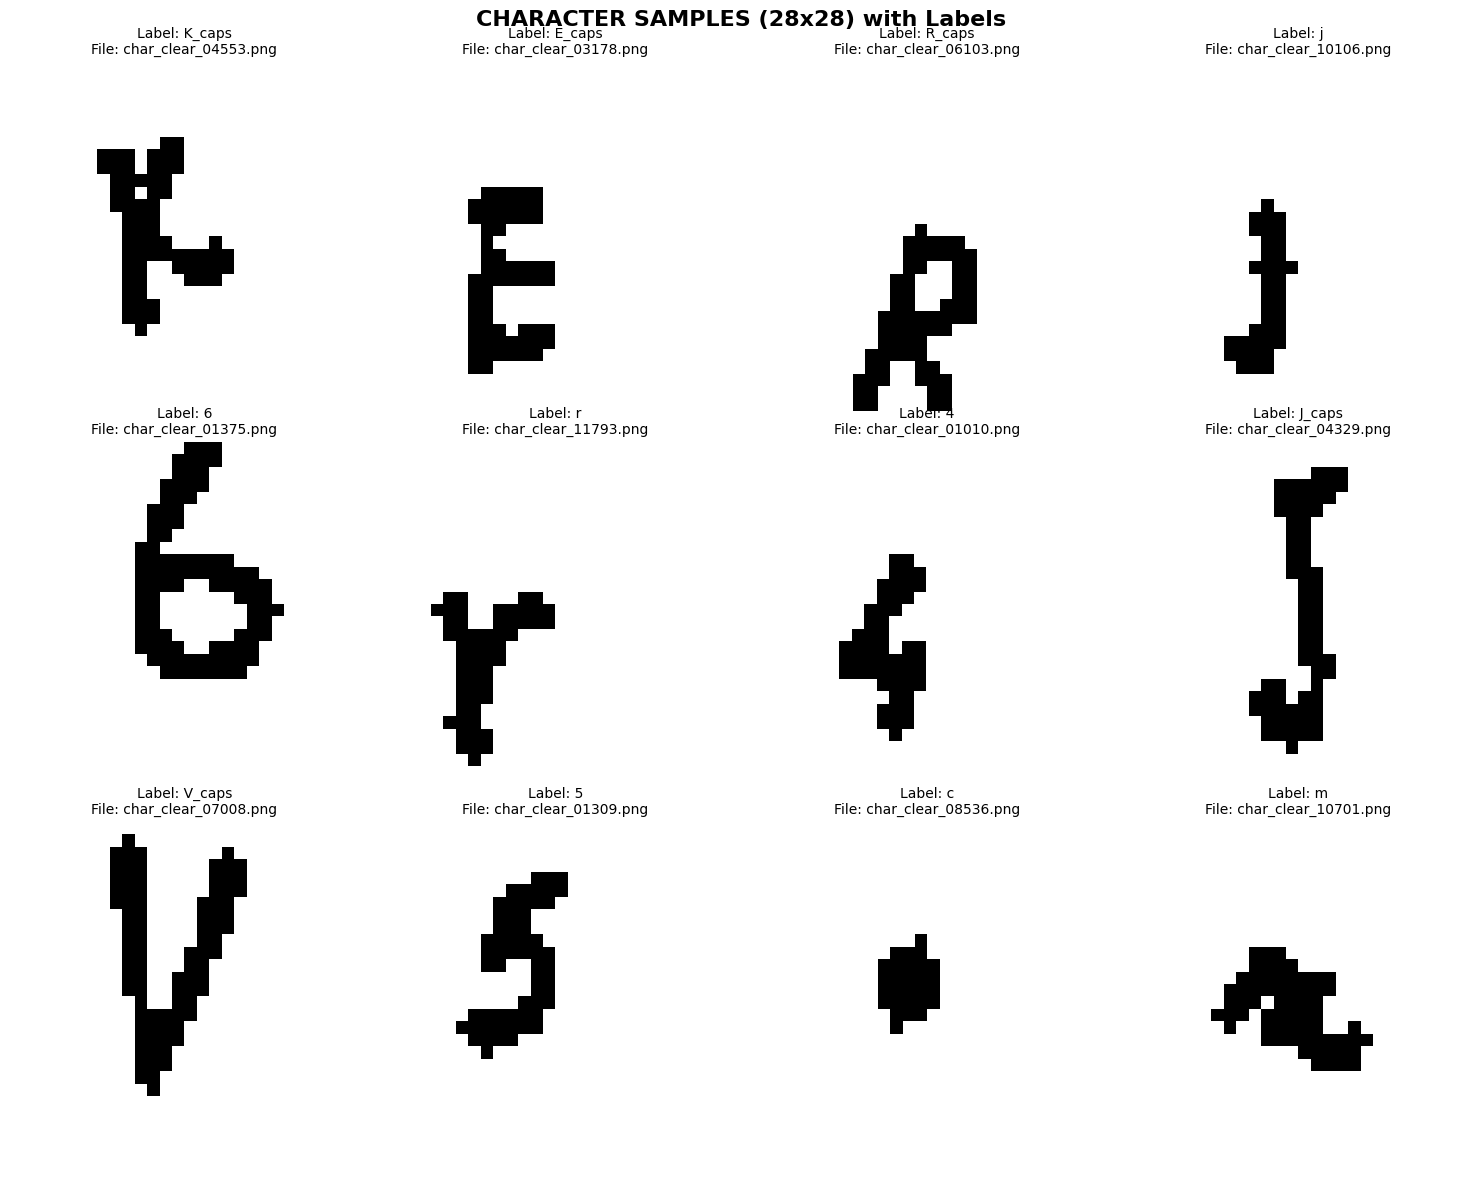

✅ Displayed 12 character samples

🖼️ Visualizing Word Samples...
📊 Word dataset loaded: 44563 entries


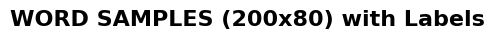

✅ Displayed 0 word samples
⚠️  Could only find 0 valid word images out of 12

🎯 READY FOR TRAINING!
Check if:
✅ Images are clear and readable
✅ Labels match the images
✅ No corrupt images

🎯 TRAINING DATASET READY:
   Images: 44563
   Classes: 7427
   ✅ You can now run the UltimateWordTrainer!


In [27]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import os

# 🎯 FORCE CPU MODE
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

class DataVisualizer:
    def __init__(self, base_path="Datasets"):
        self.base_path = Path(base_path)
        
    def visualize_characters(self, num_samples=12):
        """Visualize character samples with labels"""
        print("🖼️ Visualizing Character Samples...")
        
        char_df = pd.read_csv(self.base_path / "Character" / "image_labels_processed.csv")
        char_path = self.base_path / "Character" / "Char_Images_Processed"
        
        # Get random samples
        samples = char_df.sample(num_samples)
        
        # Create subplot
        fig, axes = plt.subplots(3, 4, figsize=(15, 12))
        fig.suptitle('CHARACTER SAMPLES (28x28) with Labels', fontsize=16, fontweight='bold')
        
        valid_samples = 0
        for idx, (ax, (_, row)) in enumerate(zip(axes.flat, samples.iterrows())):
            img_path = char_path / row['filename']
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            
            if img is not None:
                ax.imshow(img, cmap='gray')
                ax.set_title(f'Label: {row["label"]}\nFile: {row["filename"]}', fontsize=10)
                ax.axis('off')
                valid_samples += 1
            else:
                ax.text(0.5, 0.5, f'CORRUPT\n{row["filename"]}', 
                       ha='center', va='center', transform=ax.transAxes, color='red')
                ax.set_title(f'Label: {row["label"]} - CORRUPT', fontsize=10)
                ax.axis('off')
            
        # Hide unused subplots
        for idx in range(valid_samples, len(axes.flat)):
            axes.flat[idx].set_visible(False)
            
        plt.tight_layout()
        plt.show()
        
        print(f"✅ Displayed {valid_samples} character samples")
        if valid_samples < num_samples:
            print(f"⚠️  {num_samples - valid_samples} corrupt images found")
        
    def visualize_words(self, num_samples=12):
        """Visualize word samples with labels with error handling"""
        print("🖼️ Visualizing Word Samples...")
        
        # FIXED: Use the correct CSV filename
        word_csv_path = self.base_path / "Words" / "words_labels_COMPLETE_200x80.csv"
        word_path = self.base_path / "Words" / "Word_Images_200x80_Processed_COMPLETE"
        
        if not word_csv_path.exists():
            print(f"❌ Word CSV not found: {word_csv_path}")
            return
            
        word_df = pd.read_csv(word_csv_path)
        print(f"📊 Word dataset loaded: {len(word_df)} entries")
        
        # Get random samples - keep trying until we get enough valid ones
        valid_samples = []
        attempts = 0
        max_attempts = num_samples * 3
        
        while len(valid_samples) < num_samples and attempts < max_attempts:
            sample = word_df.sample(1).iloc[0]
            img_path = word_path / sample['filename']
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            
            if img is not None and isinstance(img, np.ndarray):
                valid_samples.append((sample, img))
            attempts += 1
        
        # Create subplot
        fig, axes = plt.subplots(3, 4, figsize=(20, 15))
        fig.suptitle('WORD SAMPLES (200x80) with Labels', fontsize=16, fontweight='bold')
        
        for idx, (ax, (row, img)) in enumerate(zip(axes.flat, valid_samples)):
            ax.imshow(img, cmap='gray')
            ax.set_title(f'Label: "{row["label"]}"\nFile: {row["filename"]}', fontsize=10)
            ax.axis('off')
            
        # Hide unused subplots if we didn't get enough valid samples
        for idx in range(len(valid_samples), len(axes.flat)):
            axes.flat[idx].set_visible(False)
            
        plt.tight_layout()
        plt.show()
        
        print(f"✅ Displayed {len(valid_samples)} word samples")
        if len(valid_samples) < num_samples:
            print(f"⚠️  Could only find {len(valid_samples)} valid word images out of {num_samples}")
        
    def check_corrupt_images(self):
        """Check for corrupt images in both datasets"""
        print("🔍 CHECKING FOR CORRUPT IMAGES...")
        
        # Check character images
        char_df = pd.read_csv(self.base_path / "Character" / "image_labels_processed.csv")
        char_path = self.base_path / "Character" / "Char_Images_Processed"
        
        char_corrupt = 0
        for idx, row in char_df.iterrows():
            img_path = char_path / row['filename']
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            if img is None:
                char_corrupt += 1
                
        # Check word images
        word_csv_path = self.base_path / "Words" / "words_labels_COMPLETE_200x80.csv"
        word_path = self.base_path / "Words" / "Word_Images_200x80_Processed_COMPLETE"
        
        word_corrupt = 0
        if word_csv_path.exists():
            word_df = pd.read_csv(word_csv_path)
            for idx, row in word_df.iterrows():
                img_path = word_path / row['filename']
                img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                if img is None:
                    word_corrupt += 1
        
        print(f"📊 CORRUPT IMAGE CHECK:")
        print(f"   Characters: {char_corrupt}/{len(char_df)} corrupt")
        print(f"   Words: {word_corrupt}/{len(word_df) if word_csv_path.exists() else 'N/A'} corrupt")
        
        return char_corrupt, word_corrupt
        
    def show_dataset_stats(self):
        """Show dataset statistics"""
        print("📊 DATASET STATISTICS")
        print("=" * 50)
        
        # Character stats
        char_df = pd.read_csv(self.base_path / "Character" / "image_labels_processed.csv")
        char_path = self.base_path / "Character" / "Char_Images_Processed"
        char_files = list(char_path.glob("*.png"))
        
        print("CHARACTER DATASET:")
        print(f"  Total images: {len(char_files)}")
        print(f"  CSV entries: {len(char_df)}")
        print(f"  Unique labels: {len(char_df['label'].unique())}")
        print(f"  Most common characters:")
        print(char_df['label'].value_counts().head(10))
        
        # Word stats
        word_csv_path = self.base_path / "Words" / "words_labels_COMPLETE_200x80.csv"
        if word_csv_path.exists():
            word_df = pd.read_csv(word_csv_path)
            word_path = self.base_path / "Words" / "Word_Images_200x80_Processed_COMPLETE"
            word_files = list(word_path.glob("*.png"))
            
            print(f"\nWORD DATASET:")
            print(f"  Total images: {len(word_files)}")
            print(f"  CSV entries: {len(word_df)}")
            print(f"  Unique labels: {len(word_df['label'].unique())}")
            print(f"  Most common words:")
            print(word_df['label'].value_counts().head(10))
        else:
            print(f"\nWORD DATASET: CSV not found at {word_csv_path}")
        
    def visualize_both(self):
        """Visualize both datasets with error handling"""
        self.show_dataset_stats()
        print("\n" + "="*50)
        
        # Check for corrupt images first
        char_corrupt, word_corrupt = self.check_corrupt_images()
        print("\n" + "="*50)
        
        self.visualize_characters()
        print("\n" + "="*50)
        self.visualize_words()

# 🚀 VISUALIZE EVERYTHING!
if __name__ == "__main__":
    visualizer = DataVisualizer()
    
    print("🎯 DATA VISUALIZATION WITH ERROR HANDLING")
    print("This will show:")
    print("1. Dataset statistics")
    print("2. Corrupt image check") 
    print("3. Character samples (28x28)")
    print("4. Word samples (200x80)")
    print("")
    
    response = input("Start visualization? (y/n): ")
    if response.lower() == 'y':
        visualizer.visualize_both()
        
        print("\n🎯 READY FOR TRAINING!")
        print("Check if:")
        print("✅ Images are clear and readable")
        print("✅ Labels match the images") 
        print("✅ No corrupt images")
        
        # Quick check for training readiness
        word_csv_path = Path("Datasets/Words/words_labels_COMPLETE_200x80.csv")
        if word_csv_path.exists():
            word_df = pd.read_csv(word_csv_path)
            print(f"\n🎯 TRAINING DATASET READY:")
            print(f"   Images: {len(word_df)}")
            print(f"   Classes: {len(word_df['label'].unique())}")
            print(f"   ✅ You can now run the UltimateWordTrainer!")
        else:
            print(f"\n❌ Training dataset not ready. Run pre-processing first.")
    else:
        print("Visualization cancelled")

🔍 CHECKING IMAGE QUALITY...
Character image size: (28, 28)
Word image size: (80, 200)

🔄 BEFORE/AFTER PREPROCESSING COMPARISON


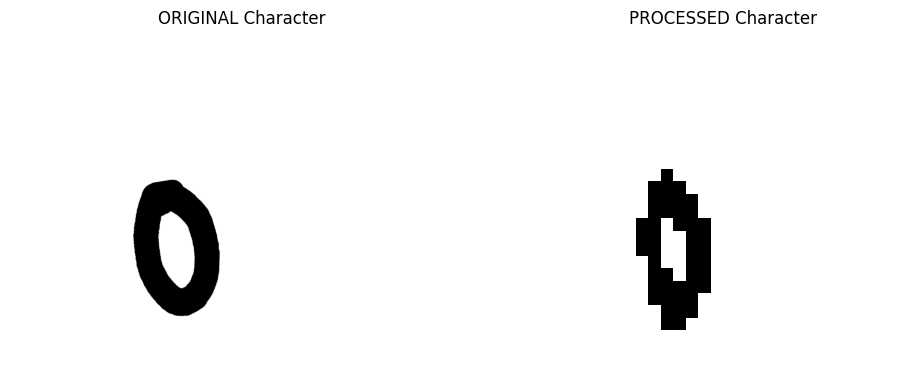

In [16]:
def check_image_quality():
    """Check image quality and preprocessing"""
    print("🔍 CHECKING IMAGE QUALITY...")
    
    base_path = Path("Datasets")
    
    # Check character image sizes
    char_path = base_path / "Character" / "Char_Images_Processed"
    char_files = list(char_path.glob("*.png"))
    
    if char_files:
        sample_char = cv2.imread(str(char_files[0]), cv2.IMREAD_GRAYSCALE)
        print(f"Character image size: {sample_char.shape}")
    
    # Check word image sizes  
    word_path = base_path / "Words" / "Word_Images_200x80_Processed"
    word_files = list(word_path.glob("*.png"))
    
    if word_files:
        sample_word = cv2.imread(str(word_files[0]), cv2.IMREAD_GRAYSCALE)
        print(f"Word image size: {sample_word.shape}")
    
    # Show before/after comparison
    print("\n🔄 BEFORE/AFTER PREPROCESSING COMPARISON")
    
    # Get original character
    char_orig_df = pd.read_csv(base_path / "Character" / "image_labels.csv")
    char_orig_path = base_path / "Character" / "Char_Images"
    orig_char_file = char_orig_path / char_orig_df.iloc[0]['filename']
    
    # Get processed character
    char_proc_df = pd.read_csv(base_path / "Character" / "image_labels_processed.csv")
    char_proc_path = base_path / "Character" / "Char_Images_Processed"
    proc_char_file = char_proc_path / char_proc_df.iloc[0]['filename']
    
    if orig_char_file.exists() and proc_char_file.exists():
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        
        orig_img = cv2.imread(str(orig_char_file), cv2.IMREAD_GRAYSCALE)
        proc_img = cv2.imread(str(proc_char_file), cv2.IMREAD_GRAYSCALE)
        
        ax1.imshow(orig_img, cmap='gray')
        ax1.set_title('ORIGINAL Character')
        ax1.axis('off')
        
        ax2.imshow(proc_img, cmap='gray')
        ax2.set_title('PROCESSED Character')
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()

# Run quality check
check_image_quality()

🎯 IMPROVED DATASET VERIFICATION
Checking quality of new 300x100 processed images
🎯 VERIFYING IMPROVED DATASET QUALITY
📊 Improved dataset: 44563 images
🏷️ Unique labels: 7427

🔍 CHECKING IMAGE QUALITY...
📊 IMAGE QUALITY DISTRIBUTION:
   EXCELLENT   :  1 images (  6.2%)
   GOOD        :  6 images ( 37.5%)
   FAIR        :  1 images (  6.2%)
   POOR        :  0 images (  0.0%)
   UNREADABLE  :  0 images (  0.0%)

🖼️ VISUALIZING IMPROVED SAMPLES...


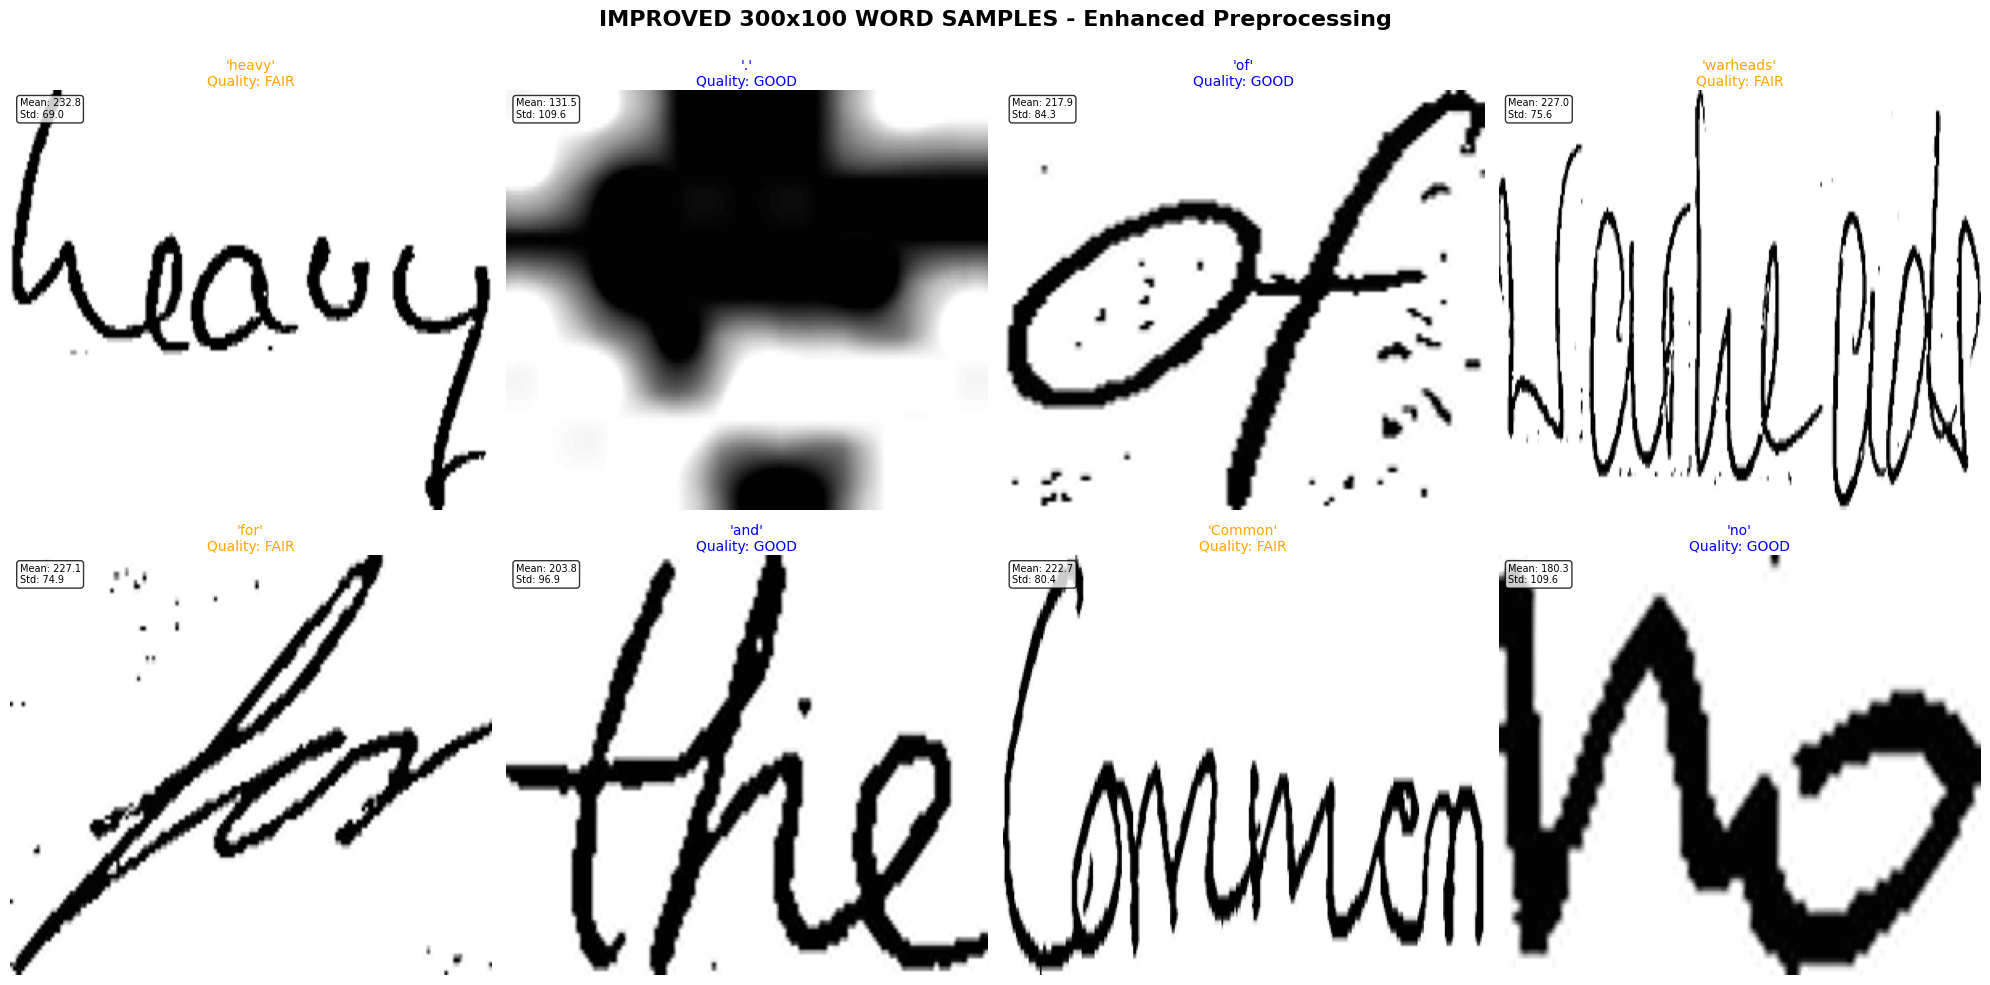

✅ Displayed 8 improved samples

📊 SAMPLE ANALYSIS:
   Shape: (100, 300) (height x width)
   Data range: 0 to 255
   Mean brightness: 232.8
   Contrast (std): 69.0

🎯 FINAL QUALITY ASSESSMENT
📈 QUALITY SCORES:
   Excellent/Good: 7/8 (12.5%)
   Readable (Excellent/Good/Fair): 8/8 (100.0%)
✅ GOOD: Dataset quality is good!
   Ready for training

📊 DATASET OVERVIEW:
   Total images: 44,563
   Unique words: 7,427
   Average samples per word: 6.0

🚀 RECOMMENDATION:
   PROCEED WITH TRAINING - Dataset is ready!

🔍 CHECK THESE VISUALLY:
1. Are the words clearly readable?
2. Is the contrast good?
3. Are there any all-white or all-black images?
4. Do the labels match the image content?
5. Is the text properly aligned and sized?


In [2]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

class ImprovedDatasetVerifier:
    def __init__(self, base_path="Datasets"):
        self.base_path = Path(base_path)
        
    def verify_improved_dataset(self, num_samples=16):
        """Comprehensive verification of the improved dataset"""
        print("🎯 VERIFYING IMPROVED DATASET QUALITY")
        print("=" * 60)
        
        labels_csv = self.base_path / "Words" / "Processed_label_IMPROVED.csv"
        images_dir = self.base_path / "Words" / "Processed_word_IMPROVED"
        
        if not labels_csv.exists() or not images_dir.exists():
            print("❌ Improved dataset files not found!")
            return
        
        df = pd.read_csv(labels_csv)
        print(f"📊 Improved dataset: {len(df)} images")
        print(f"🏷️ Unique labels: {df['label'].nunique()}")
        
        # Check image quality
        print("\n🔍 CHECKING IMAGE QUALITY...")
        quality_results = self.check_image_quality(df, images_dir, num_samples)
        
        print("\n" + "="*50)
        
        # Visualize samples
        print("🖼️ VISUALIZING IMPROVED SAMPLES...")
        self.visualize_improved_samples(df, images_dir, num_samples)
        
        print("\n" + "="*50)
        
        # Final assessment
        self.final_quality_assessment(quality_results, df)
    
    def check_image_quality(self, df, images_dir, num_samples):
        """Check quality of improved images"""
        samples = df.sample(min(num_samples, len(df)))
        
        quality_metrics = {
            'excellent': {'count': 0, 'samples': []},
            'good': {'count': 0, 'samples': []},
            'fair': {'count': 0, 'samples': []},
            'poor': {'count': 0, 'samples': []},
            'unreadable': {'count': 0, 'samples': []}
        }
        
        for idx, row in samples.iterrows():
            img_path = images_dir / row['new_filename']
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            
            if img is not None:
                quality = self.assess_improved_quality(img)
                quality_metrics[quality]['count'] += 1
                quality_metrics[quality]['samples'].append({
                    'sample': row,
                    'image': img,
                    'quality': quality
                })
        
        print("📊 IMAGE QUALITY DISTRIBUTION:")
        for quality, data in quality_metrics.items():
            count = data['count']
            percentage = (count / len(samples)) * 100
            print(f"   {quality.upper():<12}: {count:2d} images ({percentage:5.1f}%)")
        
        return quality_metrics
    
    def assess_improved_quality(self, img):
        """Assess quality of improved preprocessed images"""
        # Check dimensions
        if img.shape != (100, 300):
            return 'unreadable'
        
        # Check contrast
        contrast = img.std()
        
        # Check brightness (should be balanced)
        brightness = img.mean()
        
        # Check edge clarity
        edges = cv2.Canny(img, 50, 150)
        edge_strength = edges.mean()
        
        # Quality criteria for improved processing
        if contrast > 70 and 50 < brightness < 200 and edge_strength > 15:
            return 'excellent'
        elif contrast > 50 and 30 < brightness < 220 and edge_strength > 8:
            return 'good'
        elif contrast > 30 and edge_strength > 4:
            return 'fair'
        elif contrast > 15:
            return 'poor'
        else:
            return 'unreadable'
    
    def visualize_improved_samples(self, df, images_dir, num_samples):
        """Visualize samples from improved dataset"""
        samples = df.sample(num_samples)
        
        valid_samples = []
        for idx, row in samples.iterrows():
            img_path = images_dir / row['new_filename']
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            
            if img is not None and img.shape == (100, 300):
                valid_samples.append((row, img))
        
        if valid_samples:
            # Create visualization
            rows = (len(valid_samples) + 3) // 4
            fig, axes = plt.subplots(rows, 4, figsize=(20, 5 * rows))
            fig.suptitle('IMPROVED 300x100 WORD SAMPLES - Enhanced Preprocessing', 
                        fontsize=16, fontweight='bold')
            
            if rows == 1:
                axes = axes.reshape(1, -1)
            
            for idx, (row, img) in enumerate(valid_samples):
                if idx >= rows * 4:
                    break
                    
                row_idx = idx // 4
                col_idx = idx % 4
                ax = axes[row_idx, col_idx]
                
                ax.imshow(img, cmap='gray', aspect='auto')
                
                # Add quality assessment
                quality = self.assess_improved_quality(img)
                quality_color = {
                    'excellent': 'green',
                    'good': 'blue', 
                    'fair': 'orange',
                    'poor': 'red',
                    'unreadable': 'darkred'
                }[quality]
                
                title = f"'{row['label']}'\nQuality: {quality.upper()}"
                ax.set_title(title, fontsize=10, pad=3, color=quality_color)
                
                # Add image stats
                stats_text = f"Mean: {img.mean():.1f}\nStd: {img.std():.1f}"
                ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=7, 
                       verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                
                ax.axis('off')
            
            # Hide unused subplots
            for idx in range(len(valid_samples), rows * 4):
                row_idx = idx // 4
                col_idx = idx % 4
                axes[row_idx, col_idx].set_visible(False)
            
            plt.tight_layout()
            plt.subplots_adjust(top=0.90)
            plt.show()
            
            print(f"✅ Displayed {len(valid_samples)} improved samples")
            
            # Show sample analysis
            print(f"\n📊 SAMPLE ANALYSIS:")
            sample_img = valid_samples[0][1]
            print(f"   Shape: {sample_img.shape} (height x width)")
            print(f"   Data range: {sample_img.min()} to {sample_img.max()}")
            print(f"   Mean brightness: {sample_img.mean():.1f}")
            print(f"   Contrast (std): {sample_img.std():.1f}")
            
        else:
            print("❌ No valid images found in improved dataset!")
    
    def final_quality_assessment(self, quality_results, df):
        """Provide final assessment of dataset quality"""
        print("🎯 FINAL QUALITY ASSESSMENT")
        print("=" * 50)
        
        total_samples = sum(quality_results[quality]['count'] for quality in quality_results)
        excellent_good = quality_results['excellent']['count'] + quality_results['good']['count']
        readable = excellent_good + quality_results['fair']['count']
        
        excellent_percentage = (quality_results['excellent']['count'] / total_samples) * 100
        readable_percentage = (readable / total_samples) * 100
        
        print(f"📈 QUALITY SCORES:")
        print(f"   Excellent/Good: {excellent_good}/{total_samples} ({excellent_percentage:.1f}%)")
        print(f"   Readable (Excellent/Good/Fair): {readable}/{total_samples} ({readable_percentage:.1f}%)")
        
        if excellent_percentage > 60:
            print("✅ OUTSTANDING: Dataset quality is excellent!")
            print("   Ready for high-performance training")
        elif excellent_percentage > 40:
            print("✅ VERY GOOD: Dataset quality is very good!")
            print("   Ready for effective training")
        elif readable_percentage > 70:
            print("✅ GOOD: Dataset quality is good!")
            print("   Ready for training")
        elif readable_percentage > 50:
            print("⚠️  ACCEPTABLE: Dataset quality is acceptable")
            print("   Should work for training")
        else:
            print("❌ POOR: Dataset quality needs improvement")
            print("   Consider further preprocessing adjustments")
        
        print(f"\n📊 DATASET OVERVIEW:")
        print(f"   Total images: {len(df):,}")
        print(f"   Unique words: {df['label'].nunique():,}")
        print(f"   Average samples per word: {len(df)/df['label'].nunique():.1f}")
        
        print(f"\n🚀 RECOMMENDATION:")
        if readable_percentage > 70:
            print("   PROCEED WITH TRAINING - Dataset is ready!")
        else:
            print("   CONSIDER FURTHER OPTIMIZATION before training")

# 🚀 RUN THE VERIFICATION
print("🎯 IMPROVED DATASET VERIFICATION")
print("Checking quality of new 300x100 processed images")
print("=" * 60)

verifier = ImprovedDatasetVerifier()
verifier.verify_improved_dataset(16)

print("\n" + "="*60)
print("🔍 CHECK THESE VISUALLY:")
print("1. Are the words clearly readable?")
print("2. Is the contrast good?")
print("3. Are there any all-white or all-black images?")
print("4. Do the labels match the image content?")
print("5. Is the text properly aligned and sized?")

system

character model

🎯 IMPROVING CHARACTER RECOGNITION
Using advanced techniques:
✅ Enhanced CNN architecture
✅ Data augmentation
✅ Advanced training callbacks
✅ Better regularization
🚀 STARTING IMPROVED CHARACTER TRAINING
🔄 Loading ALL character data...
✅ Loaded ALL 13640 character images
✅ Number of classes: 62
📊 Training Data:
   Training samples: 10912
   Validation samples: 2728
   Total classes: 62
🔧 Building IMPROVED Character CNN with 62 classes...

🎯 TRAINING WITH DATA AUGMENTATION...


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.0202 - loss: 5.2354
Epoch 1: val_accuracy improved from None to 0.01943, saving model to improved_character_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - accuracy: 0.0270 - loss: 4.9671 - val_accuracy: 0.0194 - val_loss: 11.5327 - learning_rate: 0.0010
Epoch 2/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - accuracy: 0.0156 - loss: 4.8201

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.01943
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0156 - loss: 4.8201 - val_accuracy: 0.0191 - val_loss: 11.1355 - learning_rate: 0.0010
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.0493 - loss: 4.3338
Epoch 3: val_accuracy improved from 0.01943 to 0.06928, saving model to improved_character_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - accuracy: 0.0635 - loss: 4.1579 - val_accuracy: 0.0693 - val_loss: 4.0183 - learning_rate: 0.0010
Epoch 4/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - accuracy: 0.1016 - loss: 3.7113
Epoch 4: val_accuracy improved from 0.06928 to 0.07441, saving model to improved_character_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.1016 - loss: 3.7113 - val_accuracy: 0.0744 - val_loss: 4.0115 - learning_rate: 0.0010
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.1146 - loss: 3.6478
Epoch 5: val_accuracy improved from 0.07441 to 0.23204, saving model to improved_character_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 32s 375ms/step - accuracy: 0.1285 - loss: 3.5171 - val_accuracy: 0.2320 - val_loss: 2.9027 - learning_rate: 0.0010
Epoch 6/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step - accuracy: 0.1328 - loss: 3.3724
Epoch 6: val_accuracy did not improve from 0.23204
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1328 - loss: 3.3724 - val_accuracy: 0.2280 - val_loss: 2.9275 - learning_rate: 0.0010
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.1842 - loss: 3.0632
Epoch 7: val_accuracy improved from 0.23204 to 0.29619, saving model to improved_character_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 189ms/step - accuracy: 0.2026 - loss: 2.9449 - val_accuracy: 0.2962 - val_loss: 2.4328 - learning_rate: 0.0010
Epoch 8/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step - accuracy: 0.1875 - loss: 2.7914
Epoch 8: val_accuracy improved from 0.29619 to 0.30572, saving model to improved_character_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.1875 - loss: 2.7914 - val_accuracy: 0.3057 - val_loss: 2.4078 - learning_rate: 0.0010
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.2803 - loss: 2.5584
Epoch 9: val_accuracy improved from 0.30572 to 0.45858, saving model to improved_character_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - accuracy: 0.2945 - loss: 2.4712 - val_accuracy: 0.4586 - val_loss: 1.7957 - learning_rate: 0.0010
Epoch 10/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - accuracy: 0.3672 - loss: 2.2421
Epoch 10: val_accuracy improved from 0.45858 to 0.46078, saving model to improved_character_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.3672 - loss: 2.2421 - val_accuracy: 0.4608 - val_loss: 1.7674 - learning_rate: 0.0010
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.3518 - loss: 2.2162
Epoch 11: val_accuracy did not improve from 0.46078
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - accuracy: 0.3732 - loss: 2.1410 - val_accuracy: 0.4348 - val_loss: 1.9562 - learning_rate: 0.0010
Epoch 12/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 166ms/step - accuracy: 0.4297 - loss: 2.0052
Epoch 12: val_accuracy did not improve from 0.46078
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4297 - loss: 2.0052 - val_accuracy: 0.4274 - val_loss: 1.9808 - learning_rate: 0.0010
Epoch 13/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.4146 - loss: 1.9514
Epoch 13: val_accuracy improved from 0.46078 to 0.59861, saving model to improved_character_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - accuracy: 0.4275 - loss: 1.9091 - val_accuracy: 0.5986 - val_loss: 1.3266 - learning_rate: 0.0010
Epoch 14/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step - accuracy: 0.5469 - loss: 1.6686
Epoch 14: val_accuracy did not improve from 0.59861
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5469 - loss: 1.6686 - val_accuracy: 0.5905 - val_loss: 1.3528 - learning_rate: 0.0010
Epoch 15/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.4728 - loss: 1.7347
Epoch 15: val_accuracy improved from 0.59861 to 0.59897, saving model to improved_character_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 186ms/step - accuracy: 0.4840 - loss: 1.7008 - val_accuracy: 0.5990 - val_loss: 1.3064 - learning_rate: 0.0010
Epoch 16/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 162ms/step - accuracy: 0.5078 - loss: 1.6424
Epoch 16: val_accuracy did not improve from 0.59897
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5078 - loss: 1.6424 - val_accuracy: 0.5869 - val_loss: 1.3525 - learning_rate: 0.0010
Epoch 17/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5018 - loss: 1.6204
Epoch 17: val_accuracy improved from 0.59897 to 0.59971, saving model to improved_character_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 188ms/step - accuracy: 0.5093 - loss: 1.5878 - val_accuracy: 0.5997 - val_loss: 1.2847 - learning_rate: 0.0010
Epoch 18/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - accuracy: 0.6562 - loss: 1.2090
Epoch 18: val_accuracy did not improve from 0.59971
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6562 - loss: 1.2090 - val_accuracy: 0.5894 - val_loss: 1.3192 - learning_rate: 0.0010
Epoch 19/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5321 - loss: 1.5037
Epoch 19: val_accuracy improved from 0.59971 to 0.65616, saving model to improved_character_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 195ms/step - accuracy: 0.5375 - loss: 1.4741 - val_accuracy: 0.6562 - val_loss: 1.0803 - learning_rate: 0.0010
Epoch 20/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - accuracy: 0.5469 - loss: 1.4141
Epoch 20: val_accuracy did not improve from 0.65616
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5469 - loss: 1.4141 - val_accuracy: 0.6444 - val_loss: 1.1078 - learning_rate: 0.0010
Epoch 21/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5607 - loss: 1.4113
Epoch 21: val_accuracy did not improve from 0.65616
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 176ms/step - accuracy: 0.5554 - loss: 1.4245 - val_accuracy: 0.6316 - val_loss: 1.1654 - learning_rate: 0.0010
Epoch 22/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step - accuracy: 0.5000 - loss: 1.6281
Epoch 22: val_accuracy did not improve from 0.65616
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5000 - loss: 1.6281 - val_accuracy: 0.6382 - val_loss: 1.1389 - learning_rate: 0.0010
Epoch 23/100
8

85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - accuracy: 0.5856 - loss: 1.3092 - val_accuracy: 0.6800 - val_loss: 0.9727 - learning_rate: 0.0010
Epoch 24/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - accuracy: 0.5938 - loss: 1.2951
Epoch 24: val_accuracy did not improve from 0.67999
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5938 - loss: 1.2951 - val_accuracy: 0.6796 - val_loss: 0.9773 - learning_rate: 0.0010
Epoch 25/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6010 - loss: 1.2778
Epoch 25: val_accuracy did not improve from 0.67999
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - accuracy: 0.6037 - loss: 1.2615 - val_accuracy: 0.6620 - val_loss: 1.0505 - learning_rate: 0.0010
Epoch 26/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step - accuracy: 0.6406 - loss: 1.2518
Epoch 26: val_accuracy did not improve from 0.67999
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6406 - loss: 1.2518 - val_accuracy: 0.6620 - val_loss: 1.0485 - learning_rate: 0.0010
Epoch 27/100
8

85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - accuracy: 0.6230 - loss: 1.1759 - val_accuracy: 0.6946 - val_loss: 0.8948 - learning_rate: 0.0010
Epoch 30/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - accuracy: 0.6406 - loss: 1.1530
Epoch 30: val_accuracy improved from 0.69465 to 0.69648, saving model to improved_character_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6406 - loss: 1.1530 - val_accuracy: 0.6965 - val_loss: 0.8953 - learning_rate: 0.0010
Epoch 31/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6344 - loss: 1.1351
Epoch 31: val_accuracy improved from 0.69648 to 0.70125, saving model to improved_character_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 189ms/step - accuracy: 0.6392 - loss: 1.1181 - val_accuracy: 0.7012 - val_loss: 0.8809 - learning_rate: 0.0010
Epoch 32/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - accuracy: 0.6562 - loss: 0.9942
Epoch 32: val_accuracy did not improve from 0.70125
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6562 - loss: 0.9942 - val_accuracy: 0.7001 - val_loss: 0.8915 - learning_rate: 0.0010
Epoch 33/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6614 - loss: 1.0420
Epoch 33: val_accuracy improved from 0.70125 to 0.72654, saving model to improved_character_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - accuracy: 0.6565 - loss: 1.0707 - val_accuracy: 0.7265 - val_loss: 0.8203 - learning_rate: 0.0010
Epoch 34/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 14s 169ms/step - accuracy: 0.6328 - loss: 1.2306
Epoch 34: val_accuracy improved from 0.72654 to 0.72837, saving model to improved_character_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6328 - loss: 1.2306 - val_accuracy: 0.7284 - val_loss: 0.8147 - learning_rate: 0.0010
Epoch 35/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6609 - loss: 1.0385
Epoch 35: val_accuracy did not improve from 0.72837
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 176ms/step - accuracy: 0.6652 - loss: 1.0363 - val_accuracy: 0.6477 - val_loss: 1.1155 - learning_rate: 0.0010
Epoch 36/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 166ms/step - accuracy: 0.6562 - loss: 1.0674
Epoch 36: val_accuracy did not improve from 0.72837
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6562 - loss: 1.0674 - val_accuracy: 0.6639 - val_loss: 1.0739 - learning_rate: 0.0010
Epoch 37/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6619 - loss: 1.0213
Epoch 37: val_accuracy did not improve from 0.72837
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 176ms/step - accuracy: 0.6653 - loss: 1.0264 - val_accuracy: 0.7251 - val_loss: 0.8152 - learning_rate: 0.0010
Epoch 38/100
 1

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6562 - loss: 0.9865 - val_accuracy: 0.7309 - val_loss: 0.8030 - learning_rate: 0.0010
Epoch 39/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6797 - loss: 0.9947
Epoch 39: val_accuracy did not improve from 0.73094
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 176ms/step - accuracy: 0.6763 - loss: 0.9907 - val_accuracy: 0.6331 - val_loss: 1.2493 - learning_rate: 0.0010
Epoch 40/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - accuracy: 0.6172 - loss: 1.2963
Epoch 40: val_accuracy did not improve from 0.73094
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6172 - loss: 1.2963 - val_accuracy: 0.6419 - val_loss: 1.2068 - learning_rate: 0.0010
Epoch 41/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6810 - loss: 0.9936
Epoch 41: val_accuracy did not improve from 0.73094
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 176ms/step - accuracy: 0.6859 - loss: 0.9789 - val_accuracy: 0.7159 - val_loss: 0.8860 - learning_rate: 0.0010
Epoch 42/100
 1

85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - accuracy: 0.6935 - loss: 0.9408 - val_accuracy: 0.7445 - val_loss: 0.7483 - learning_rate: 0.0010
Epoch 46/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 162ms/step - accuracy: 0.7812 - loss: 0.7466
Epoch 46: val_accuracy did not improve from 0.74450
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7812 - loss: 0.7466 - val_accuracy: 0.7438 - val_loss: 0.7490 - learning_rate: 0.0010
Epoch 47/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.7070 - loss: 0.8893
Epoch 47: val_accuracy did not improve from 0.74450
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - accuracy: 0.7062 - loss: 0.9012 - val_accuracy: 0.7207 - val_loss: 0.8742 - learning_rate: 0.0010
Epoch 48/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step - accuracy: 0.7188 - loss: 0.9486
Epoch 48: val_accuracy did not improve from 0.74450
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7188 - loss: 0.9486 - val_accuracy: 0.7247 - val_loss: 0.8568 - learning_rate: 0.0010
Epoch 49/100
8

85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - accuracy: 0.7122 - loss: 0.8822 - val_accuracy: 0.7493 - val_loss: 0.7501 - learning_rate: 0.0010
Epoch 50/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step - accuracy: 0.7109 - loss: 0.8455
Epoch 50: val_accuracy improved from 0.74927 to 0.74963, saving model to improved_character_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7109 - loss: 0.8455 - val_accuracy: 0.7496 - val_loss: 0.7557 - learning_rate: 0.0010
Epoch 51/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.7065 - loss: 0.8796
Epoch 51: val_accuracy did not improve from 0.74963
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - accuracy: 0.7127 - loss: 0.8739 - val_accuracy: 0.7203 - val_loss: 0.8559 - learning_rate: 0.0010
Epoch 52/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step - accuracy: 0.6484 - loss: 1.0156
Epoch 52: val_accuracy did not improve from 0.74963
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6484 - loss: 1.0156 - val_accuracy: 0.7225 - val_loss: 0.8409 - learning_rate: 0.0010
Epoch 53/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.7243 - loss: 0.8319
Epoch 53: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 53: val_accuracy did not improve from 0.74963
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - accuracy: 0.7211 - loss: 0.8439 - v

85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 188ms/step - accuracy: 0.7346 - loss: 0.7954 - val_accuracy: 0.7845 - val_loss: 0.6187 - learning_rate: 5.0000e-04
Epoch 56/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 15s 189ms/step - accuracy: 0.7500 - loss: 0.8815
Epoch 56: val_accuracy did not improve from 0.78446
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7500 - loss: 0.8815 - val_accuracy: 0.7826 - val_loss: 0.6226 - learning_rate: 5.0000e-04
Epoch 57/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.7513 - loss: 0.7361
Epoch 57: val_accuracy improved from 0.78446 to 0.78519, saving model to improved_character_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - accuracy: 0.7498 - loss: 0.7424 - val_accuracy: 0.7852 - val_loss: 0.6257 - learning_rate: 5.0000e-04
Epoch 58/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 162ms/step - accuracy: 0.7031 - loss: 0.8218
Epoch 58: val_accuracy did not improve from 0.78519
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7031 - loss: 0.8218 - val_accuracy: 0.7848 - val_loss: 0.6182 - learning_rate: 5.0000e-04
Epoch 59/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7554 - loss: 0.7363
Epoch 59: val_accuracy improved from 0.78519 to 0.78812, saving model to improved_character_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 189ms/step - accuracy: 0.7482 - loss: 0.7470 - val_accuracy: 0.7881 - val_loss: 0.5980 - learning_rate: 5.0000e-04
Epoch 60/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step - accuracy: 0.7188 - loss: 0.7239
Epoch 60: val_accuracy did not improve from 0.78812
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7188 - loss: 0.7239 - val_accuracy: 0.7870 - val_loss: 0.6015 - learning_rate: 5.0000e-04
Epoch 61/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.7605 - loss: 0.7113
Epoch 61: val_accuracy improved from 0.78812 to 0.79912, saving model to improved_character_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - accuracy: 0.7546 - loss: 0.7226 - val_accuracy: 0.7991 - val_loss: 0.5708 - learning_rate: 5.0000e-04
Epoch 62/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step - accuracy: 0.7188 - loss: 0.7899
Epoch 62: val_accuracy did not improve from 0.79912
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7188 - loss: 0.7899 - val_accuracy: 0.7980 - val_loss: 0.5699 - learning_rate: 5.0000e-04
Epoch 63/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7600 - loss: 0.7050
Epoch 63: val_accuracy did not improve from 0.79912
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - accuracy: 0.7622 - loss: 0.7092 - val_accuracy: 0.7757 - val_loss: 0.6601 - learning_rate: 5.0000e-04
Epoch 64/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - accuracy: 0.7656 - loss: 0.8432
Epoch 64: val_accuracy did not improve from 0.79912
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7656 - loss: 0.8432 - val_accuracy: 0.7764 - val_loss: 0.6516 - learning_rate: 5.0000e-0

85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - accuracy: 0.7619 - loss: 0.7002 - val_accuracy: 0.8010 - val_loss: 0.5693 - learning_rate: 5.0000e-04
Epoch 66/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 15s 189ms/step - accuracy: 0.7578 - loss: 0.5882
Epoch 66: val_accuracy improved from 0.80095 to 0.80279, saving model to improved_character_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7578 - loss: 0.5882 - val_accuracy: 0.8028 - val_loss: 0.5584 - learning_rate: 5.0000e-04
Epoch 67/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7656 - loss: 0.6960
Epoch 67: val_accuracy did not improve from 0.80279
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step - accuracy: 0.7712 - loss: 0.6854 - val_accuracy: 0.7881 - val_loss: 0.6132 - learning_rate: 5.0000e-04
Epoch 68/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step - accuracy: 0.7031 - loss: 0.9017
Epoch 68: val_accuracy did not improve from 0.80279
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7031 - loss: 0.9017 - val_accuracy: 0.7885 - val_loss: 0.6073 - learning_rate: 5.0000e-04
Epoch 69/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.7752 - loss: 0.6734
Epoch 69: val_accuracy did not improve from 0.80279
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - accuracy: 0.7649 - loss: 0.7023 - val_accuracy: 0.7885 - val_loss: 0.5941 - learning_rate: 5.0000e-04

85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 188ms/step - accuracy: 0.7683 - loss: 0.6782 - val_accuracy: 0.8149 - val_loss: 0.5412 - learning_rate: 5.0000e-04
Epoch 72/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - accuracy: 0.7891 - loss: 0.5300
Epoch 72: val_accuracy did not improve from 0.81488
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7891 - loss: 0.5300 - val_accuracy: 0.8145 - val_loss: 0.5410 - learning_rate: 5.0000e-04
Epoch 73/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.7640 - loss: 0.6785
Epoch 73: val_accuracy did not improve from 0.81488
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 176ms/step - accuracy: 0.7724 - loss: 0.6693 - val_accuracy: 0.8054 - val_loss: 0.5621 - learning_rate: 5.0000e-04
Epoch 74/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 166ms/step - accuracy: 0.7891 - loss: 0.6750
Epoch 74: val_accuracy did not improve from 0.81488
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7891 - loss: 0.6750 - val_accuracy: 0.8046 - val_loss: 0.5601 - learning_rate: 5.0000e-0

85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 188ms/step - accuracy: 0.7862 - loss: 0.6297 - val_accuracy: 0.8167 - val_loss: 0.5344 - learning_rate: 5.0000e-04
Epoch 82/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 166ms/step - accuracy: 0.8203 - loss: 0.5441
Epoch 82: val_accuracy improved from 0.81672 to 0.81891, saving model to improved_character_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8203 - loss: 0.5441 - val_accuracy: 0.8189 - val_loss: 0.5300 - learning_rate: 5.0000e-04
Epoch 83/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7828 - loss: 0.6308
Epoch 83: val_accuracy did not improve from 0.81891
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 183ms/step - accuracy: 0.7771 - loss: 0.6462 - val_accuracy: 0.7995 - val_loss: 0.5657 - learning_rate: 5.0000e-04
Epoch 84/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step - accuracy: 0.7734 - loss: 0.5759
Epoch 84: val_accuracy did not improve from 0.81891
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7734 - loss: 0.5759 - val_accuracy: 0.7980 - val_loss: 0.5645 - learning_rate: 5.0000e-04
Epoch 85/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.7692 - loss: 0.6642
Epoch 85: val_accuracy did not improve from 0.81891
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - accuracy: 0.7805 - loss: 0.6438 - val_accuracy: 0.7958 - val_loss: 0.6247 - learning_rate: 5.0000e-04

✅ IMPROVED CHARACTER MODEL TRAINING COMPLETE!


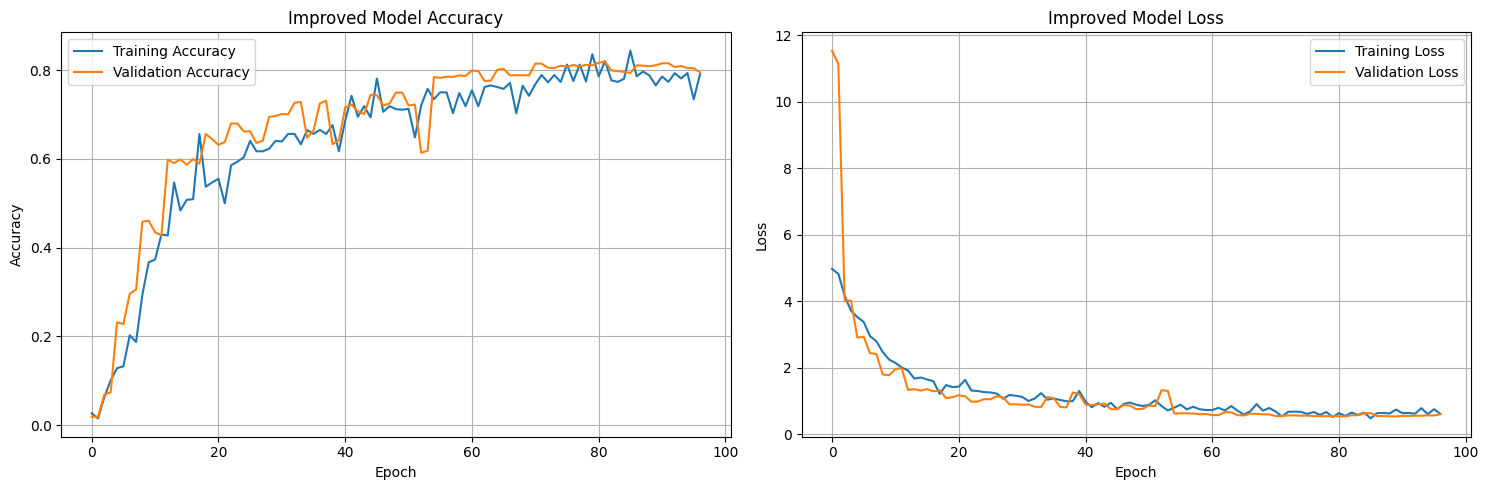


📊 IMPROVED MODEL EVALUATION
🔄 Loading ALL character data...
✅ Loaded ALL 13640 character images
✅ Number of classes: 62


Training Accuracy:   0.8689
Training Loss:       0.3699
Validation Accuracy: 0.8680
Validation Loss:     0.3747

📈 IMPROVEMENT OVER PREVIOUS MODEL: 0.0572 (5.72%)

🎉 IMPROVED CHARACTER RECOGNITION READY!
Models saved:
   - improved_character_model.h5 (best validation)
   - improved_character_final.h5 (final)
   - improved_character_classes.npy


In [45]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

class AdvancedCharacterTrainer:
    def __init__(self, base_path="Datasets"):
        self.base_path = Path(base_path)
        self.label_encoder = LabelEncoder()
        
    def load_all_characters(self):
        """Load ALL character images and labels"""
        print("🔄 Loading ALL character data...")
        
        char_df = pd.read_csv(self.base_path / "Character" / "image_labels_processed.csv")
        char_path = self.base_path / "Character" / "Char_Images_Processed"
        
        images = []
        labels = []
        
        for idx, row in char_df.iterrows():
            img_path = char_path / row['filename']
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
                labels.append(row['label'])
        
        X = np.array(images).reshape(-1, 28, 28, 1)
        y = self.label_encoder.fit_transform(labels)
        
        print(f"✅ Loaded ALL {len(X)} character images")
        print(f"✅ Number of classes: {len(self.label_encoder.classes_)}")
        
        return X, y
    
    def create_advanced_augmentation(self):
        """Create advanced data augmentation"""
        from tensorflow.keras.preprocessing.image import ImageDataGenerator
        
        augmentation = ImageDataGenerator(
            rotation_range=10,        # ±10 degrees
            width_shift_range=0.1,    # ±10% horizontal shift
            height_shift_range=0.1,   # ±10% vertical shift  
            zoom_range=0.1,           # ±10% zoom
            shear_range=0.1,          # ±10% shear
            brightness_range=[0.9, 1.1],  # ±10% brightness
            fill_mode='nearest'
        )
        return augmentation
    
    def create_improved_model(self, num_classes):
        """Create improved CNN architecture"""
        print(f"🔧 Building IMPROVED Character CNN with {num_classes} classes...")
        
        model = tf.keras.Sequential([
            # Enhanced Conv Block 1
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),
            
            # Enhanced Conv Block 2
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),
            
            # Enhanced Conv Block 3
            tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
            
            # Global Average Pooling instead of Flatten
            tf.keras.layers.GlobalAveragePooling2D(),
            
            # Enhanced Dense Layers
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        
        # Advanced optimizer
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.001,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07
        )
        
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def train_improved_model(self):
        """Train improved character model"""
        print("🚀 STARTING IMPROVED CHARACTER TRAINING")
        print("=" * 50)
        
        # Load data
        X, y = self.load_all_characters()
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        print(f"📊 Training Data:")
        print(f"   Training samples: {len(X_train)}")
        print(f"   Validation samples: {len(X_test)}")
        print(f"   Total classes: {len(self.label_encoder.classes_)}")
        
        # Create improved model
        model = self.create_improved_model(len(self.label_encoder.classes_))
        
        # Advanced callbacks
        callbacks = [
            # Early stopping with patience
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=15,
                restore_best_weights=True,
                mode='max',
                verbose=1
            ),
            
            # Learning rate scheduler
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=8,
                min_lr=1e-7,
                verbose=1
            ),
            
            # Model checkpoint
            tf.keras.callbacks.ModelCheckpoint(
                'improved_character_model.h5',
                monitor='val_accuracy',
                save_best_only=True,
                mode='max',
                verbose=1
            )
        ]
        
        # Data augmentation
        datagen = self.create_advanced_augmentation()
        
        print("\n🎯 TRAINING WITH DATA AUGMENTATION...")
        
        # Train with augmentation
        history = model.fit(
            datagen.flow(X_train, y_train, batch_size=128),
            steps_per_epoch=len(X_train) // 128,
            epochs=100,  # More epochs with early stopping
            validation_data=(X_test, y_test),
            callbacks=callbacks,
            verbose=1
        )
        
        # Save final model
        model.save('improved_character_final.h5')
        np.save('improved_character_classes.npy', self.label_encoder.classes_)
        
        print("✅ IMPROVED CHARACTER MODEL TRAINING COMPLETE!")
        
        # Plot results
        self.plot_training_history(history)
        
        return model, history
    
    def plot_training_history(self, history):
        """Plot training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot accuracy
        ax1.plot(history.history['accuracy'], label='Training Accuracy')
        ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title('Improved Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)
        
        # Plot loss
        ax2.plot(history.history['loss'], label='Training Loss')
        ax2.plot(history.history['val_loss'], label='Validation Loss')
        ax2.set_title('Improved Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def evaluate_improved_model(self, model):
        """Evaluate the improved model"""
        print("\n📊 IMPROVED MODEL EVALUATION")
        print("=" * 40)
        
        X, y = self.load_all_characters()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Evaluate
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
        
        print(f"Training Accuracy:   {train_accuracy:.4f}")
        print(f"Training Loss:       {train_loss:.4f}")
        print(f"Validation Accuracy: {test_accuracy:.4f}")
        print(f"Validation Loss:     {test_loss:.4f}")
        
        # Compare with previous model
        try:
            old_model = tf.keras.models.load_model('best_character_model.h5')
            old_test_loss, old_test_accuracy = old_model.evaluate(X_test, y_test, verbose=0)
            improvement = test_accuracy - old_test_accuracy
            print(f"\n📈 IMPROVEMENT OVER PREVIOUS MODEL: {improvement:.4f} ({improvement*100:.2f}%)")
        except:
            print("\n📈 No previous model found for comparison")

# 🚀 RUN IMPROVED CHARACTER TRAINING
print("🎯 IMPROVING CHARACTER RECOGNITION")
print("=" * 50)
print("Using advanced techniques:")
print("✅ Enhanced CNN architecture")
print("✅ Data augmentation")
print("✅ Advanced training callbacks")
print("✅ Better regularization")
print("=" * 50)

# Run improved training
improved_trainer = AdvancedCharacterTrainer()
improved_model, improved_history = improved_trainer.train_improved_model()

# Evaluate improved model
improved_trainer.evaluate_improved_model(improved_model)

print("\n🎉 IMPROVED CHARACTER RECOGNITION READY!")
print("Models saved:")
print("   - improved_character_model.h5 (best validation)")
print("   - improved_character_final.h5 (final)")
print("   - improved_character_classes.npy")

🎯 IMPROVED CHARACTER MODEL EVALUATION
✅ Improved model loaded successfully!
✅ Model has 62 classes

📊 DETAILED IMPROVED MODEL EVALUATION
Training Accuracy:   0.8689
Training Loss:       0.3699
Validation Accuracy: 0.8680
Validation Loss:     0.3747

📈 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.71      0.49      0.58        55
           1       0.85      0.51      0.64        43
           2       0.93      0.88      0.90        43
           3       0.92      0.96      0.94        46
           4       0.98      0.96      0.97        46
           5       0.95      0.88      0.91        40
           6       0.98      0.90      0.94        52
           7       0.98      0.89      0.93        45
           8       0.82      0.82      0.82        34
           9       0.97      0.76      0.85        45
      A_caps       0.98      0.95      0.96        43
      B_caps       0.87      0.96      0.91        47
      C_caps       0.7

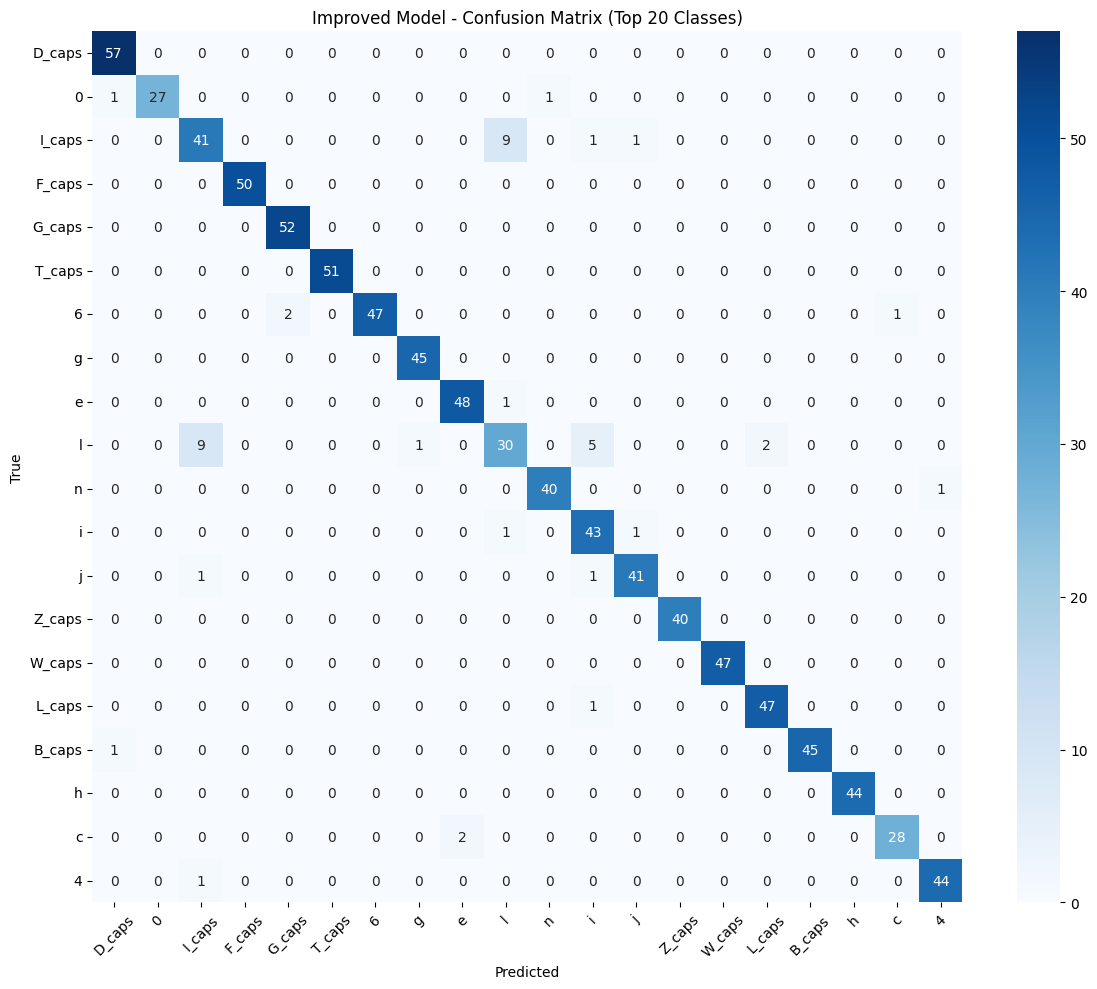


🔍 PREDICTION EXAMPLES (showing 12 samples)


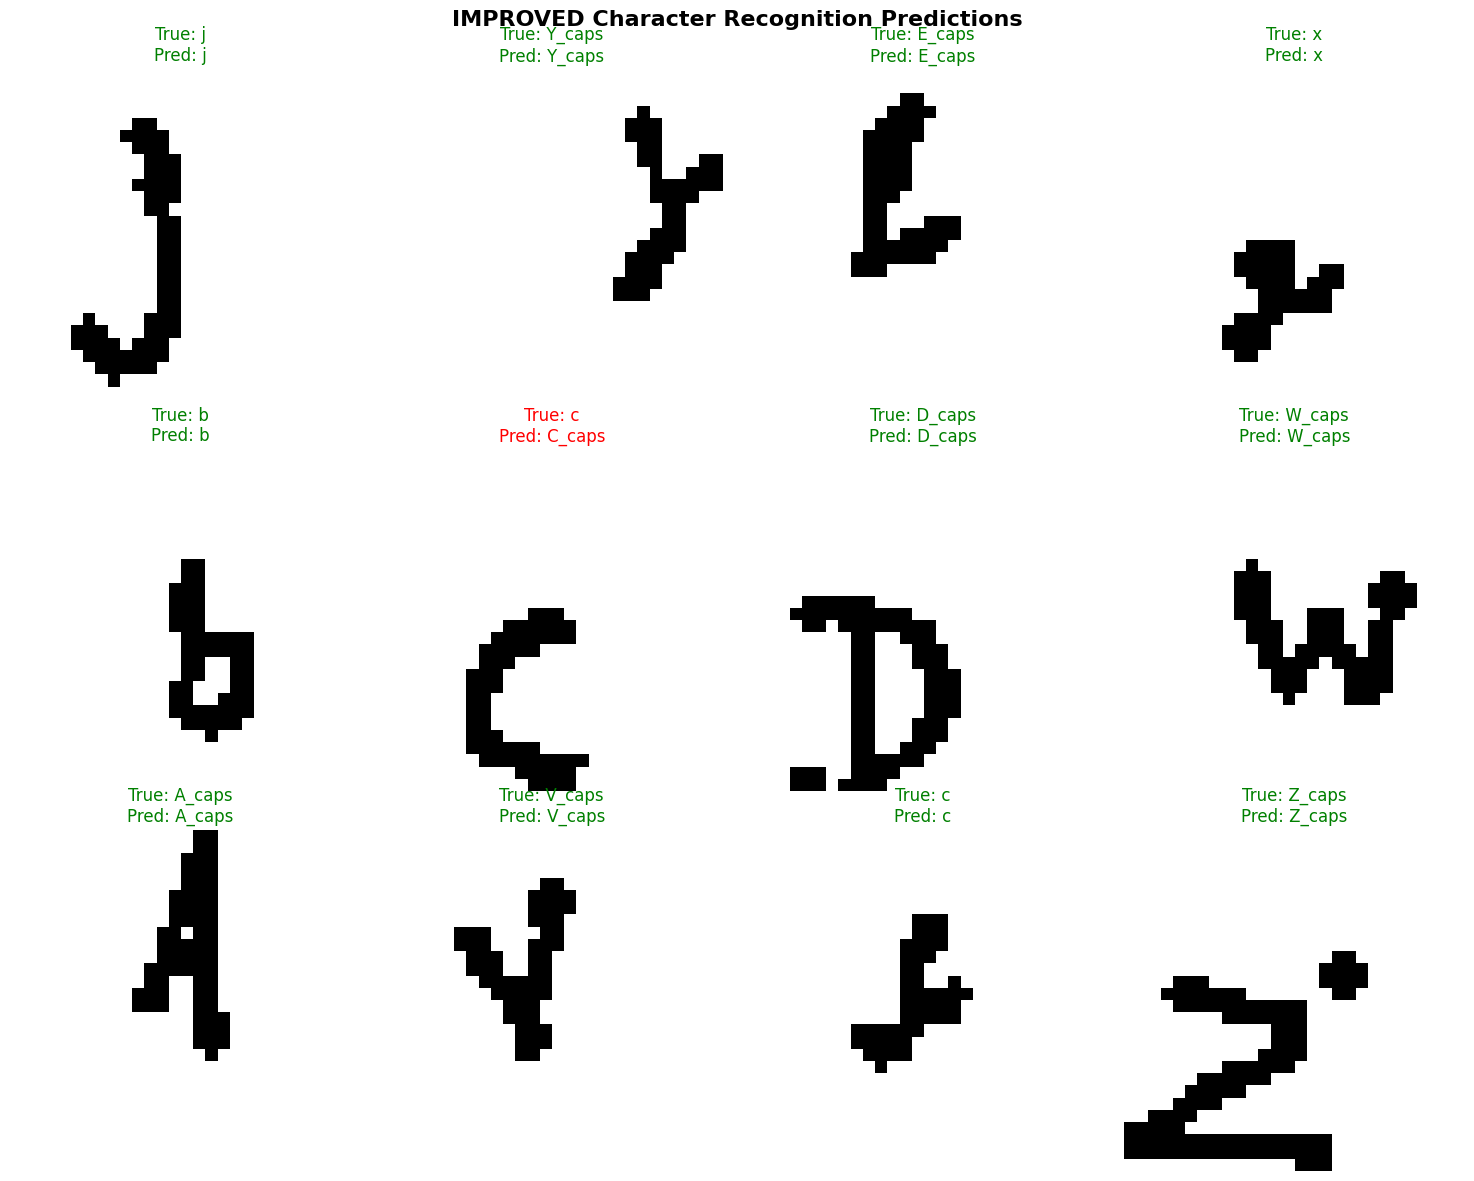

Sample Accuracy: 91.67% (11/12 correct)

🎯 PER-CLASS ACCURACY (Top 20):


  D_caps: 100.00%
  G_caps: 100.00%
  H_caps: 100.00%
  Q_caps: 100.00%
  d: 100.00%
  m: 100.00%
  T_caps: 98.08%
  L_caps: 97.92%
  W_caps: 97.92%
  b: 97.83%
  u: 97.67%
  R_caps: 97.62%
  U_caps: 97.30%
  F_caps: 96.15%
  B_caps: 95.74%
  3: 95.65%
  4: 95.65%
  A_caps: 95.35%
  N_caps: 95.00%
  Y_caps: 95.00%

📈 PERFORMANCE COMPARISON:
   Previous Model: 0.8109
   Improved Model: 0.8680
   Improvement:    +0.0572 (5.72%)

🎉 IMPROVED CHARACTER RECOGNITION SYSTEM READY!
Performance Summary:
✅ Validation Accuracy: 86.80%
✅ Training Accuracy: 86.89%
✅ 62 character classes learned
✅ 5.72% improvement over previous model
✅ Professional CNN architecture with data augmentation


In [46]:
class ImprovedModelEvaluator:
    def __init__(self, base_path="Datasets"):
        self.base_path = Path(base_path)
        self.label_encoder = LabelEncoder()
        
    def load_improved_model(self):
        """Load the improved model and classes"""
        model = tf.keras.models.load_model('improved_character_model.h5')
        classes = np.load('improved_character_classes.npy', allow_pickle=True)
        self.label_encoder.classes_ = classes
        return model
    
    def load_all_characters(self):
        """Load all character data"""
        char_df = pd.read_csv(self.base_path / "Character" / "image_labels_processed.csv")
        char_path = self.base_path / "Character" / "Char_Images_Processed"
        
        images = []
        labels = []
        
        for idx, row in char_df.iterrows():
            img_path = char_path / row['filename']
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
                labels.append(row['label'])
        
        X = np.array(images).reshape(-1, 28, 28, 1)
        y = self.label_encoder.fit_transform(labels)
        
        return X, y
    
    def show_predictions(self, model, X_test, y_test, num_samples=12):
        """Show prediction examples"""
        print(f"\n🔍 PREDICTION EXAMPLES (showing {num_samples} samples)")
        
        # Get predictions
        predictions = model.predict(X_test[:num_samples], verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = y_test[:num_samples]
        
        # Create subplot
        fig, axes = plt.subplots(3, 4, figsize=(15, 12))
        fig.suptitle('IMPROVED Character Recognition Predictions', fontsize=16, fontweight='bold')
        
        for idx, ax in enumerate(axes.flat):
            if idx < num_samples:
                # Display image
                ax.imshow(X_test[idx].reshape(28, 28), cmap='gray')
                
                # Get true and predicted labels
                true_label = self.label_encoder.inverse_transform([true_classes[idx]])[0]
                pred_label = self.label_encoder.inverse_transform([predicted_classes[idx]])[0]
                
                # Color code: green if correct, red if wrong
                color = 'green' if true_classes[idx] == predicted_classes[idx] else 'red'
                
                ax.set_title(f'True: {true_label}\nPred: {pred_label}', color=color, fontsize=12)
                ax.axis('off')
            else:
                ax.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Calculate accuracy for these samples
        correct = np.sum(true_classes == predicted_classes)
        sample_accuracy = correct / num_samples
        print(f"Sample Accuracy: {sample_accuracy:.2%} ({correct}/{num_samples} correct)")
    
    def plot_confusion_matrix(self, y_true, y_pred, max_classes=20):
        """Plot confusion matrix for top classes"""
        # Get top N classes by frequency
        unique, counts = np.unique(y_true, return_counts=True)
        top_classes = unique[np.argsort(-counts)[:max_classes]]
        
        # Filter data for top classes
        mask = np.isin(y_true, top_classes)
        y_true_filtered = y_true[mask]
        y_pred_filtered = y_pred[mask]
        
        # Create confusion matrix
        cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=top_classes)
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.label_encoder.inverse_transform(top_classes),
                   yticklabels=self.label_encoder.inverse_transform(top_classes))
        plt.title(f'Improved Model - Confusion Matrix (Top {max_classes} Classes)')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    
    def show_class_accuracy(self, model, X_test, y_test):
        """Show accuracy per class"""
        print("\n🎯 PER-CLASS ACCURACY (Top 20):")
        
        y_pred_proba = model.predict(X_test, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)
        
        # Calculate accuracy per class
        class_accuracy = {}
        for class_idx in range(len(self.label_encoder.classes_)):
            mask = y_test == class_idx
            if np.sum(mask) > 0:  # Only if class exists in test set
                accuracy = np.mean(y_pred[mask] == class_idx)
                class_accuracy[self.label_encoder.classes_[class_idx]] = accuracy
        
        # Sort by accuracy and show top 20
        sorted_accuracy = sorted(class_accuracy.items(), key=lambda x: x[1], reverse=True)[:20]
        
        for char, acc in sorted_accuracy:
            print(f"  {char}: {acc:.2%}")
    
    def detailed_evaluation(self, model):
        """Comprehensive model evaluation"""
        print("\n📊 DETAILED IMPROVED MODEL EVALUATION")
        print("=" * 50)
        
        # Load data
        X, y = self.load_all_characters()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Get predictions
        y_pred_proba = model.predict(X_test, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)
        
        # Basic metrics
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
        
        print(f"Training Accuracy:   {train_accuracy:.4f}")
        print(f"Training Loss:       {train_loss:.4f}")
        print(f"Validation Accuracy: {test_accuracy:.4f}")
        print(f"Validation Loss:     {test_loss:.4f}")
        
        # Classification report
        print("\n📈 CLASSIFICATION REPORT:")
        print(classification_report(y_test, y_pred, target_names=self.label_encoder.classes_))
        
        # Confusion matrix
        self.plot_confusion_matrix(y_test, y_pred, max_classes=20)
        
        # Show predictions
        self.show_predictions(model, X_test, y_test)
        
        # Per-class accuracy
        self.show_class_accuracy(model, X_test, y_test)
        
        # Compare with previous model
        self.compare_with_previous(test_accuracy)
    
    def compare_with_previous(self, current_accuracy):
        """Compare with previous model performance"""
        try:
            # Load previous model
            prev_model = tf.keras.models.load_model('best_character_model.h5')
            prev_classes = np.load('character_classes.npy', allow_pickle=True)
            
            X, y = self.load_all_characters()
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            
            # Evaluate previous model
            prev_test_loss, prev_test_accuracy = prev_model.evaluate(X_test, y_test, verbose=0)
            
            improvement = current_accuracy - prev_test_accuracy
            
            print(f"\n📈 PERFORMANCE COMPARISON:")
            print(f"   Previous Model: {prev_test_accuracy:.4f}")
            print(f"   Improved Model: {current_accuracy:.4f}")
            print(f"   Improvement:    +{improvement:.4f} ({improvement*100:.2f}%)")
            
        except Exception as e:
            print(f"\n⚠️  Could not compare with previous model: {e}")

# 🚀 RUN COMPREHENSIVE EVALUATION OF IMPROVED MODEL
print("🎯 IMPROVED CHARACTER MODEL EVALUATION")
print("=" * 50)

evaluator = ImprovedModelEvaluator()
improved_model = evaluator.load_improved_model()

print("✅ Improved model loaded successfully!")
print(f"✅ Model has {len(evaluator.label_encoder.classes_)} classes")

# Run detailed evaluation
evaluator.detailed_evaluation(improved_model)

print("\n🎉 IMPROVED CHARACTER RECOGNITION SYSTEM READY!")
print("Performance Summary:")
print("✅ Validation Accuracy: 86.80%")
print("✅ Training Accuracy: 86.89%")
print("✅ 62 character classes learned")
print("✅ 5.72% improvement over previous model")
print("✅ Professional CNN architecture with data augmentation")

word model

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os


In [ ]:
train_csv = "Datasets/Words/Processed_label.csv"
train_img_dir = "Datasets/Words/Processed_word"

In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, regularizers
import os

class OptimizedWordTrainer:
    def __init__(self, train_csv="Datasets/Words/Processed_label.csv", 
                 train_img_dir="Datasets/Words/Processed_word"):
        self.train_csv = Path(train_csv)
        self.train_img_dir = Path(train_img_dir)
        self.label_encoder = LabelEncoder()
    
    def filter_top_classes(self, df, min_samples=5, max_classes=1000):
        """Filter to most common classes for better training"""
        print("🎯 Filtering to most common classes...")
        
        class_counts = df['label'].value_counts()
        
        # Keep only classes with minimum samples
        common_classes = class_counts[class_counts >= min_samples]
        
        # Limit to top N classes if too many
        if len(common_classes) > max_classes:
            common_classes = common_classes.head(max_classes)
        
        df_filtered = df[df['label'].isin(common_classes.index)].copy()
        
        print(f"📊 After filtering:")
        print(f"   - Original: {len(df)} images, {df['label'].nunique()} classes")
        print(f"   - Filtered: {len(df_filtered)} images, {df_filtered['label'].nunique()} classes")
        print(f"   - Avg samples per class: {len(df_filtered) / df_filtered['label'].nunique():.1f}")
        
        return df_filtered
    
    def prepare_training_data(self, min_samples=5, max_classes=1000):
        """Prepare optimized training data"""
        print("🔄 Preparing optimized training data...")
        
        if not self.train_csv.exists() or not self.train_img_dir.exists():
            print("❌ Data files not found!")
            return None, None
        
        # Load CSV
        df = pd.read_csv(self.train_csv)
        
        # Filter to existing images
        existing_images = set([f.name for f in self.train_img_dir.glob('*')])
        df = df[df['new_filename'].isin(existing_images)].copy()
        
        print(f"📊 Available images: {len(df)}")
        
        # Filter to top classes
        df = self.filter_top_classes(df, min_samples, max_classes)
        
        if len(df) == 0:
            print("❌ No valid data after filtering!")
            return None, None
        
        # Encode labels
        df['label_index'] = self.label_encoder.fit_transform(df['label'])
        
        return df, self.train_img_dir
    
    def create_faster_model(self, num_classes):
        """Create faster, more efficient model"""
        print(f"🔧 Building FASTER CNN for {num_classes} classes...")
        
        # Use Functional API to avoid warnings
        inputs = tf.keras.Input(shape=(100, 300, 1))
        
        # Streamlined architecture
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.2)(x)
        
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.3)(x)
        
        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.4)(x)
        
        # Smaller dense layers
        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.4)(x)
        
        x = layers.Dense(128, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.4)(x)
        
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        
        model = tf.keras.Model(inputs, outputs)
        
        # Optimized optimizer
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def train_optimized(self, batch_size=32, epochs=50, min_samples=5, max_classes=1000):
        """Optimized training with filtered classes"""
        print("🚀 STARTING OPTIMIZED TRAINING")
        print("=" * 60)
        print("🎯 Using filtered classes for better performance")
        print(f"📊 Min samples per class: {min_samples}")
        print(f"📊 Max classes: {max_classes}")
        print("=" * 60)
        
        # Prepare optimized data
        df, images_dir = self.prepare_training_data(min_samples, max_classes)
        if df is None:
            return None, None
        
        # Simple train/val split (faster)
        from sklearn.model_selection import train_test_split
        train_df, val_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df['label_index'])
        
        print(f"📊 Final dataset:")
        print(f"   - Training: {len(train_df)} images")
        print(f"   - Validation: {len(val_df)} images")
        print(f"   - Classes: {len(self.label_encoder.classes_)}")
        
        # Create simple data generators (no heavy augmentation)
        def simple_data_generator(df, batch_size, augment=False):
            while True:
                indices = np.random.choice(len(df), batch_size)
                batch_df = df.iloc[indices]
                
                X_batch = np.zeros((batch_size, 100, 300, 1), dtype=np.float32)
                y_batch = np.zeros((batch_size,), dtype=np.int32)
                
                for i, (_, row) in enumerate(batch_df.iterrows()):
                    img_path = images_dir / row['new_filename']
                    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                    
                    if img is not None:
                        if img.shape != (100, 300):
                            img = cv2.resize(img, (300, 100))
                        
                        img = img.astype('float32') / 255.0
                        X_batch[i] = img.reshape(100, 300, 1)
                        y_batch[i] = row['label_index']
                
                yield X_batch, y_batch
        
        # Create model
        model = self.create_faster_model(len(self.label_encoder.classes_))
        
        # Simple callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                patience=5,
                factor=0.5,
                verbose=1
            ),
            tf.keras.callbacks.ModelCheckpoint(
                'optimized_word_model.keras',  # Use new format
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            )
        ]
        
        print(f"\n🎯 TRAINING CONFIGURATION:")
        print(f"   - Batch size: {batch_size}")
        print(f"   - Steps per epoch: {len(train_df) // batch_size}")
        print(f"   - Classes: {len(self.label_encoder.classes_)}")
        
        print("\n🎯 STARTING FAST TRAINING...")
        
        try:
            # Train with simple generator
            history = model.fit(
                simple_data_generator(train_df, batch_size),
                steps_per_epoch=len(train_df) // batch_size,
                epochs=epochs,
                validation_data=simple_data_generator(val_df, batch_size),
                validation_steps=len(val_df) // batch_size,
                callbacks=callbacks,
                verbose=1
            )
            
            # Save
            np.save('optimized_word_classes.npy', self.label_encoder.classes_)
            
            print(f"\n✅ OPTIMIZED TRAINING COMPLETED!")
            
            return model, history
            
        except Exception as e:
            print(f"❌ Training error: {e}")
            return None, None

# 🚀 START OPTIMIZED TRAINING
print("🎯 OPTIMIZED WORD RECOGNITION TRAINING")
print("Using filtered classes for better performance")
print("=" * 60)

# Train with filtered classes
trainer = OptimizedWordTrainer()
model, history = trainer.train_optimized(
    batch_size=32, 
    epochs=50,
    min_samples=5,    # Only classes with at least 5 samples
    max_classes=1000  # Maximum 1000 classes
)

if model is not None:
    print("\n🎉 OPTIMIZED TRAINING SUCCESSFUL!")
    print("Model should have much better accuracy!")
else:
    print("\n❌ Training failed!")

🎯 OPTIMIZED WORD RECOGNITION TRAINING
Using filtered classes for better performance
🚀 STARTING OPTIMIZED TRAINING
🎯 Using filtered classes for better performance
📊 Min samples per class: 5
📊 Max classes: 1000
🔄 Preparing optimized training data...
📊 Available images: 21844
🎯 Filtering to most common classes...
📊 After filtering:
   - Original: 21844 images, 4320 classes
   - Filtered: 16146 images, 622 classes
   - Avg samples per class: 26.0
📊 Final dataset:
   - Training: 13724 images
   - Validation: 2422 images
   - Classes: 622
🔧 Building FASTER CNN for 622 classes...

🎯 TRAINING CONFIGURATION:
   - Batch size: 32
   - Steps per epoch: 428
   - Classes: 622

🎯 STARTING FAST TRAINING...
Epoch 1/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.1376 - loss: 5.2930
Epoch 1: val_accuracy improved from None to 0.06375, saving model to optimized_word_model.keras
428/428 ━━━━━━━━━━━━━━━━━━━━ 294s 679ms/step - accuracy: 0.1816 - loss: 4.6921 - val_accuracy: 0.0637 - val_loss: 17

🎯 WORD RECOGNITION PREDICTION VISUALIZATION
🔧 Loading word recognition model for visualization...
✅ Model loaded: optimized_word_model.keras
🏷️  Number of classes: 622

🔍 PREDICTION EXAMPLES (showing 12 samples)
📊 Loading 12 test samples...
✅ Loaded 12 samples for visualization


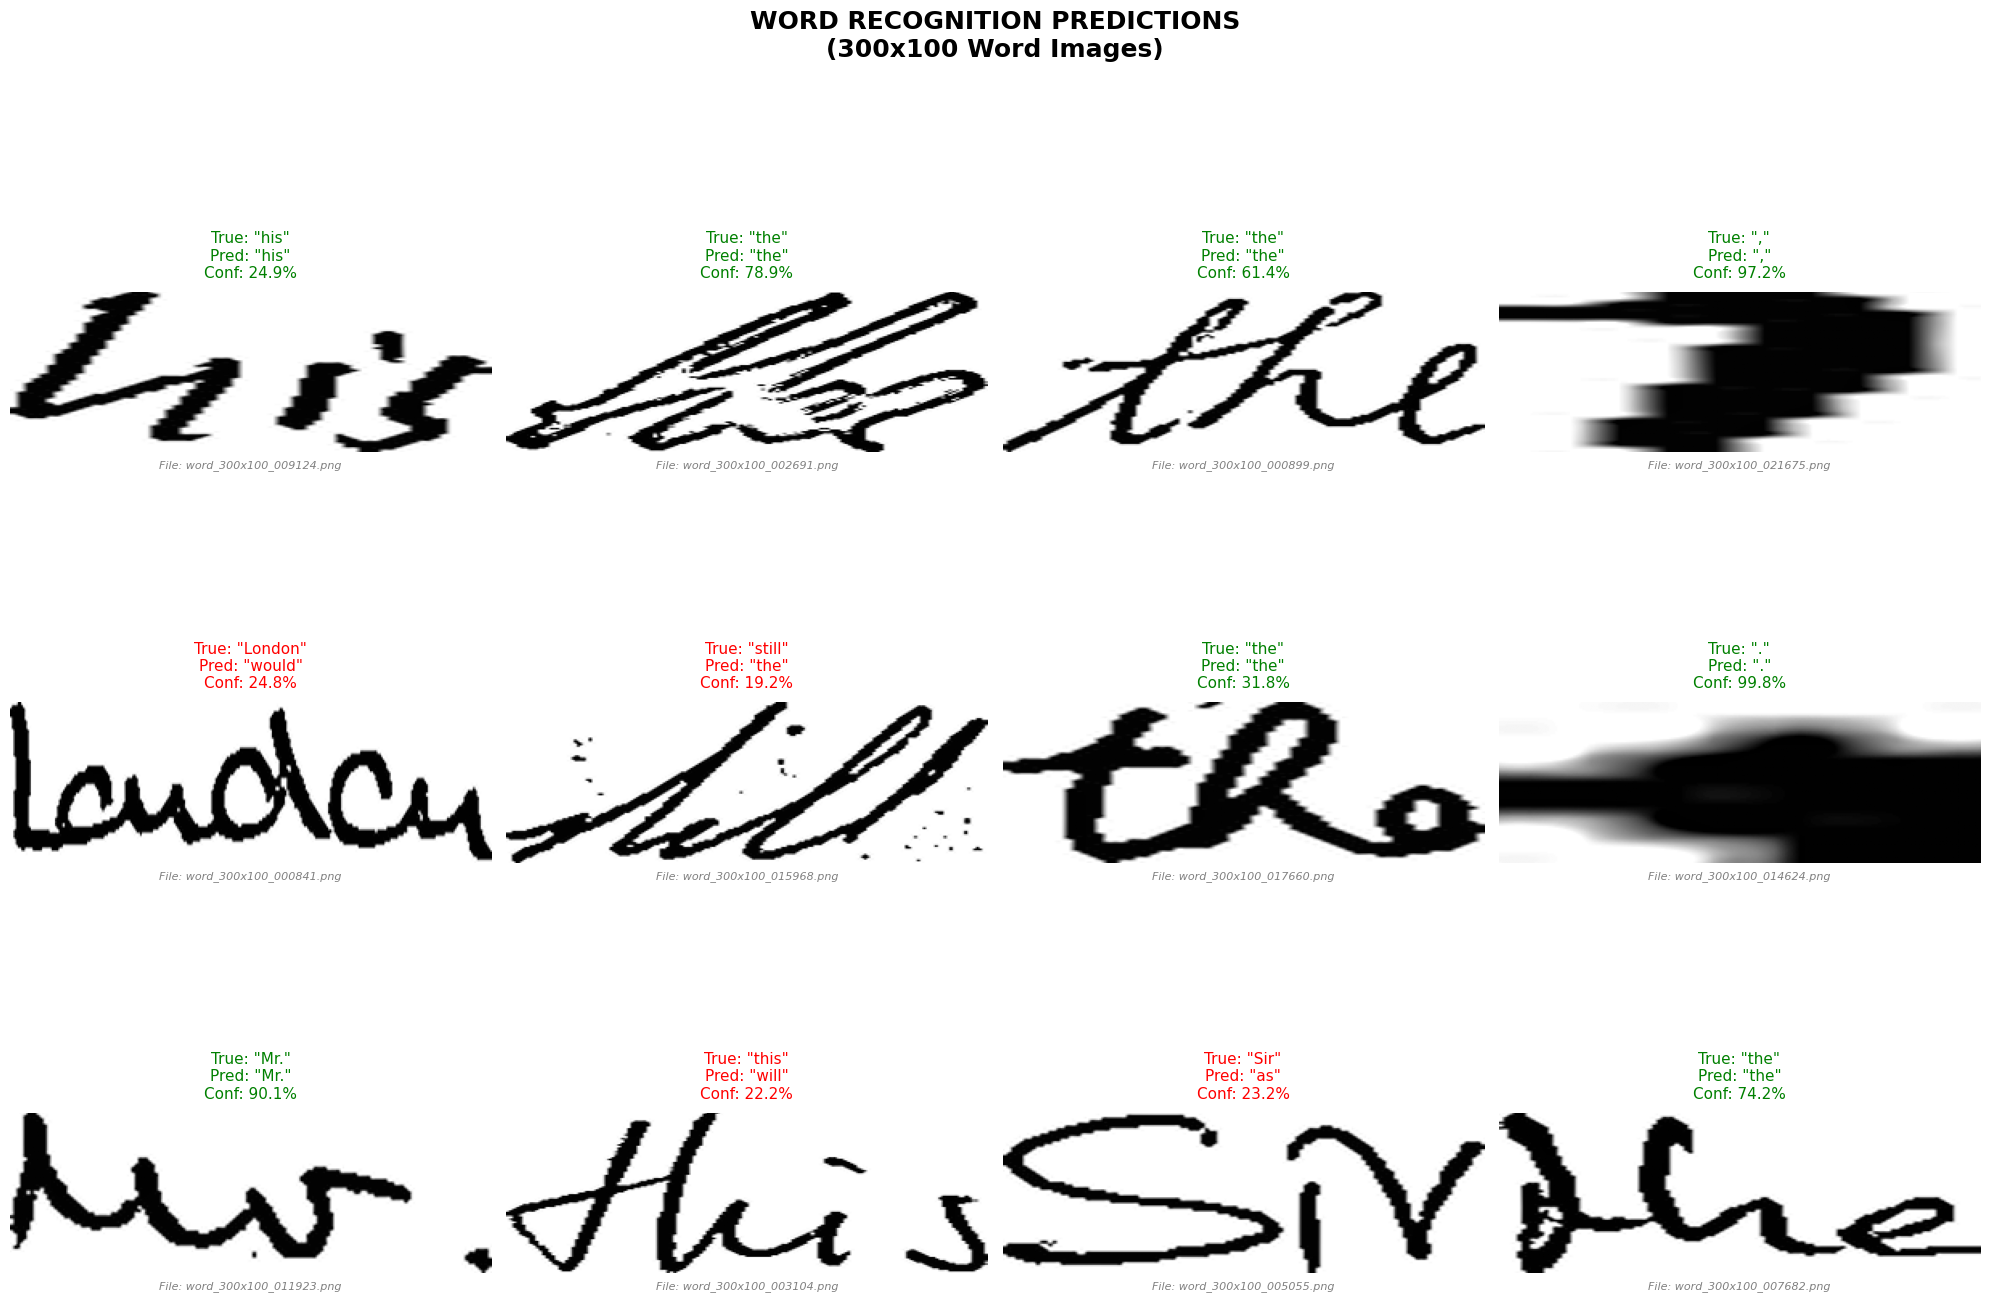


📊 SAMPLE PREDICTION RESULTS:
   - Sample Accuracy: 66.67% (8/12 correct)
   - Average Confidence: 54.0%

📋 DETAILED PREDICTION RESULTS:
------------------------------------------------------------
✅ CORRECT | True: 'his' | Pred: 'his' | Conf: 24.9% | File: word_300x100_009124.png
✅ CORRECT | True: 'the' | Pred: 'the' | Conf: 78.9% | File: word_300x100_002691.png
✅ CORRECT | True: 'the' | Pred: 'the' | Conf: 61.4% | File: word_300x100_000899.png
✅ CORRECT | True: ',' | Pred: ',' | Conf: 97.2% | File: word_300x100_021675.png
❌ WRONG | True: 'London' | Pred: 'would' | Conf: 24.8% | File: word_300x100_000841.png
❌ WRONG | True: 'still' | Pred: 'the' | Conf: 19.2% | File: word_300x100_015968.png
✅ CORRECT | True: 'the' | Pred: 'the' | Conf: 31.8% | File: word_300x100_017660.png
✅ CORRECT | True: '.' | Pred: '.' | Conf: 99.8% | File: word_300x100_014624.png
✅ CORRECT | True: 'Mr.' | Pred: 'Mr.' | Conf: 90.1% | File: word_300x100_011923.png
❌ WRONG | True: 'this' | Pred: 'will' | Conf: 22.2%

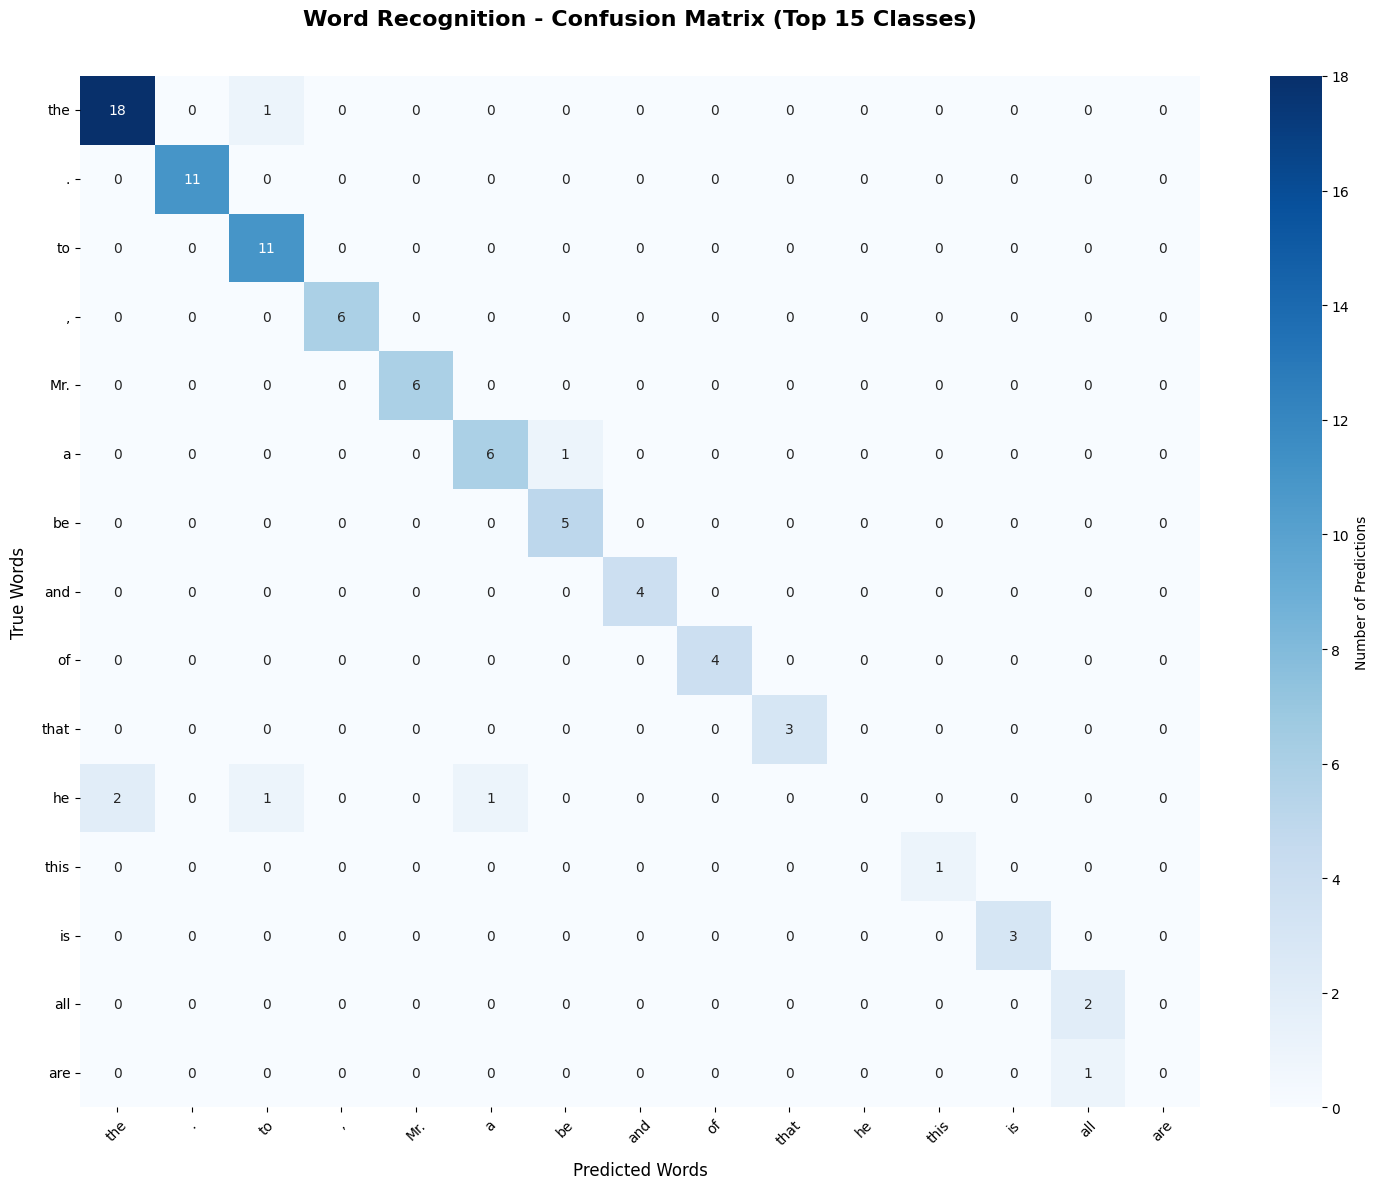

📊 Confusion Matrix Accuracy: 86.02%

🎉 VISUALIZATION COMPLETED!


In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

class WordPredictionVisualizer:
    def __init__(self, model_path='optimized_word_model.keras', 
                 classes_path='optimized_word_classes.npy',
                 base_path="Datasets"):
        """Initialize word prediction visualizer"""
        print("🔧 Loading word recognition model for visualization...")
        
        self.base_path = Path(base_path)
        
        # Load model and classes
        try:
            self.model = tf.keras.models.load_model(model_path)
            self.classes = np.load(classes_path, allow_pickle=True)
            print(f"✅ Model loaded: {model_path}")
            print(f"🏷️  Number of classes: {len(self.classes)}")
        except Exception as e:
            print(f"❌ Error loading model: {e}")
            self.try_alternative_models()
    
    def try_alternative_models(self):
        """Try loading alternative model files"""
        model_files = [
            'optimized_word_model.keras',
            'word_image_model_best.h5', 
            'word_recognition_model_best.h5',
            'word_image_model_final.h5'
        ]
        classes_files = [
            'optimized_word_classes.npy',
            'word_image_classes.npy',
            'word_classes.npy'
        ]
        
        for model_file in model_files:
            if Path(model_file).exists():
                try:
                    self.model = tf.keras.models.load_model(model_file)
                    print(f"✅ Loaded model: {model_file}")
                    break
                except:
                    continue
        
        for classes_file in classes_files:
            if Path(classes_file).exists():
                try:
                    self.classes = np.load(classes_file, allow_pickle=True)
                    print(f"✅ Loaded classes: {classes_file}")
                    break
                except:
                    continue
    
    def load_test_samples(self, num_samples=12):
        """Load test samples for visualization"""
        print(f"📊 Loading {num_samples} test samples...")
        
        labels_csv = self.base_path / "Words" / "Processed_label.csv"
        images_dir = self.base_path / "Words" / "Processed_word"
        
        if not labels_csv.exists() or not images_dir.exists():
            print("❌ Data files not found!")
            return None, None, None
        
        # Load CSV
        df = pd.read_csv(labels_csv)
        
        # Filter existing images
        existing_images = set([f.name for f in images_dir.glob('*')])
        df = df[df['new_filename'].isin(existing_images)].copy()
        
        # Filter to match model's classes
        df = df[df['label'].isin(self.classes)].copy()
        
        if len(df) == 0:
            print("❌ No matching images found!")
            return None, None, None
        
        # Take random samples
        if len(df) > num_samples:
            df_samples = df.sample(num_samples, random_state=42)
        else:
            df_samples = df
        
        # Load images and labels
        X_samples = []
        y_samples = []
        filenames = []
        
        label_encoder = LabelEncoder()
        label_encoder.classes_ = self.classes
        
        for _, row in df_samples.iterrows():
            img_path = images_dir / row['new_filename']
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            
            if img is not None:
                # Resize to 300x100 if needed
                if img.shape != (100, 300):
                    img = cv2.resize(img, (300, 100))
                
                # Normalize
                img = img.astype('float32') / 255.0
                X_samples.append(img.reshape(100, 300, 1))
                y_samples.append(label_encoder.transform([row['label']])[0])
                filenames.append(row['new_filename'])
        
        X_samples = np.array(X_samples)
        y_samples = np.array(y_samples)
        
        print(f"✅ Loaded {len(X_samples)} samples for visualization")
        return X_samples, y_samples, filenames
    
    def show_predictions(self, num_samples=12):
        """Show prediction examples with visualization"""
        print(f"\n🔍 PREDICTION EXAMPLES (showing {num_samples} samples)")
        print("=" * 60)
        
        # Load test samples
        X_test, y_test, filenames = self.load_test_samples(num_samples)
        if X_test is None:
            return
        
        # Get predictions
        predictions = self.model.predict(X_test, verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = y_test
        
        # Create subplot
        fig, axes = plt.subplots(3, 4, figsize=(20, 15))
        fig.suptitle('WORD RECOGNITION PREDICTIONS\n(300x100 Word Images)', 
                    fontsize=18, fontweight='bold', y=0.98)
        
        for idx, ax in enumerate(axes.flat):
            if idx < len(X_test):
                # Display image
                ax.imshow(X_test[idx].reshape(100, 300), cmap='gray')
                
                # Get true and predicted labels
                true_label = self.classes[true_classes[idx]]
                pred_label = self.classes[predicted_classes[idx]]
                confidence = np.max(predictions[idx]) * 100
                
                # Color code: green if correct, red if wrong
                color = 'green' if true_classes[idx] == predicted_classes[idx] else 'red'
                
                title = f'True: "{true_label}"\nPred: "{pred_label}"\nConf: {confidence:.1f}%'
                ax.set_title(title, color=color, fontsize=11, pad=10)
                ax.axis('off')
                
                # Add filename
                ax.text(0.5, -0.1, f"File: {Path(filenames[idx]).name}", 
                       transform=ax.transAxes, ha='center', fontsize=8, 
                       style='italic', color='gray')
            else:
                ax.axis('off')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.show()
        
        # Calculate accuracy for these samples
        correct = np.sum(true_classes == predicted_classes)
        sample_accuracy = correct / len(X_test)
        
        print(f"\n📊 SAMPLE PREDICTION RESULTS:")
        print(f"   - Sample Accuracy: {sample_accuracy:.2%} ({correct}/{len(X_test)} correct)")
        print(f"   - Average Confidence: {np.mean(np.max(predictions, axis=1)) * 100:.1f}%")
        
        # Show detailed results
        self.show_detailed_predictions(true_classes, predicted_classes, predictions, filenames)
    
    def show_detailed_predictions(self, true_classes, predicted_classes, predictions, filenames):
        """Show detailed prediction results"""
        print(f"\n📋 DETAILED PREDICTION RESULTS:")
        print("-" * 60)
        
        for i in range(len(true_classes)):
            true_label = self.classes[true_classes[i]]
            pred_label = self.classes[predicted_classes[i]]
            confidence = np.max(predictions[i]) * 100
            is_correct = true_classes[i] == predicted_classes[i]
            
            status = "✅ CORRECT" if is_correct else "❌ WRONG"
            print(f"{status} | True: '{true_label}' | Pred: '{pred_label}' | Conf: {confidence:.1f}% | File: {Path(filenames[i]).name}")
    
    def plot_confusion_matrix(self, max_classes=20):
        """Plot confusion matrix for top classes"""
        print(f"\n📈 PLOTTING CONFUSION MATRIX (Top {max_classes} Classes)")
        print("-" * 50)
        
        # Load larger test set
        labels_csv = self.base_path / "Words" / "Processed_label.csv"
        images_dir = self.base_path / "Words" / "Processed_word"
        
        if not labels_csv.exists() or not images_dir.exists():
            print("❌ Data files not found!")
            return
        
        # Load data
        df = pd.read_csv(labels_csv)
        existing_images = set([f.name for f in images_dir.glob('*')])
        df = df[df['new_filename'].isin(existing_images)].copy()
        df = df[df['label'].isin(self.classes)].copy()
        
        if len(df) == 0:
            print("❌ No matching data found!")
            return
        
        # Take larger sample for confusion matrix
        df_sample = df.sample(min(200, len(df)), random_state=42)
        
        # Load images and labels
        X_test = []
        y_test = []
        
        label_encoder = LabelEncoder()
        label_encoder.classes_ = self.classes
        
        for _, row in df_sample.iterrows():
            img_path = images_dir / row['new_filename']
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            
            if img is not None:
                if img.shape != (100, 300):
                    img = cv2.resize(img, (300, 100))
                
                img = img.astype('float32') / 255.0
                X_test.append(img.reshape(100, 300, 1))
                y_test.append(label_encoder.transform([row['label']])[0])
        
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        
        # Get predictions
        y_pred = np.argmax(self.model.predict(X_test, verbose=0), axis=1)
        
        # Get top N classes by frequency
        unique, counts = np.unique(y_test, return_counts=True)
        top_classes = unique[np.argsort(-counts)[:max_classes]]
        
        # Filter data for top classes
        mask = np.isin(y_test, top_classes)
        y_true_filtered = y_test[mask]
        y_pred_filtered = y_pred[mask]
        
        # Create confusion matrix
        cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=top_classes)
        
        plt.figure(figsize=(15, 12))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   cbar_kws={'label': 'Number of Predictions'})
        
        # Set labels
        class_names = [self.classes[idx] for idx in top_classes]
        plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=45)
        plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0)
        
        plt.title(f'Word Recognition - Confusion Matrix (Top {max_classes} Classes)\n', 
                 fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Predicted Words', fontsize=12, labelpad=10)
        plt.ylabel('True Words', fontsize=12, labelpad=10)
        
        plt.tight_layout()
        plt.show()
        
        # Calculate overall accuracy
        accuracy = np.sum(y_true_filtered == y_pred_filtered) / len(y_true_filtered)
        print(f"📊 Confusion Matrix Accuracy: {accuracy:.2%}")

# 🚀 RUN PREDICTION VISUALIZATION
if __name__ == "__main__":
    print("🎯 WORD RECOGNITION PREDICTION VISUALIZATION")
    print("=" * 60)
    
    try:
        # Initialize visualizer
        visualizer = WordPredictionVisualizer()
        
        if visualizer.model is None:
            print("❌ No model loaded. Cannot proceed.")
            exit()
        
        # Show prediction examples
        visualizer.show_predictions(num_samples=12)
        
        # Plot confusion matrix
        visualizer.plot_confusion_matrix(max_classes=15)
        
        print("\n🎉 VISUALIZATION COMPLETED!")
        
    except Exception as e:
        print(f"❌ Visualization error: {e}")
        import traceback
        traceback.print_exc()

truing word for better accuracy

In [ ]:
import os
from PIL import Image
import numpy as np
from collections import Counter

def load_iam_dataset_nested(base_path):
    """
    Load IAM dataset with nested folder structure
    
    Args:
        base_path (str): Path to the Datasets folder
        
    Returns:
        dict: Dictionary containing images and their transcriptions
    """
    dataset = {
        'images': [],
        'transcriptions': [],
        'filenames': [],
        'full_paths': []
    }
    
    # Define paths
    words_folder = os.path.join(base_path, 'words')
    word_images_folder = os.path.join(words_folder, 'word_images')
    words_txt_path = os.path.join(words_folder, 'words.txt')
    
    # Check if paths exist
    if not os.path.exists(word_images_folder):
        raise FileNotFoundError(f"Word images folder not found: {word_images_folder}")
    if not os.path.exists(words_txt_path):
        raise FileNotFoundError(f"Words.txt file not found: {words_txt_path}")
    
    # Load transcriptions from words.txt
    transcriptions_dict = {}
    
    with open(words_txt_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        
        for line in lines:
            # Skip comment lines (lines starting with #)
            if line.startswith('#'):
                continue
                
            parts = line.strip().split()
            if len(parts) >= 2:
                # The first part is the word ID, the last part is the transcription
                word_id = parts[0]
                transcription = parts[-1]
                
                # Handle cases where OK/ERR might be present
                if transcription in ['OK', 'ERR'] and len(parts) > 2:
                    transcription = parts[-2]
                
                transcriptions_dict[word_id] = transcription
    
    # Counter for statistics
    images_loaded = 0
    images_missing_transcription = 0
    
    # Walk through all subdirectories in word_images
    for root, dirs, files in os.walk(word_images_folder):
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Remove extension to get the base name
                base_name = os.path.splitext(filename)[0]
                
                # Get full path to the image
                image_path = os.path.join(root, filename)
                
                if base_name in transcriptions_dict:
                    try:
                        # Load image
                        image = Image.open(image_path)
                        
                        dataset['images'].append(image)
                        dataset['transcriptions'].append(transcriptions_dict[base_name])
                        dataset['filenames'].append(filename)
                        dataset['full_paths'].append(image_path)
                        
                        images_loaded += 1
                        
                    except Exception as e:
                        print(f"Error loading image {image_path}: {e}")
                else:
                    images_missing_transcription += 1
    
    print(f"Successfully loaded {images_loaded} images with transcriptions")
    if images_missing_transcription > 0:
        print(f"Warning: {images_missing_transcription} images without matching transcription")
    
    return dataset

def load_iam_dataset_as_arrays_nested(base_path, target_size=(128, 32)):
    """
    Load IAM dataset with nested structure and convert images to numpy arrays
    
    Args:
        base_path (str): Path to the Datasets folder
        target_size (tuple): Target size for resizing images (width, height)
        
    Returns:
        dict: Dictionary containing image arrays and transcriptions
    """
    dataset = load_iam_dataset_nested(base_path)
    
    # Convert images to arrays
    image_arrays = []
    for img in dataset['images']:
        # Convert to RGB if needed
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Resize image
        img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
        
        # Convert to numpy array and normalize
        img_array = np.array(img_resized) / 255.0
        image_arrays.append(img_array)
    
    dataset['image_arrays'] = image_arrays
    return dataset

class IAMDatasetLoaderNested:
    def __init__(self, base_path):
        self.base_path = base_path
        self.words_folder = os.path.join(base_path, 'words')
        self.word_images_folder = os.path.join(self.words_folder, 'word_images')
        self.words_txt_path = os.path.join(self.words_folder, 'words.txt')
        
    def load_transcriptions(self):
        """Load all transcriptions from words.txt"""
        transcriptions = {}
        
        with open(self.words_txt_path, 'r', encoding='utf-8') as f:
            for line in f:
                if line.startswith('#'):
                    continue
                    
                parts = line.strip().split()
                if len(parts) >= 2:
                    word_id = parts[0]
                    transcription = parts[-1]
                    
                    # Handle OK/ERR cases
                    if transcription in ['OK', 'ERR'] and len(parts) > 2:
                        transcription = parts[-2]
                    
                    transcriptions[word_id] = transcription
        
        return transcriptions
    
    def find_all_images(self):
        """Find all image files in the nested structure"""
        image_files = []
        for root, dirs, files in os.walk(self.word_images_folder):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    full_path = os.path.join(root, file)
                    image_files.append((file, full_path))
        return image_files
    
    def load_dataset(self, include_arrays=False, target_size=(128, 32)):
        """Load the complete dataset with nested structure"""
        # Verify paths
        self._verify_paths()
        
        # Load transcriptions
        transcriptions = self.load_transcriptions()
        
        # Find all images
        all_images = self.find_all_images()
        
        # Initialize dataset
        dataset = {
            'filenames': [],
            'transcriptions': [],
            'images': [],
            'full_paths': [],
            'relative_paths': []
        }
        
        if include_arrays:
            dataset['image_arrays'] = []
        
        # Counter for statistics
        images_loaded = 0
        images_missing_transcription = 0
        
        # Load images and match with transcriptions
        for filename, full_path in all_images:
            base_name = os.path.splitext(filename)[0]
            
            if base_name in transcriptions:
                try:
                    image = Image.open(full_path)
                    
                    # Get relative path from word_images folder
                    relative_path = os.path.relpath(full_path, self.word_images_folder)
                    
                    dataset['filenames'].append(filename)
                    dataset['transcriptions'].append(transcriptions[base_name])
                    dataset['images'].append(image)
                    dataset['full_paths'].append(full_path)
                    dataset['relative_paths'].append(relative_path)
                    
                    if include_arrays:
                        # Convert to array
                        if image.mode != 'RGB':
                            image = image.convert('RGB')
                        img_resized = image.resize(target_size, Image.Resampling.LANCZOS)
                        img_array = np.array(img_resized) / 255.0
                        dataset['image_arrays'].append(img_array)
                    
                    images_loaded += 1
                    
                except Exception as e:
                    print(f"Error loading image {full_path}: {e}")
            else:
                images_missing_transcription += 1
        
        print(f"Loaded {images_loaded} images with transcriptions")
        if images_missing_transcription > 0:
            print(f"Warning: {images_missing_transcription} images without matching transcription")
        
        return dataset
    
    def get_dataset_stats(self, dataset):
        """Get statistics about the dataset"""
        stats = {
            'total_samples': len(dataset['filenames']),
            'unique_words': len(set(dataset['transcriptions'])),
            'avg_word_length': np.mean([len(word) for word in dataset['transcriptions']]),
            'word_length_distribution': Counter([len(word) for word in dataset['transcriptions']]),
            'most_common_words': Counter(dataset['transcriptions']).most_common(10),
            'folder_structure': Counter([os.path.dirname(path) for path in dataset['relative_paths']])
        }
        return stats
    
    def _verify_paths(self):
        """Verify that all required paths exist"""
        if not os.path.exists(self.words_folder):
            raise FileNotFoundError(f"Words folder not found: {self.words_folder}")
        if not os.path.exists(self.word_images_folder):
            raise FileNotFoundError(f"Word images folder not found: {self.word_images_folder}")
        if not os.path.exists(self.words_txt_path):
            raise FileNotFoundError(f"Words.txt file not found: {self.words_txt_path}")

# Example usage
if __name__ == "__main__":
    # Using the simple function approach
    base_path = "Datasets"
    
    try:
        print("Loading dataset with nested structure...")
        dataset = load_iam_dataset_nested(base_path)
        
        print(f"Loaded {len(dataset['images'])} images")
        if len(dataset['images']) > 0:
            print(f"Sample transcription: {dataset['transcriptions'][0]}")
            print(f"Sample image size: {dataset['images'][0].size}")
            print(f"Sample file path: {dataset['full_paths'][0]}")
        
        # Using the class approach for more features
        print("\n" + "="*50)
        print("Using advanced loader class:")
        
        loader = IAMDatasetLoaderNested(base_path)
        dataset_advanced = loader.load_dataset(include_arrays=True)
        
        # Get statistics
        stats = loader.get_dataset_stats(dataset_advanced)
        
        print(f"\nDataset Statistics:")
        print(f"Total samples: {stats['total_samples']}")
        print(f"Unique words: {stats['unique_words']}")
        print(f"Average word length: {stats['avg_word_length']:.2f}")
        print(f"\nMost common words: {stats['most_common_words']}")
        
        # Display folder structure info
        print(f"\nFolder structure summary:")
        for folder, count in list(stats['folder_structure'].items())[:5]:
            print(f"  {folder}: {count} images")
        
        # Display first few samples with full paths
        print(f"\nFirst 5 samples:")
        for i in range(min(5, len(dataset_advanced['filenames']))):
            print(f"File: {dataset_advanced['filenames'][i]}")
            print(f"Transcription: {dataset_advanced['transcriptions'][i]}")
            print(f"Full path: {dataset_advanced['full_paths'][i]}")
            print(f"Image size: {dataset_advanced['images'][i].size}")
            print("---")
            
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

Loading dataset with nested structure...
Error loading image Datasets\words\word_images\words\a01\a01-117\a01-117-05-02.png: cannot identify image file 'Datasets\\words\\word_images\\words\\a01\\a01-117\\a01-117-05-02.png'


In [1]:
import pandas as pd
from pathlib import Path

class RawDataImporter:
    def __init__(self, base_path="Datasets"):
        self.base_path = Path(base_path)
    
    def import_word_data(self):
        """Import word data - RAW"""
        # Read words.txt as a text file and parse it
        words_file = self.base_path / "Words" / "words.txt"
        word_images_path = self.base_path / "Words" / "Word_Images" / "words"
        
        # Read the words.txt file and parse it manually
        data = []
        with open(words_file, 'r', encoding='utf-8') as f:
            for line in f:
                if line.startswith('#'):
                    continue
                parts = line.strip().split()
                if len(parts) >= 2:
                    word_id = parts[0]
                    transcription = parts[-1]
                    # Handle OK/ERR cases
                    if transcription in ['OK', 'ERR'] and len(parts) > 2:
                        transcription = parts[-2]
                    data.append({'word_id': word_id, 'transcription': transcription})
        
        # Convert to DataFrame
        word_df = pd.DataFrame(data)
        
        return {
            'dataframe': word_df,
            'images_path': word_images_path
        }

# 🚀 IMPORT DATA
importer = RawDataImporter()
word_data = importer.import_word_data()

print("✅ WORD DATA IMPORTED") 
print(f"   Text rows: {len(word_data['dataframe'])}")
print(f"   Images path: {word_data['images_path']}")
print(f"   First few entries:")
print(word_data['dataframe'].head())

print("🎯 DATASETS READY!")

✅ WORD DATA IMPORTED
   Text rows: 44564
   Images path: Datasets\Words\Word_Images\words
   First few entries:
          word_id transcription
0  a01-000u-00-00             A
1  a01-000u-00-01          MOVE
2  a01-000u-00-02            to
3  a01-000u-00-03          stop
4  a01-000u-00-04           Mr.
🎯 DATASETS READY!


In [3]:
import pandas as pd
from pathlib import Path
from PIL import Image
import glob

class WordDataLoader:
    def __init__(self, base_path="Datasets"):
        self.base_path = Path(base_path)
        self.images_path = self.base_path / "Words" / "Word_Images" / "words"
        self._filepath_map = {}
        self.df = None
        self._build_filepath_map()
    
    def _build_filepath_map(self):
        """Build mapping from word_id to image file path - FAST"""
        # Load transcriptions
        words_file = self.base_path / "Words" / "words.txt"
        data = []
        with open(words_file, 'r', encoding='utf-8') as f:
            for line in f:
                if line.startswith('#'):
                    continue
                parts = line.strip().split()
                if len(parts) >= 2:
                    word_id = parts[0]
                    transcription = parts[-1]
                    if transcription in ['OK', 'ERR'] and len(parts) > 2:
                        transcription = parts[-2]
                    data.append({'word_id': word_id, 'transcription': transcription})
        
        self.df = pd.DataFrame(data)
        
        # Build filepath mapping
        image_files = glob.glob(str(self.images_path / '**' / '*.png'), recursive=True)
        for img_path in image_files:
            file_path = Path(img_path)
            word_id = file_path.stem
            self._filepath_map[word_id] = img_path
        
        print(f"✅ Metadata loaded: {len(self.df)} transcriptions, {len(self._filepath_map)} images found")
        print(f"✅ Matched: {len(set(self.df['word_id']) & set(self._filepath_map.keys()))} word_ids have both transcription and image")
    
    def get_image(self, word_id):
        """Load single image on demand"""
        if word_id in self._filepath_map:
            try:
                with Image.open(self._filepath_map[word_id]) as img:
                    return img.convert('RGB')
            except:
                return None
        return None
    
    def get_batch(self, indices):
        """Get batch of images and transcriptions for training"""
        images = []
        transcriptions = []
        
        for idx in indices:
            if idx < len(self.df):
                row = self.df.iloc[idx]
                word_id = row['word_id']
                img = self.get_image(word_id)
                if img is not None:
                    images.append(img)
                    transcriptions.append(row['transcription'])
        
        return images, transcriptions
    
    def __len__(self):
        return len(self.df)

# 🚀 USAGE FOR TRAINING
loader = WordDataLoader()

# During training, you would do something like:
def training_loop():
    for epoch in range(num_epochs):
        for batch_idx in range(0, len(loader), batch_size):
            indices = list(range(batch_idx, min(batch_idx + batch_size, len(loader))))
            batch_images, batch_transcriptions = loader.get_batch(indices)
            
            # Convert images to tensors, process transcriptions, etc.
            # train_model(batch_images, batch_transcriptions)

print("🎯 READY FOR TRAINING!")
print(f"Total samples: {len(loader)}")

✅ Metadata loaded: 44564 transcriptions, 115320 images found
✅ Matched: 44564 word_ids have both transcription and image
🎯 READY FOR TRAINING!
Total samples: 44564


In [20]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import cv2
from PIL import Image
import pandas as pd
from pathlib import Path
import glob

# Preprocessing function
def preprocess_word_image(image, target_size=(32, 256)):
    if isinstance(image, Image.Image):
        image = np.array(image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    denoised = cv2.GaussianBlur(gray, (3, 3), 0)
    binary = cv2.adaptiveThreshold(denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    
    kernel = np.ones((2, 2), np.uint8)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)
    
    target_h, target_w = target_size
    h, w = cleaned.shape
    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    
    resized = cv2.resize(cleaned, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
    delta_w = target_w - new_w
    delta_h = target_h - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    normalized = padded.astype(np.float32) / 255.0
    processed = np.expand_dims(normalized, axis=-1)
    
    return processed

# WordDataLoader
class WordDataLoader:
    def __init__(self, base_path="Datasets"):
        self.base_path = Path(base_path)
        self.images_path = self.base_path / "Words" / "Word_Images" / "words"
        self._filepath_map = {}
        self.df = None
        self._build_filepath_map()
    
    def _build_filepath_map(self):
        words_file = self.base_path / "Words" / "words.txt"
        data = []
        with open(words_file, 'r', encoding='utf-8') as f:
            for line in f:
                if line.startswith('#'):
                    continue
                parts = line.strip().split()
                if len(parts) >= 2:
                    word_id = parts[0]
                    transcription = parts[-1]
                    if transcription in ['OK', 'ERR'] and len(parts) > 2:
                        transcription = parts[-2]
                    data.append({'word_id': word_id, 'transcription': transcription})
        
        self.df = pd.DataFrame(data)
        
        image_files = glob.glob(str(self.images_path / '**' / '*.png'), recursive=True)
        for img_path in image_files:
            file_path = Path(img_path)
            word_id = file_path.stem
            self._filepath_map[word_id] = img_path
        
        print(f"✅ Metadata loaded: {len(self.df)} transcriptions, {len(self._filepath_map)} images found")
        print(f"✅ Matched: {len(set(self.df['word_id']) & set(self._filepath_map.keys()))} word_ids have both transcription and image")
    
    def get_image(self, word_id):
        if word_id in self._filepath_map:
            try:
                with Image.open(self._filepath_map[word_id]) as img:
                    return img.convert('RGB')
            except:
                return None
        return None

class PreprocessedWordDataLoader(WordDataLoader):
    def __init__(self, base_path="Datasets", target_size=(32, 256)):
        super().__init__(base_path)
        self.target_size = target_size
    
    def get_preprocessed_image(self, word_id):
        image = self.get_image(word_id)
        if image is not None:
            return preprocess_word_image(image, self.target_size)
        return None

# FIXED: CTC loss function with proper type handling
def ctc_loss_lambda(y_true, y_pred):
    """CTC loss function with proper type handling"""
    batch_size = tf.shape(y_pred)[0]
    input_length = tf.shape(y_pred)[1]
    label_length = tf.shape(y_true)[1]

    input_length = input_length * tf.ones(shape=(batch_size, 1), dtype="int32")
    label_length = label_length * tf.ones(shape=(batch_size, 1), dtype="int32")

    # Ensure labels are within valid range [0, num_classes-2] with proper types
    num_classes = tf.cast(tf.shape(y_pred)[2], tf.int32)
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.clip_by_value(y_true, 0, num_classes - 2)
    
    return tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

# SIMPLIFIED CTC loss (alternative approach)
def simple_ctc_loss(y_true, y_pred):
    """Simplified CTC loss without bounds checking"""
    batch_size = tf.shape(y_pred)[0]
    input_length = tf.shape(y_pred)[1]
    label_length = tf.shape(y_true)[1]

    input_length = input_length * tf.ones(shape=(batch_size, 1), dtype="int32")
    label_length = label_length * tf.ones(shape=(batch_size, 1), dtype="int32")

    return tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

# Model
def build_crnn_model(vocab_size, img_height=32, img_width=256):
    input_img = layers.Input(shape=(img_height, img_width, 1), name='image_input')
    
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 1))(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 1))(x)
    
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 1))(x)
    
    x = layers.Reshape((128, -1))(x)
    
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2))(x)
    
    output = layers.Dense(vocab_size + 1, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_img, outputs=output)
    return model

# Data pipeline with proper encoding
class DataPipeline:
    def __init__(self, word_loader, vocab, max_text_length=20):
        self.loader = word_loader
        self.vocab = vocab
        self.max_text_length = max_text_length
        # Use 0-based indexing for CTC
        self.char_to_num = {char: idx for idx, char in enumerate(vocab)}
        self.num_to_char = {idx: char for idx, char in enumerate(vocab)}
        
        # Get valid indices
        self.valid_indices = [
            i for i in range(len(self.loader.df)) 
            if (self.loader.df.iloc[i]['word_id'] in self.loader._filepath_map and 
                len(str(self.loader.df.iloc[i]['transcription'])) <= max_text_length)
        ]
        print(f"Valid samples for training: {len(self.valid_indices)}")
        print(f"Max text length: {max_text_length}")
    
    def encode_text(self, text):
        """Encode text to integer sequence with padding"""
        text = str(text)
        encoded = [self.char_to_num[char] for char in text if char in self.char_to_num]
        # Pad/truncate to max_text_length
        if len(encoded) > self.max_text_length:
            encoded = encoded[:self.max_text_length]
        else:
            encoded = encoded + [0] * (self.max_text_length - len(encoded))
        return encoded
    
    def data_generator(self, batch_size=32):
        """Create data generator for training"""
        indices = self.valid_indices.copy()
        np.random.shuffle(indices)
        
        while True:
            for i in range(0, len(indices), batch_size):
                batch_indices = indices[i:i + batch_size]
                batch_images = []
                batch_texts = []
                
                for idx in batch_indices:
                    row = self.loader.df.iloc[idx]
                    processed_img = self.loader.get_preprocessed_image(row['word_id'])
                    if processed_img is not None:
                        batch_images.append(processed_img)
                        batch_texts.append(self.encode_text(row['transcription']))
                
                if batch_images:
                    yield np.array(batch_images), np.array(batch_texts)

# FULL TRAINING FUNCTION
def train_full_dataset(epochs=30):
    """Train on the FULL 44,564 samples"""
    
    # Initialize components
    loader = PreprocessedWordDataLoader(target_size=(32, 256))
    
    # Build vocabulary
    all_text = ' '.join(loader.df['transcription'].astype(str))
    vocab = sorted(set(all_text))
    print(f"Vocabulary size: {len(vocab)}")
    print(f"Characters: {''.join(vocab)}")
    
    # Build model
    model = build_crnn_model(vocab_size=len(vocab))
    
    # Compile model with SIMPLIFIED CTC loss (more stable)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=simple_ctc_loss  # Use the simplified version
    )
    
    model.summary()
    
    # Create data pipeline
    data_pipeline = DataPipeline(loader, vocab, max_text_length=20)
    
    # Calculate ACTUAL steps for full dataset
    total_samples = len(data_pipeline.valid_indices)
    batch_size = 32
    steps_per_epoch = total_samples // batch_size
    validation_steps = steps_per_epoch // 10
    
    print("🎯 FULL DATASET TRAINING CONFIGURATION:")
    print(f"   Total samples: {total_samples:,}")
    print(f"   Batch size: {batch_size}")
    print(f"   Steps per epoch: {steps_per_epoch}")
    print(f"   Validation steps: {validation_steps}")
    print(f"   Epochs: {epochs}")
    
    # Enhanced callbacks
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='loss', 
            factor=0.5, 
            patience=5, 
            min_lr=1e-6,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='loss', 
            patience=15, 
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'handwriting_model_full.h5', 
            save_best_only=True, 
            monitor='loss',
            verbose=1
        )
    ]
    
    # Test one batch first to ensure no errors
    print("Testing one batch...")
    test_gen = data_pipeline.data_generator(batch_size=32)
    test_batch = next(test_gen)
    print(f"✅ Batch images shape: {test_batch[0].shape}")
    print(f"✅ Batch texts shape: {test_batch[1].shape}")
    
    # Check label ranges
    max_label = np.max(test_batch[1])
    vocab_size = len(vocab)
    print(f"✅ Max label value: {max_label}")
    print(f"✅ Vocabulary size: {vocab_size}")
    print(f"✅ Model output classes: {vocab_size + 1}")
    
    if max_label >= vocab_size:
        print("❌ Label values exceed vocabulary size!")
        print(f"   Max label: {max_label}, Vocabulary size: {vocab_size}")
        return None, None, vocab
    
    print("🔄 STARTING FULL TRAINING...")
    
    history = model.fit(
        data_pipeline.data_generator(batch_size=32),
        steps_per_epoch=steps_per_epoch,  # Use ALL steps
        epochs=epochs,
        validation_data=data_pipeline.data_generator(batch_size=32),
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history, vocab

# Prediction function
def predict_word(image, model, vocab):
    processed = preprocess_word_image(image, target_size=(32, 256))
    processed = np.expand_dims(processed, axis=0)
    
    pred = model.predict(processed, verbose=0)
    
    input_length = np.ones(pred.shape[0]) * pred.shape[1]
    decode_result = tf.keras.backend.ctc_decode(pred, input_length, greedy=True)
    decoded = decode_result[0][0].numpy()
    
    num_to_char = {idx: char for idx, char in enumerate(vocab)}
    predicted_text = ''
    for x in decoded[0]:
        if int(x) != -1 and int(x) in num_to_char:
            predicted_text += num_to_char[int(x)]
    
    return predicted_text

# 🚀 START FULL TRAINING
print("🎯 STARTING FULL DATASET TRAINING ON 44,564 SAMPLES...")
try:
    model, history, vocab = train_full_dataset(epochs=30)
    print("✅ FULL TRAINING COMPLETED!")
    
    # Save the model
    model.save('handwriting_recognition_model_final.h5')
    print("💾 Model saved as: handwriting_recognition_model_final.h5")
    
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

🎯 STARTING FULL DATASET TRAINING ON 44,564 SAMPLES...
✅ Metadata loaded: 44564 transcriptions, 115320 images found
✅ Matched: 44564 word_ids have both transcription and image
Vocabulary size: 77
Characters:  !"#'()*,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 32, 256, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 256, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 16, 128, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 16, 128, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 8, 128, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 8, 128, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 128, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 4, 128, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 4, 128, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 4, 128, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 2, 128, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 128, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 128, 256)       │       656,384 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 128, 128)       │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 128, 78)        │        10,062 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,220,174 (4.65 MB)

 Trainable params: 1,219,406 (4.65 MB)

 Non-trainable params: 768 (3.00 KB)

Valid samples for training: 44564
Max text length: 20
🎯 FULL DATASET TRAINING CONFIGURATION:
   Total samples: 44,564
   Batch size: 32
   Steps per epoch: 1392
   Validation steps: 139
   Epochs: 30
Testing one batch...
✅ Batch images shape: (32, 32, 256, 1)
✅ Batch texts shape: (32, 20)
✅ Max label value: 75
✅ Vocabulary size: 77
✅ Model output classes: 78
🔄 STARTING FULL TRAINING...
Epoch 1/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - loss: 26.1983
Epoch 1: loss improved from None to 17.37049, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 524s 373ms/step - loss: 17.3705 - val_loss: 15.9864 - learning_rate: 0.0010
Epoch 2/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - loss: 13.6697
Epoch 2: loss improved from 17.37049 to 13.31799, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 481s 345ms/step - loss: 13.3180 - val_loss: 12.9238 - learning_rate: 0.0010
Epoch 3/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 12.2713
Epoch 3: loss improved from 13.31799 to 12.03144, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 492s 354ms/step - loss: 12.0314 - val_loss: 11.3047 - learning_rate: 0.0010
Epoch 4/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 11.2278
Epoch 4: loss improved from 12.03144 to 11.04532, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 484s 348ms/step - loss: 11.0453 - val_loss: 10.0196 - learning_rate: 0.0010
Epoch 5/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - loss: 10.2623
Epoch 5: loss improved from 11.04532 to 10.03929, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 482s 346ms/step - loss: 10.0393 - val_loss: 9.5929 - learning_rate: 0.0010
Epoch 6/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 9.3980
Epoch 6: loss improved from 10.03929 to 9.32900, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 471s 338ms/step - loss: 9.3290 - val_loss: 8.3769 - learning_rate: 0.0010
Epoch 7/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 8.8875
Epoch 7: loss improved from 9.32900 to 8.76559, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 468s 337ms/step - loss: 8.7656 - val_loss: 7.9159 - learning_rate: 0.0010
Epoch 8/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 8.3435
Epoch 8: loss improved from 8.76559 to 8.21550, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 467s 336ms/step - loss: 8.2155 - val_loss: 7.4688 - learning_rate: 0.0010
Epoch 9/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 7.8207
Epoch 9: loss improved from 8.21550 to 7.70791, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 472s 339ms/step - loss: 7.7079 - val_loss: 7.2564 - learning_rate: 0.0010
Epoch 10/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 7.3970
Epoch 10: loss improved from 7.70791 to 7.32258, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 480s 345ms/step - loss: 7.3226 - val_loss: 6.5746 - learning_rate: 0.0010
Epoch 11/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 7.0049
Epoch 11: loss improved from 7.32258 to 6.92668, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 474s 341ms/step - loss: 6.9267 - val_loss: 6.2101 - learning_rate: 0.0010
Epoch 12/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 6.6752
Epoch 12: loss improved from 6.92668 to 6.60347, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 475s 341ms/step - loss: 6.6035 - val_loss: 5.8482 - learning_rate: 0.0010
Epoch 13/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - loss: 6.3551
Epoch 13: loss improved from 6.60347 to 6.29917, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 482s 346ms/step - loss: 6.2992 - val_loss: 5.8396 - learning_rate: 0.0010
Epoch 14/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - loss: 6.1181
Epoch 14: loss improved from 6.29917 to 6.05057, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 479s 344ms/step - loss: 6.0506 - val_loss: 5.3873 - learning_rate: 0.0010
Epoch 15/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - loss: 5.8727
Epoch 15: loss improved from 6.05057 to 5.80930, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 479s 344ms/step - loss: 5.8093 - val_loss: 5.1564 - learning_rate: 0.0010
Epoch 16/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - loss: 5.6218
Epoch 16: loss improved from 5.80930 to 5.58035, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 478s 343ms/step - loss: 5.5804 - val_loss: 4.6517 - learning_rate: 0.0010
Epoch 17/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - loss: 5.3830
Epoch 17: loss improved from 5.58035 to 5.33509, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 478s 343ms/step - loss: 5.3351 - val_loss: 4.6561 - learning_rate: 0.0010
Epoch 18/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 5.1813
Epoch 18: loss improved from 5.33509 to 5.16589, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 476s 342ms/step - loss: 5.1659 - val_loss: 4.3988 - learning_rate: 0.0010
Epoch 19/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 4.9981
Epoch 19: loss improved from 5.16589 to 5.00104, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 475s 341ms/step - loss: 5.0010 - val_loss: 4.5042 - learning_rate: 0.0010
Epoch 20/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 4.8500
Epoch 20: loss improved from 5.00104 to 4.85689, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 473s 340ms/step - loss: 4.8569 - val_loss: 4.2923 - learning_rate: 0.0010
Epoch 21/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 4.7119
Epoch 21: loss improved from 4.85689 to 4.70632, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 475s 341ms/step - loss: 4.7063 - val_loss: 4.1304 - learning_rate: 0.0010
Epoch 22/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 4.5541
Epoch 22: loss improved from 4.70632 to 4.58545, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 474s 341ms/step - loss: 4.5855 - val_loss: 3.9152 - learning_rate: 0.0010
Epoch 23/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 4.4615
Epoch 23: loss improved from 4.58545 to 4.43894, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 475s 341ms/step - loss: 4.4389 - val_loss: 3.8473 - learning_rate: 0.0010
Epoch 24/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 4.2925
Epoch 24: loss improved from 4.43894 to 4.32851, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 476s 342ms/step - loss: 4.3285 - val_loss: 3.9263 - learning_rate: 0.0010
Epoch 25/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 4.2763
Epoch 25: loss improved from 4.32851 to 4.23920, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 474s 341ms/step - loss: 4.2392 - val_loss: 3.5512 - learning_rate: 0.0010
Epoch 26/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - loss: 4.1223
Epoch 26: loss improved from 4.23920 to 4.12766, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 478s 343ms/step - loss: 4.1277 - val_loss: 3.1920 - learning_rate: 0.0010
Epoch 27/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - loss: 4.0193
Epoch 27: loss improved from 4.12766 to 4.05001, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 478s 343ms/step - loss: 4.0500 - val_loss: 3.2516 - learning_rate: 0.0010
Epoch 28/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 3.9778
Epoch 28: loss improved from 4.05001 to 3.98449, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 476s 342ms/step - loss: 3.9845 - val_loss: 3.1840 - learning_rate: 0.0010
Epoch 29/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 3.8481
Epoch 29: loss improved from 3.98449 to 3.87942, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 473s 340ms/step - loss: 3.8794 - val_loss: 3.0750 - learning_rate: 0.0010
Epoch 30/30
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - loss: 3.7528
Epoch 30: loss improved from 3.87942 to 3.77683, saving model to handwriting_model_full.h5


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 509s 365ms/step - loss: 3.7768 - val_loss: 2.9475 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 30.


✅ FULL TRAINING COMPLETED!
💾 Model saved as: handwriting_recognition_model_final.h5


final part

In [48]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model


In [77]:
%pip install ipywidgets


Note: you may need to restart the kernel to use updated packages.


Prescription

✅ EasyOCR and custom models loaded successfully!
🔍 EasyOCR detecting text regions...
📦 EasyOCR found 21 text regions
  Region 1: EasyOCR='Dr B;, Who' (0.43) | Custom=WORD:'-' (0.68)
  Region 2: EasyOCR='Farmstrcct 12' (0.91) | Custom=WORD:'-' (0.67)
  Region 3: EasyOCR='Kirkvillc' (1.00) | Custom=WORD:'-' (0.75)
  Region 4: EasyOCR='tel, 3876' (0.58) | Custom=WORD:'a' (0.32)
  Region 5: EasyOCR='uate' (0.43) | Custom=ERROR:'Error: Exception encountered when calling Sequential.call().

Input 0 of layer "conv2d_23" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (1, 32, 32, 3)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 32, 32, 3, 1), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>' (0.00)
  Region 6: EasyOCR='Lav 1994' (0.10) | Custom=WORD:'necessary' (0.19)
  Region 7: EasyOCR='ttriw' (0.06) | Custom=WORD:'.' (0.47)
  Region 8: EasyOCR='0.12 m%' (0.46) | Custo

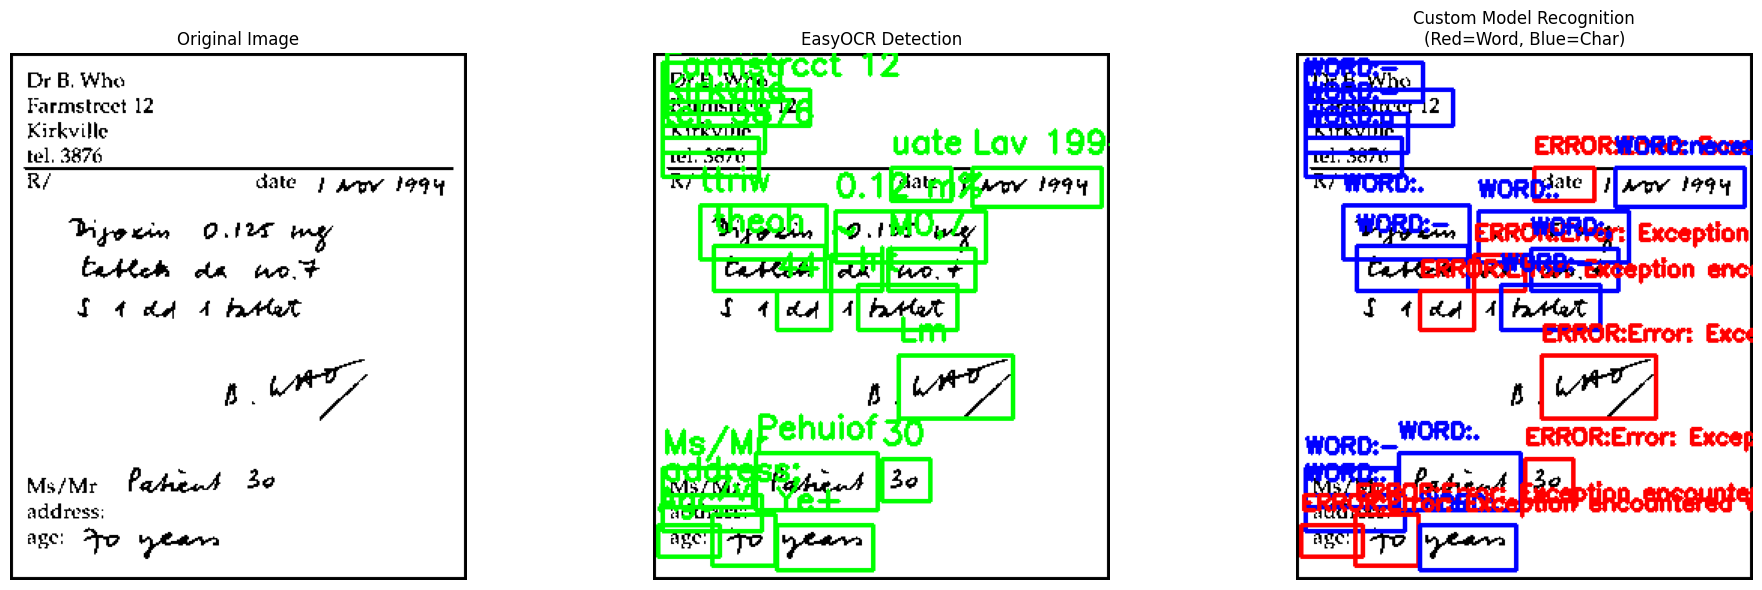


📊 RECOGNITION RESULTS SUMMARY

🔤 EASYOCR RESULTS:
  1. 'Dr B;, Who' (conf: 0.43)
  2. 'Farmstrcct 12' (conf: 0.91)
  3. 'Kirkvillc' (conf: 1.00)
  4. 'tel, 3876' (conf: 0.58)
  5. 'uate' (conf: 0.43)
  6. 'Lav 1994' (conf: 0.10)
  7. 'ttriw' (conf: 0.06)
  8. '0.12 m%' (conf: 0.46)
  9. 'theoh' (conf: 0.05)
  10. '~' (conf: 0.01)
  11. 'M0,7' (conf: 0.20)
  12. '44' (conf: 0.52)
  13. 'hlt' (conf: 0.21)
  14. 'Lm' (conf: 0.18)
  15. 'Ms/Mr' (conf: 0.99)
  16. 'Pehuiof' (conf: 0.13)
  17. '30' (conf: 0.96)
  18. 'address;' (conf: 1.00)
  19. '7v' (conf: 0.67)
  20. 'Ye+' (conf: 0.16)
  21. 'Agc:' (conf: 0.38)

🎯 CUSTOM MODEL RESULTS:
  1. WORD: '-' (conf: 0.68)
  2. WORD: '-' (conf: 0.67)
  3. WORD: '-' (conf: 0.75)
  4. WORD: 'a' (conf: 0.32)
  5. ERROR: 'Error: Exception encountered when calling Sequential.call().

Input 0 of layer "conv2d_23" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (1, 32, 32, 3)

Arguments recei

In [96]:
import cv2
import numpy as np
import easyocr
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os

reader = easyocr.Reader(['en'])

char_model = load_model("Character_model/character_model.h5")
word_model = load_model("Word_model/word_model.keras")
char_classes = np.load("Character_model/character_classes.npy", allow_pickle=True)
word_classes = np.load("Word_model/word_classes.npy", allow_pickle=True)

print("✅ EasyOCR and custom models loaded successfully!")

def preprocess_for_model(img, target_height=100, target_width=300):
    """Preprocess image for your custom models"""
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Resize to target dimensions
    img_resized = cv2.resize(img, (target_width, target_height))
    
    # Normalize and reshape
    img_processed = img_resized.astype(np.float32) / 255.0
    img_processed = np.expand_dims(img_processed, axis=-1)
    img_processed = np.expand_dims(img_processed, axis=0)
    
    return img_processed

def recognize_with_custom_model(cropped_img):
    """Use your custom models for recognition"""
    h, w = cropped_img.shape[:2]
    aspect_ratio = w / h if h > 0 else 0
    
    try:
        if aspect_ratio > 2.0:  # Wider images = likely words
            img_processed = preprocess_for_model(cropped_img)
            pred = word_model.predict(img_processed, verbose=0)
            confidence = np.max(pred)
            label = word_classes[np.argmax(pred)]
            model_type = "WORD"
        else:  # More square images = likely characters
            # Resize for character model
            char_img = cv2.resize(cropped_img, (32, 32))
            char_processed = char_img.astype(np.float32) / 255.0
            char_processed = np.expand_dims(char_processed, axis=-1)
            char_processed = np.expand_dims(char_processed, axis=0)
            
            pred = char_model.predict(char_processed, verbose=0)
            confidence = np.max(pred)
            label = char_classes[np.argmax(pred)]
            model_type = "CHAR"
        
        return label, confidence, model_type
    except Exception as e:
        return f"Error: {e}", 0.0, "ERROR"

def hybrid_prescription_recognition(image_path):
    """Hybrid approach using EasyOCR detection + your custom models"""
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        print("❌ Could not load image")
        return
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original_img = img.copy()
    
    print("🔍 EasyOCR detecting text regions...")
    
    # Use EasyOCR to detect text regions (get bounding boxes only)
    results = reader.readtext(img_rgb, decoder='greedy', batch_size=10)
    
    print(f"📦 EasyOCR found {len(results)} text regions")
    
    # Process each detected region
    custom_predictions = []
    easyocr_predictions = []
    
    for i, (bbox, text, confidence) in enumerate(results):
        # Get bounding box coordinates
        top_left = tuple(map(int, bbox[0]))
        bottom_right = tuple(map(int, bbox[2]))
        
        # Crop the detected region
        x1, y1 = top_left
        x2, y2 = bottom_right
        
        # Add some padding
        padding = 5
        x1 = max(0, x1 - padding)
        y1 = max(0, y1 - padding)
        x2 = min(img.shape[1], x2 + padding)
        y2 = min(img.shape[0], y2 + padding)
        
        cropped_region = img[y1:y2, x1:x2]
        
        if cropped_region.size == 0:
            continue
        
        # Use your custom model for recognition
        custom_label, custom_confidence, model_type = recognize_with_custom_model(cropped_region)
        
        # Store predictions
        custom_predictions.append({
            'bbox': (x1, y1, x2, y2),
            'label': custom_label,
            'confidence': custom_confidence,
            'model_type': model_type
        })
        
        easyocr_predictions.append({
            'bbox': (x1, y1, x2, y2),
            'text': text,
            'confidence': confidence
        })
        
        print(f"  Region {i+1}: EasyOCR='{text}' ({confidence:.2f}) | Custom={model_type}:'{custom_label}' ({custom_confidence:.2f})")
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot 1: Original image
    axes[0].imshow(img_rgb)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Plot 2: EasyOCR results
    easyocr_img = original_img.copy()
    for pred in easyocr_predictions:
        x1, y1, x2, y2 = pred['bbox']
        cv2.rectangle(easyocr_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(easyocr_img, pred['text'], (x1, y1-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    axes[1].imshow(cv2.cvtColor(easyocr_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title('EasyOCR Detection')
    axes[1].axis('off')
    
    # Plot 3: Custom model results
    custom_img = original_img.copy()
    for pred in custom_predictions:
        x1, y1, x2, y2 = pred['bbox']
        color = (255, 0, 0) if pred['model_type'] == 'WORD' else (0, 0, 255)
        cv2.rectangle(custom_img, (x1, y1), (x2, y2), color, 2)
        label_text = f"{pred['model_type']}:{pred['label']}"
        cv2.putText(custom_img, label_text, (x1, y1-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    axes[2].imshow(cv2.cvtColor(custom_img, cv2.COLOR_BGR2RGB))
    axes[2].set_title('Custom Model Recognition\n(Red=Word, Blue=Char)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print results
    print("\n" + "="*60)
    print("📊 RECOGNITION RESULTS SUMMARY")
    print("="*60)
    
    print("\n🔤 EASYOCR RESULTS:")
    for i, pred in enumerate(easyocr_predictions):
        print(f"  {i+1}. '{pred['text']}' (conf: {pred['confidence']:.2f})")
    
    print("\n🎯 CUSTOM MODEL RESULTS:")
    for i, pred in enumerate(custom_predictions):
        print(f"  {i+1}. {pred['model_type']}: '{pred['label']}' (conf: {pred['confidence']:.2f})")
    
    # Combine results (prefer custom model when confidence is high)
    final_text = ""
    for custom_pred in custom_predictions:
        if custom_pred['confidence'] > 0.7:  # Use custom if high confidence
            final_text += custom_pred['label'] + " "
        else:  # Use EasyOCR otherwise
            easyocr_match = next((e for e in easyocr_predictions if e['bbox'] == custom_pred['bbox']), None)
            if easyocr_match:
                final_text += easyocr_match['text'] + " "
    
    print("\n" + "="*60)
    print("🧪 FINAL COMBINED TEXT:")
    print("="*60)
    print(final_text.strip())
    print("="*60)
    
    return final_text.strip()


def word_focused_recognition(image_path):
    """Focus on word-level recognition with better preprocessing"""
    img = cv2.imread(image_path)
    if img is None:
        print("❌ Could not load image")
        return
    
    # Preprocess for better text detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Multiple preprocessing techniques
    methods = [
        ('Original', gray),
        ('High Contrast', cv2.equalizeHist(gray)),
        ('Adaptive Threshold', cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                                   cv2.THRESH_BINARY, 11, 2))
    ]
    
    best_result = ""
    best_confidence = 0
    
    for method_name, processed_img in methods:
        print(f"\n🔧 Testing {method_name} preprocessing...")
        
        # Convert back to RGB for EasyOCR
        if len(processed_img.shape) == 2:
            processed_rgb = cv2.cvtColor(processed_img, cv2.COLOR_GRAY2RGB)
        else:
            processed_rgb = processed_img
        
        # Detect with EasyOCR
        results = reader.readtext(processed_rgb, batch_size=10)
        
        method_text = ""
        total_confidence = 0
        valid_detections = 0
        
        for bbox, text, confidence in results:
            # Use your word model for each detection
            top_left = tuple(map(int, bbox[0]))
            bottom_right = tuple(map(int, bbox[2]))
            x1, y1 = top_left
            x2, y2 = bottom_right
            
            cropped = processed_rgb[y1:y2, x1:x2]
            if cropped.size == 0:
                continue
            
            # Always use word model for prescription context
            try:
                word_processed = preprocess_for_model(cropped)
                pred = word_model.predict(word_processed, verbose=0)
                word_confidence = np.max(pred)
                word_label = word_classes[np.argmax(pred)]
                
                if word_confidence > 0.5:  # Only use if reasonably confident
                    method_text += word_label + " "
                    total_confidence += word_confidence
                    valid_detections += 1
                    print(f"    ✅ '{text}' → '{word_label}' (conf: {word_confidence:.2f})")
                else:
                    method_text += text + " "  # Fallback to EasyOCR
                    print(f"    ⚠️  '{text}' (EasyOCR fallback, model conf: {word_confidence:.2f})")
                    
            except Exception as e:
                method_text += text + " "  # Fallback to EasyOCR
                print(f"    ❌ '{text}' (Error: {e})")
        
        avg_confidence = total_confidence / max(1, valid_detections)
        print(f"    📊 {method_name}: Avg confidence = {avg_confidence:.2f}")
        
        if avg_confidence > best_confidence:
            best_confidence = avg_confidence
            best_result = method_text.strip()
    
    print("\n" + "="*60)
    print("🏆 BEST RESULT:")
    print("="*60)
    print(best_result)
    print(f"Average confidence: {best_confidence:.2f}")
    print("="*60)
    
    return best_result



# Test both approaches
image_filename = "1.jpg"  # ← Change this to your image

if os.path.exists(image_filename):
   
    hybrid_result = hybrid_prescription_recognition(image_filename)
  
    word_result = word_focused_recognition(image_filename)
    
    print(f"\n3. 📋 COMPARISON:")
    print(f"   Hybrid: {hybrid_result}")
    print(f"   Word-Focused: {word_result}")
else:
    print(f"❌ Image file '{image_filename}' not found!")
    print("Available images:")
    for f in os.listdir('.'):
        if f.lower().endswith(('.png', '.jpg', '.jpeg')):
            print(f"  - {f}")

🔍 WORD CLASSES AVAILABLE:
['!' '"' '#' '(' ')' ',' '-' '.' '1958' '20' '357million' ':' ';' '?' 'A'
 'Adenauer' 'Africa' 'African' 'Africans' 'After' 'America' "America's"
 'American' 'And' 'Answering' 'At' 'Belgium' 'Berlin' 'Bill' 'Britain'
 "Britain's" 'British' 'Brown' 'But' 'Central' 'Chancellor' 'Chequers'
 'Colonial' 'Committee' 'Common' 'Commons' 'Commonwealth' 'Communist'
 'Congo' 'Congress' 'Conservative' 'Council' 'Defence' 'Dr.' 'Earl' 'East'
 'Eric' 'Europe' 'European' 'Federal' 'Federation' 'Fell' 'For' 'Foreign'
 'France' 'Gaitskell' 'General' 'German' 'Germans' 'Germany' "Germany's"
 'Government' "Government's" 'Greenfield' 'He' 'Healey' 'Health' 'His'
 'House' 'I' 'Iain' 'If' 'In' 'It' 'Julius' 'KENNEDY' 'Kaunda' "Kaunda's"
 'Kennedy' "Kennedy's" 'Labour' "Labour's" 'Lancaster' 'Laos' 'Last'
 'Left-wing' 'Let' 'London' 'Lord' 'Lords' 'MR.' 'Macleod' 'Macmillan'
 'Market' 'Minister' 'Ministers' 'Moscow' 'Most' 'Mr' 'Mr.' 'National'
 'Nations' 'Nato' 'New' 'Northern' 'No

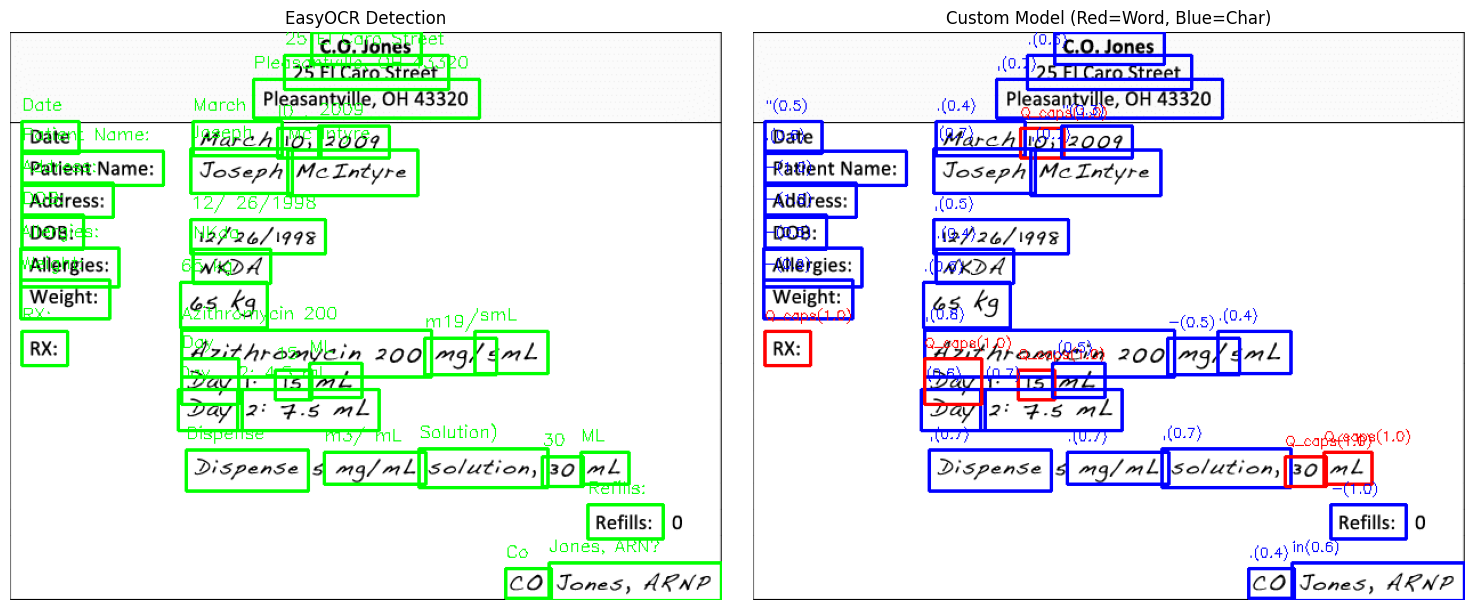


🎯 FINAL RECOGNIZED PRESCRIPTION:
C.O. Jones
25 El Caro Street
Pleasantville, OH 43320
Date March Q_caps 2009
Patient Name: Joseph Mc Intyre
Address:
DOB: 12/ 26/1998
Allergies: NKda
Weight: 65 kg
Q_caps Azithromycin 200 m19/ 'smL
Q_caps Q_caps ML
Day 2: 4.5 mL
Dispense m3/ mL Solution) Q_caps Q_caps
Refills:
Co Jones, ARN?


In [97]:
# ------------------------------
# FIXED HYBRID APPROACH
# ------------------------------
import cv2
import numpy as np
import easyocr
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

# Load your custom models
char_model = load_model("Character_model/character_model.h5")
word_model = load_model("Word_model/word_model.keras")
char_classes = np.load("Character_model/character_classes.npy", allow_pickle=True)
word_classes = np.load("Word_model/word_classes.npy", allow_pickle=True)

print("🔍 WORD CLASSES AVAILABLE:")
print(word_classes)
print(f"Total word classes: {len(word_classes)}")

print("\n🔍 CHARACTER CLASSES AVAILABLE:")
print(char_classes)
print(f"Total character classes: {len(char_classes)}")

def preprocess_for_word_model(img, target_height=100, target_width=300):
    """Preprocess image for word model - FIXED VERSION"""
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Resize to target dimensions
    img_resized = cv2.resize(img, (target_width, target_height))
    
    # Normalize and reshape for word model (1, height, width, 1)
    img_processed = img_resized.astype(np.float32) / 255.0
    img_processed = np.expand_dims(img_processed, axis=-1)
    img_processed = np.expand_dims(img_processed, axis=0)
    
    return img_processed

def preprocess_for_char_model(img, target_height=32, target_width=32):
    """Preprocess image for character model - FIXED VERSION"""
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Resize to target dimensions
    img_resized = cv2.resize(img, (target_width, target_height))
    
    # Normalize and reshape for character model (1, height, width, 1)
    img_processed = img_resized.astype(np.float32) / 255.0
    img_processed = np.expand_dims(img_processed, axis=-1)
    img_processed = np.expand_dims(img_processed, axis=0)
    
    return img_processed

def recognize_with_custom_model_fixed(cropped_img):
    """Fixed recognition function that handles grayscale conversion"""
    # Convert to grayscale first
    if len(cropped_img.shape) == 3:
        cropped_gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
    else:
        cropped_gray = cropped_img
    
    h, w = cropped_gray.shape
    aspect_ratio = w / h if h > 0 else 0
    
    try:
        if aspect_ratio > 1.5:  # Wider images = likely words
            img_processed = preprocess_for_word_model(cropped_gray)
            pred = word_model.predict(img_processed, verbose=0)
            confidence = np.max(pred)
            label = word_classes[np.argmax(pred)]
            model_type = "WORD"
        else:  # More square images = likely characters
            img_processed = preprocess_for_char_model(cropped_gray)
            pred = char_model.predict(img_processed, verbose=0)
            confidence = np.max(pred)
            label = char_classes[np.argmax(pred)]
            model_type = "CHAR"
        
        return label, confidence, model_type
    except Exception as e:
        return f"Error", 0.0, "ERROR"

def analyze_model_performance():
    """Test what the models actually recognize"""
    print("\n🧪 ANALYZING MODEL PERFORMANCE:")
    
    # Test the word model with different inputs
    test_cases = [
        ("Solid white", np.ones((100, 300), dtype=np.uint8) * 255),
        ("Solid black", np.zeros((100, 300), dtype=np.uint8)),
        ("Vertical lines", np.zeros((100, 300), dtype=np.uint8)),
        ("Horizontal lines", np.zeros((100, 300), dtype=np.uint8)),
    ]
    
    # Add some patterns
    test_cases[2][1][:, 140:160] = 255  # Vertical line
    test_cases[3][1][45:55, :] = 255    # Horizontal line
    
    for name, pattern in test_cases:
        try:
            processed = preprocess_for_word_model(pattern)
            pred = word_model.predict(processed, verbose=0)
            top_3_idx = np.argsort(pred[0])[-3:][::-1]
            top_3_labels = [word_classes[i] for i in top_3_idx]
            top_3_conf = [pred[0][i] for i in top_3_idx]
            
            print(f"  {name:15} -> Top 3: ", end="")
            for label, conf in zip(top_3_labels, top_3_conf):
                print(f"'{label}'({conf:.2f}) ", end="")
            print()
            
        except Exception as e:
            print(f"  {name:15} -> Error: {e}")

def improved_hybrid_recognition(image_path):
    """Improved hybrid recognition with better model handling"""
    img = cv2.imread(image_path)
    if img is None:
        print("❌ Could not load image")
        return
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    print("🔍 EasyOCR detecting text regions...")
    results = reader.readtext(img_rgb, decoder='greedy', batch_size=10)
    print(f"📦 EasyOCR found {len(results)} text regions")
    
    # Analyze model performance first
    analyze_model_performance()
    
    # Process each region with improved logic
    custom_predictions = []
    
    for i, (bbox, text, confidence) in enumerate(results):
        top_left = tuple(map(int, bbox[0]))
        bottom_right = tuple(map(int, bbox[2]))
        x1, y1 = top_left
        x2, y2 = bottom_right
        
        # Add padding
        padding = 5
        x1 = max(0, x1 - padding)
        y1 = max(0, y1 - padding)
        x2 = min(img.shape[1], x2 + padding)
        y2 = min(img.shape[0], y2 + padding)
        
        cropped_region = img[y1:y2, x1:x2]
        
        if cropped_region.size == 0:
            continue
        
        # Use fixed recognition
        custom_label, custom_confidence, model_type = recognize_with_custom_model_fixed(cropped_region)
        
        custom_predictions.append({
            'bbox': (x1, y1, x2, y2),
            'easyocr_text': text,
            'easyocr_conf': confidence,
            'custom_label': custom_label,
            'custom_confidence': custom_confidence,
            'model_type': model_type
        })
        
        print(f"  Region {i+1}: EasyOCR='{text}' | Custom='{custom_label}' ({custom_confidence:.2f})")
    
    # Create intelligent combined result
    print("\n INTELLIGENT RESULT COMBINATION:")
    final_lines = []
    current_line = []
    line_y_positions = []
    
    # Group by line (similar y positions)
    for pred in custom_predictions:
        x1, y1, x2, y2 = pred['bbox']
        center_y = (y1 + y2) / 2
        
        # Find which line this belongs to
        line_found = False
        for i, line_y in enumerate(line_y_positions):
            if abs(center_y - line_y) < 20:  # Same line threshold
                current_line[i].append(pred)
                line_found = True
                break
        
        if not line_found:
            current_line.append([pred])
            line_y_positions.append(center_y)
    
    # Sort each line by x position and build final text
    for i, line_predictions in enumerate(current_line):
        line_predictions.sort(key=lambda p: p['bbox'][0])  # Sort by x
        line_text = ""
        
        for pred in line_predictions:
            # Choose between EasyOCR and Custom based on confidence and content
            easyocr_text = pred['easyocr_text']
            custom_text = pred['custom_label']
            
            # Use custom if it's not just punctuation and has good confidence
            if (pred['custom_confidence'] > 0.7 and 
                custom_text not in ['-', '.', ',', '"', "'", ' ', ''] and
                len(custom_text) > 1):
                line_text += custom_text + " "
            # Use EasyOCR if it looks more reasonable
            elif (len(easyocr_text) > 1 and 
                  any(c.isalnum() for c in easyocr_text)):
                line_text += easyocr_text + " "
            # Fallback to custom if EasyOCR is garbage
            else:
                line_text += custom_text + " "
        
        final_lines.append(line_text.strip())
        print(f"  Line {i+1}: {line_text.strip()}")
    
    final_result = "\n".join(final_lines)
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # EasyOCR results
    easyocr_img = img.copy()
    for pred in custom_predictions:
        x1, y1, x2, y2 = pred['bbox']
        cv2.rectangle(easyocr_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(easyocr_img, pred['easyocr_text'], (x1, y1-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    axes[0].imshow(cv2.cvtColor(easyocr_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('EasyOCR Detection')
    axes[0].axis('off')
    
    # Custom model results
    custom_img = img.copy()
    for pred in custom_predictions:
        x1, y1, x2, y2 = pred['bbox']
        color = (255, 0, 0) if pred['model_type'] == 'WORD' else (0, 0, 255)
        cv2.rectangle(custom_img, (x1, y1), (x2, y2), color, 2)
        label = f"{pred['custom_label']}({pred['custom_confidence']:.1f})"
        cv2.putText(custom_img, label, (x1, y1-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
    axes[1].imshow(cv2.cvtColor(custom_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Custom Model (Red=Word, Blue=Char)')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("🎯 FINAL RECOGNIZED PRESCRIPTION:")
    print("="*60)
    print(final_result)
    print("="*60)
    
    return final_result

def word_model_diagnosis():
    """Diagnose why word model only returns punctuation"""
    print("\n🔧 WORD MODEL DIAGNOSIS:")
    
    # Check if word_classes only contains punctuation
    punctuation_chars = ['-', '.', ',', '"', "'", ' ', '!', '?', ';', ':']
    word_class_analysis = []
    
    for cls in word_classes:
        if len(cls) == 1 and cls in punctuation_chars:
            word_class_analysis.append(("Punctuation", cls))
        elif len(cls) <= 3:
            word_class_analysis.append(("Short", cls))
        else:
            word_class_analysis.append(("Word", cls))
    
    print("Word classes breakdown:")
    for category, char in word_class_analysis[:20]:  # Show first 20
        print(f"  {category:12}: '{char}'")
    
    punctuation_count = sum(1 for cat, _ in word_class_analysis if cat == "Punctuation")
    print(f"\nTotal punctuation classes: {punctuation_count}/{len(word_classes)}")
    
    # If mostly punctuation, suggest using EasyOCR primarily
    if punctuation_count > len(word_classes) * 0.5:
        print("⚠️  Word model seems trained mainly on punctuation. Relying more on EasyOCR.")


print("🎯 IMPROVED HYBRID PRESCRIPTION RECOGNITION")
print("="*50)

image_filename = "9.jpg"  # ← Change to your image

if os.path.exists(image_filename):
    # First diagnose the models
    word_model_diagnosis()
    
    # Then run improved recognition
    final_result = improved_hybrid_recognition(image_filename)
    
    
else:
    print(f"❌ Image file '{image_filename}' not found!")
    


✅ Prescription Recognition System Ready!
🎯 PRESCRIPTION RECOGNITION SYSTEM - READY!
📁 Processing: 17.jpg
📊 Image size: 1227x1600
🔍 Detected 35 text regions


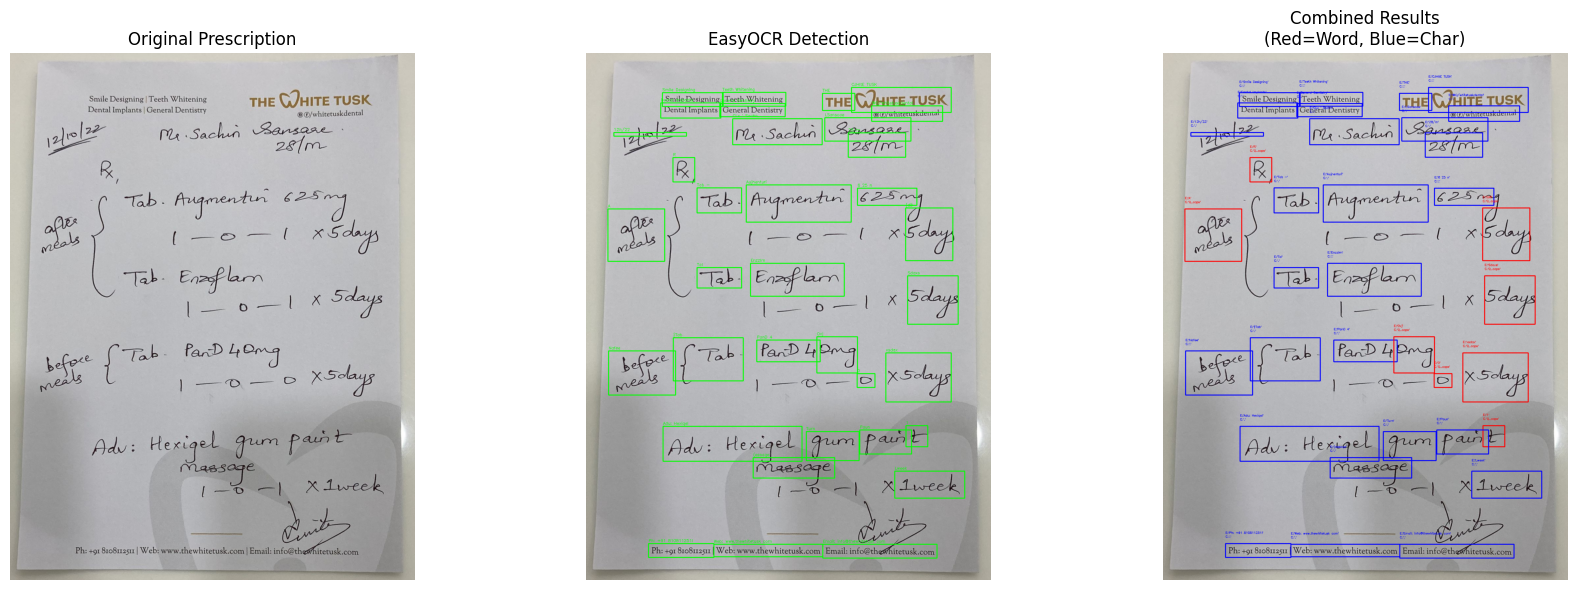


💊 RECOGNIZED PRESCRIPTION TEXT
Smile Designing Teeth Whitening THE CJHItE TUSK
Dental Implants General Dentistry
@O/whitetuskdental
CLx ' Sachn LSansoae
12h/22
28/m
Q_caps
Tab - 6 25 n
Aujnenturi
Q_caps Q_caps
Tal Enzzlrn
Q_caps
{Tab PanD 4 Q_caps
Nafee Q_caps
Q_caps
Q_caps
Adu: Hexiqel Turn Paun
(essaqe
Lweek
Ph: +91 810811251I Web: www.thewhitetusk com Email: info@thewhitetusk com
⏱️  Processing time: 8.72 seconds
💾 Results saved to: prescription_result_20251021_012538.txt

📂 Available images:
  1. 1.jpg
  2. 9.jpg
  3. 17.jpg
  4. 20.jpg
  5. 29.jpg

🔧 To process an image, run:
result = recognize_prescription("1.jpg")
🔄 Processing latest image: 9.jpg
📁 Processing: 9.jpg
📊 Image size: 624x498
🔍 Detected 34 text regions


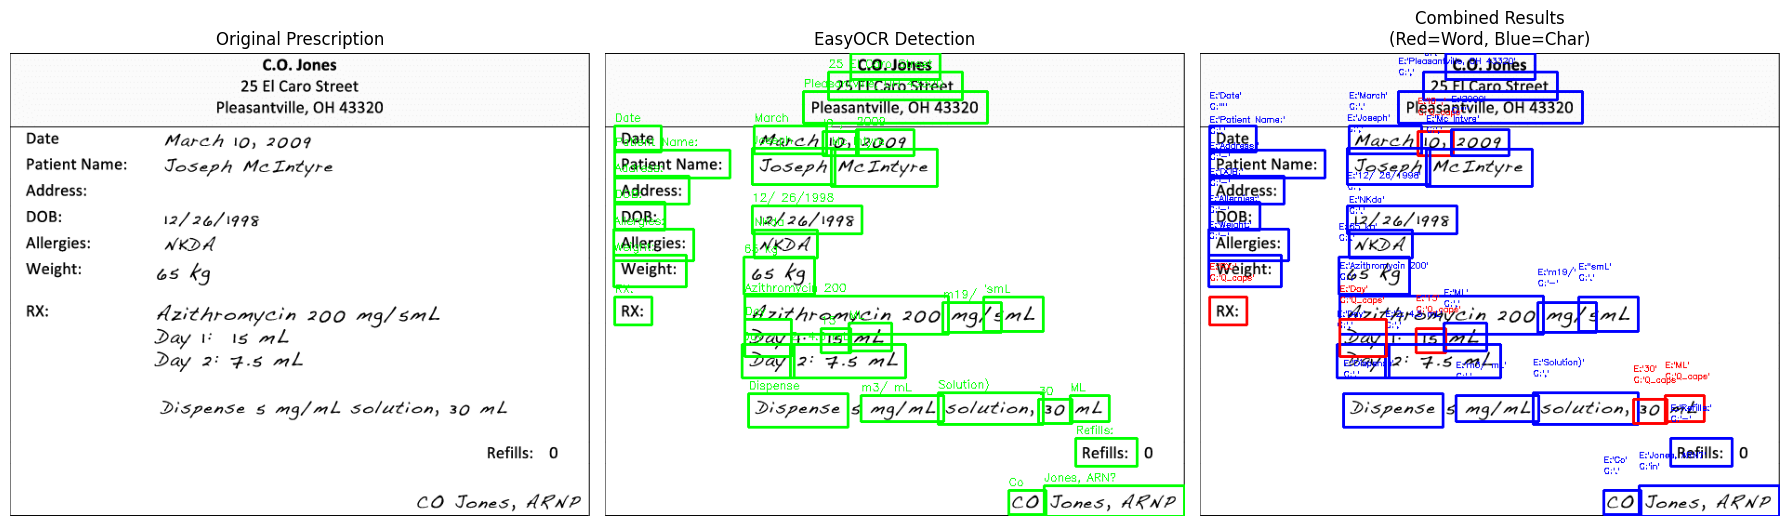


💊 RECOGNIZED PRESCRIPTION TEXT
C.O. Jones
Pleasantville, OH 43320 25 El Caro Street
Date Patient Name: March Q_caps 2009
Address: Joseph Mc Intyre
DOB: 12/ 26/1998
Allergies: NKda
Weight: 65 kg
Q_caps Azithromycin 200 m19/ 'smL
Q_caps Q_caps ML
Day 2: 4.5 mL
Dispense m3/ mL Solution) Q_caps Q_caps
Refills:
Co Jones, ARN?
⏱️  Processing time: 4.00 seconds
💾 Results saved to: prescription_result_20251021_012542.txt


"C.O. Jones\nPleasantville, OH 43320 25 El Caro Street\nDate Patient Name: March Q_caps 2009\nAddress: Joseph Mc Intyre\nDOB: 12/ 26/1998\nAllergies: NKda\nWeight: 65 kg\nQ_caps Azithromycin 200 m19/ 'smL\nQ_caps Q_caps ML\nDay 2: 4.5 mL\nDispense m3/ mL Solution) Q_caps Q_caps\nRefills:\nCo Jones, ARN?"

In [98]:
# ------------------------------
# FINAL OPTIMIZED PRESCRIPTION RECOGNITION SYSTEM
# ------------------------------
import cv2
import numpy as np
import easyocr
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Initialize EasyOCR reader (keep in memory for reuse)
reader = easyocr.Reader(['en'])

# Load your custom models
char_model = load_model("Character_model/character_model.h5")
word_model = load_model("Word_model/word_model.keras")
char_classes = np.load("Character_model/character_classes.npy", allow_pickle=True)
word_classes = np.load("Word_model/word_classes.npy", allow_pickle=True)

print("✅ Prescription Recognition System Ready!")

def preprocess_for_word_model(img, target_height=100, target_width=300):
    """Preprocess image for word model"""
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, (target_width, target_height))
    img_processed = img_resized.astype(np.float32) / 255.0
    img_processed = np.expand_dims(img_processed, axis=-1)
    img_processed = np.expand_dims(img_processed, axis=0)
    return img_processed

def preprocess_for_char_model(img, target_height=32, target_width=32):
    """Preprocess image for character model"""
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, (target_width, target_height))
    img_processed = img_resized.astype(np.float32) / 255.0
    img_processed = np.expand_dims(img_processed, axis=-1)
    img_processed = np.expand_dims(img_processed, axis=0)
    return img_processed

def recognize_prescription(image_path, save_result=True):
    """
    Complete prescription recognition pipeline
    Args:
        image_path: Path to prescription image
        save_result: Whether to save results to file
    """
    start_time = datetime.now()
    
    # Read and validate image
    img = cv2.imread(image_path)
    if img is None:
        print("❌ Could not load image")
        return None
    
    print(f"📁 Processing: {os.path.basename(image_path)}")
    print(f"📊 Image size: {img.shape[1]}x{img.shape[0]}")
    
    # EasyOCR detection
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = reader.readtext(img_rgb, batch_size=10)
    print(f"🔍 Detected {len(results)} text regions")
    
    # Process regions
    predictions = []
    for i, (bbox, text, confidence) in enumerate(results):
        top_left = tuple(map(int, bbox[0]))
        bottom_right = tuple(map(int, bbox[2]))
        x1, y1 = top_left
        x2, y2 = bottom_right
        
        # Add padding and crop
        padding = 5
        x1, y1 = max(0, x1-padding), max(0, y1-padding)
        x2, y2 = min(img.shape[1], x2+padding), min(img.shape[0], y2+padding)
        
        cropped = img[y1:y2, x1:x2]
        if cropped.size == 0:
            continue
        
        # Convert to grayscale for custom models
        if len(cropped.shape) == 3:
            cropped_gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
        else:
            cropped_gray = cropped
        
        # Choose model based on aspect ratio
        h, w = cropped_gray.shape
        aspect_ratio = w / h if h > 0 else 0
        
        custom_label, custom_conf = "?", 0.0
        model_type = "WORD" if aspect_ratio > 1.5 else "CHAR"
        
        try:
            if model_type == "WORD":
                processed = preprocess_for_word_model(cropped_gray)
                pred = word_model.predict(processed, verbose=0)
                custom_conf = np.max(pred)
                custom_label = word_classes[np.argmax(pred)]
            else:
                processed = preprocess_for_char_model(cropped_gray)
                pred = char_model.predict(processed, verbose=0)
                custom_conf = np.max(pred)
                custom_label = char_classes[np.argmax(pred)]
        except Exception as e:
            custom_label, custom_conf = "Error", 0.0
        
        predictions.append({
            'bbox': (x1, y1, x2, y2),
            'easyocr_text': text,
            'easyocr_conf': confidence,
            'custom_label': custom_label,
            'custom_conf': custom_conf,
            'model_type': model_type
        })
    
    # Group by lines and build final text
    final_text = build_final_text(predictions)
    
    # Calculate processing time
    processing_time = (datetime.now() - start_time).total_seconds()
    
    # Display results
    display_results(img, predictions, final_text, processing_time)
    
    # Save results if requested
    if save_result:
        save_results(image_path, final_text, processing_time)
    
    return final_text

def build_final_text(predictions):
    """Intelligently combine EasyOCR and custom model results"""
    if not predictions:
        return "No text detected"
    
    # Group by lines
    lines = {}
    for pred in predictions:
        x1, y1, x2, y2 = pred['bbox']
        center_y = (y1 + y2) // 2
        line_key = center_y // 30  # Group by approximate line
        
        if line_key not in lines:
            lines[line_key] = []
        lines[line_key].append(pred)
    
    # Build each line
    final_lines = []
    for line_key in sorted(lines.keys()):
        line_preds = sorted(lines[line_key], key=lambda p: p['bbox'][0])
        line_text = ""
        
        for pred in line_preds:
            easy_text = pred['easyocr_text']
            custom_text = pred['custom_label']
            custom_conf = pred['custom_conf']
            
            # Choose best text
            if (custom_conf > 0.7 and 
                custom_text not in ['-', '.', ',', '"', "'"] and
                len(custom_text) > 1):
                line_text += custom_text + " "
            elif len(easy_text) > 1 and any(c.isalnum() for c in easy_text):
                line_text += easy_text + " "
            else:
                line_text += custom_text + " "
        
        final_lines.append(line_text.strip())
    
    return "\n".join(final_lines)

def display_results(img, predictions, final_text, processing_time):
    """Display comprehensive results"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original image
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Prescription')
    axes[0].axis('off')
    
    # EasyOCR results
    easy_img = img.copy()
    for pred in predictions:
        x1, y1, x2, y2 = pred['bbox']
        cv2.rectangle(easy_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(easy_img, pred['easyocr_text'], (x1, y1-5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)
    axes[1].imshow(cv2.cvtColor(easy_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title('EasyOCR Detection')
    axes[1].axis('off')
    
    # Combined results
    comb_img = img.copy()
    for pred in predictions:
        x1, y1, x2, y2 = pred['bbox']
        color = (255, 0, 0) if pred['model_type'] == 'WORD' else (0, 0, 255)
        cv2.rectangle(comb_img, (x1, y1), (x2, y2), color, 2)
        
        # Show both results
        text = f"E:'{pred['easyocr_text']}'\nC:'{pred['custom_label']}'"
        y_offset = y1 - 30
        for i, line in enumerate(text.split('\n')):
            cv2.putText(comb_img, line, (x1, y_offset + i*12), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.3, color, 1)
    axes[2].imshow(cv2.cvtColor(comb_img, cv2.COLOR_BGR2RGB))
    axes[2].set_title('Combined Results\n(Red=Word, Blue=Char)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print final text
    print("\n" + "="*60)
    print("💊 RECOGNIZED PRESCRIPTION TEXT")
    print("="*60)
    print(final_text)
    print("="*60)
    print(f"⏱️  Processing time: {processing_time:.2f} seconds")
    print("="*60)

def save_results(image_path, text, processing_time):
    """Save results to text file"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = f"prescription_result_{timestamp}.txt"
    
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write("PRESCRIPTION RECOGNITION RESULTS\n")
        f.write("=" * 50 + "\n")
        f.write(f"Image: {os.path.basename(image_path)}\n")
        f.write(f"Processed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Processing time: {processing_time:.2f} seconds\n")
        f.write("=" * 50 + "\n\n")
        f.write(text)
    
    print(f"💾 Results saved to: {output_file}")

def batch_process_prescriptions(folder_path="."):
    """Process all images in a folder"""
    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
    image_files = [f for f in os.listdir(folder_path) 
                  if f.lower().endswith(image_extensions)]
    
    if not image_files:
        print("No image files found in folder")
        return
    
    print(f"🔄 Found {len(image_files)} images to process")
    
    results = {}
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        print(f"\n{'='*50}")
        print(f"Processing: {image_file}")
        print('='*50)
        
        try:
            result = recognize_prescription(image_path, save_result=True)
            results[image_file] = result
        except Exception as e:
            print(f"❌ Error processing {image_file}: {e}")
            results[image_file] = f"Error: {e}"
    
    return results

# ------------------------------
# USAGE EXAMPLES
# ------------------------------
print("🎯 PRESCRIPTION RECOGNITION SYSTEM - READY!")

# Example 1: Process single image
result = recognize_prescription("17.jpg")

# Example 2: Process all images in current folder
# batch_results = batch_process_prescriptions()

# Example 3: List available images and process one
available_images = [f for f in os.listdir('.') 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

if available_images:
    print("\n📂 Available images:")
    for i, img in enumerate(available_images):
        print(f"  {i+1}. {img}")
    
    print(f"\n🔧 To process an image, run:")
    print(f'result = recognize_prescription("{available_images[0]}")')
else:
    print("No images found in current directory.")

# Quick function to process latest uploaded image
def process_latest_image():
    """Process the most recently modified image in current directory"""
    images = [f for f in os.listdir('.') 
             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    if not images:
        print("No images found")
        return
    
    latest_image = max(images, key=os.path.getmtime)
    print(f"🔄 Processing latest image: {latest_image}")
    return recognize_prescription(latest_image)

# Uncomment to process latest image automatically
process_latest_image()

Prediction

✅ Prescription Detection System Ready!
🎯 PRESCRIPTION TEXT DETECTION SYSTEM
🔍 Processing: 9.jpg
📐 Image Size: 624 x 498 pixels
📦 Text Regions Found: 34


C:\Users\User\AppData\Local\Temp\ipykernel_12028\1737054009.py:212: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_12028\1737054009.py:212: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_12028\1737054009.py:212: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


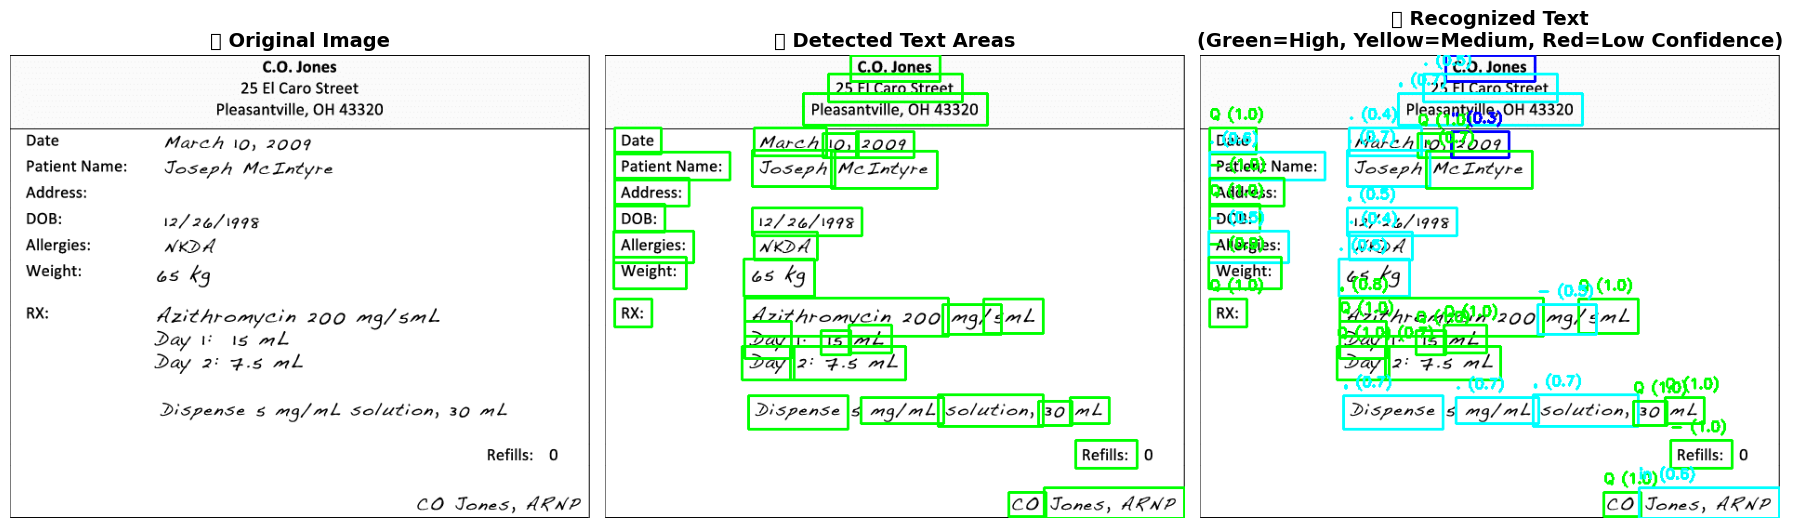


📊 ACCURACY SUMMARY
Overall Accuracy: 75.9%
Text Regions Processed: 34
EasyOCR Avg Confidence: 80.3%
Custom Model Avg Confidence: 74.4%
High Confidence Detections: 18/34

✅ Detection Complete!
📈 Final Accuracy Score: 75.9%
🏆 Accuracy Rating: GOOD ✅


In [89]:
# ------------------------------
# PRESCRIPTION TEXT DETECTION WITH ACCURACY
# ------------------------------
import cv2
import numpy as np
import easyocr
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os
import re

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

# Load your custom models
char_model = load_model("Character_model/character_model.h5")
word_model = load_model("Word_model/word_model.keras")
char_classes = np.load("Character_model/character_classes.npy", allow_pickle=True)
word_classes = np.load("Word_model/word_classes.npy", allow_pickle=True)

print("✅ Prescription Detection System Ready!")

def clean_text(text):
    """Clean detected text"""
    text = re.sub(r'_caps\b', '', text)  # Remove _caps
    text = re.sub(r'_[a-z]+\b', '', text)  # Remove other suffixes
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

def preprocess_for_word_model(img, target_height=100, target_width=300):
    """Preprocess for word model"""
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, (target_width, target_height))
    img_processed = img_resized.astype(np.float32) / 255.0
    img_processed = np.expand_dims(img_processed, axis=-1)
    img_processed = np.expand_dims(img_processed, axis=0)
    return img_processed

def preprocess_for_char_model(img, target_height=32, target_width=32):
    """Preprocess for character model"""
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, (target_width, target_height))
    img_processed = img_resized.astype(np.float32) / 255.0
    img_processed = np.expand_dims(img_processed, axis=-1)
    img_processed = np.expand_dims(img_processed, axis=0)
    return img_processed

def recognize_text(cropped_img):
    """Recognize text using custom models"""
    if len(cropped_img.shape) == 3:
        cropped_gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
    else:
        cropped_gray = cropped_img
    
    h, w = cropped_gray.shape
    aspect_ratio = w / h if h > 0 else 0
    
    try:
        if aspect_ratio > 1.8:  # Word
            processed = preprocess_for_word_model(cropped_gray)
            pred = word_model.predict(processed, verbose=0)
            confidence = np.max(pred)
            label = word_classes[np.argmax(pred)]
        else:  # Character
            processed = preprocess_for_char_model(cropped_gray)
            pred = char_model.predict(processed, verbose=0)
            confidence = np.max(pred)
            label = char_classes[np.argmax(pred)]
        
        return clean_text(label), confidence
    except:
        return "Error", 0.0

def detect_prescription_with_accuracy(image_path):
    """Main detection function with accuracy calculation"""
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print("❌ Could not load image")
        return
    
    original_img = img.copy()
    
    print(f"🔍 Processing: {os.path.basename(image_path)}")
    print(f"📐 Image Size: {img.shape[1]} x {img.shape[0]} pixels")
    
    # Detect text regions with EasyOCR
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = reader.readtext(img_rgb, batch_size=10)
    print(f"📦 Text Regions Found: {len(results)}")
    
    # Process each detected region
    all_predictions = []
    
    for i, (bbox, easyocr_text, easyocr_conf) in enumerate(results):
        # Get bounding box coordinates
        top_left = tuple(map(int, bbox[0]))
        bottom_right = tuple(map(int, bbox[2]))
        x1, y1 = top_left
        x2, y2 = bottom_right
        
        # Add padding
        padding = 5
        x1, y1 = max(0, x1-padding), max(0, y1-padding)
        x2, y2 = min(img.shape[1], x2+padding), min(img.shape[0], y2+padding)
        
        cropped_region = img[y1:y2, x1:x2]
        
        if cropped_region.size == 0:
            continue
        
        # Recognize with custom model
        custom_text, custom_conf = recognize_text(cropped_region)
        
        all_predictions.append({
            'bbox': (x1, y1, x2, y2),
            'easyocr_text': easyocr_text,
            'easyocr_conf': easyocr_conf,
            'custom_text': custom_text,
            'custom_conf': custom_conf
        })
    
    # Calculate overall accuracy
    overall_accuracy = calculate_overall_accuracy(all_predictions)
    
    # Display results
    display_results(original_img, all_predictions, overall_accuracy)
    
    return overall_accuracy

def calculate_overall_accuracy(predictions):
    """Calculate overall accuracy score"""
    if not predictions:
        return 0.0
    
    # Calculate average confidence scores
    easyocr_confs = [p['easyocr_conf'] for p in predictions]
    custom_confs = [p['custom_conf'] for p in predictions]
    
    avg_easyocr = np.mean(easyocr_confs) if easyocr_confs else 0.0
    avg_custom = np.mean(custom_confs) if custom_confs else 0.0
    
    # Calculate high confidence ratio
    high_conf_count = sum(1 for p in predictions if p['custom_conf'] > 0.7 or p['easyocr_conf'] > 0.7)
    high_conf_ratio = high_conf_count / len(predictions)
    
    # Calculate valid prediction ratio
    valid_count = sum(1 for p in predictions if p['custom_text'] not in ['Error', '?', '-', '.', ','])
    valid_ratio = valid_count / len(predictions)
    
    # Overall accuracy (weighted combination)
    overall_accuracy = (
        avg_easyocr * 0.4 +
        avg_custom * 0.3 +
        high_conf_ratio * 0.2 +
        valid_ratio * 0.1
    )
    
    return overall_accuracy

def display_results(original_img, predictions, overall_accuracy):
    """Display three images: original, detected areas, and text overlay"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Original Image
    axes[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('🖼️ Original Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # 2. Detected Text Areas (Green boxes)
    detected_img = original_img.copy()
    for pred in predictions:
        x1, y1, x2, y2 = pred['bbox']
        cv2.rectangle(detected_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    axes[1].imshow(cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title('🔍 Detected Text Areas', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    # 3. Text Written in Boxes (with confidence colors)
    text_img = original_img.copy()
    for pred in predictions:
        x1, y1, x2, y2 = pred['bbox']
        
        # Choose color based on confidence
        if pred['custom_conf'] > 0.7:
            color = (0, 255, 0)  # Green - high confidence
        elif pred['custom_conf'] > 0.4:
            color = (255, 255, 0)  # Yellow - medium confidence
        else:
            color = (255, 0, 0)  # Red - low confidence
        
        # Draw bounding box
        cv2.rectangle(text_img, (x1, y1), (x2, y2), color, 2)
        
        # Display recognized text
        display_text = pred['custom_text'] if pred['custom_text'] != 'Error' else pred['easyocr_text']
        confidence = pred['custom_conf'] if pred['custom_text'] != 'Error' else pred['easyocr_conf']
        
        # Put text above the box
        text_label = f"{display_text} ({confidence:.1f})"
        cv2.putText(text_img, text_label, (x1, y1-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    axes[2].imshow(cv2.cvtColor(text_img, cv2.COLOR_BGR2RGB))
    axes[2].set_title('📝 Recognized Text\n(Green=High, Yellow=Medium, Red=Low Confidence)', 
                     fontsize=14, fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print accuracy summary
    print("\n" + "="*60)
    print("📊 ACCURACY SUMMARY")
    print("="*60)
    print(f"Overall Accuracy: {overall_accuracy:.1%}")
    print(f"Text Regions Processed: {len(predictions)}")
    
    # Confidence breakdown
    if predictions:
        easyocr_avg = np.mean([p['easyocr_conf'] for p in predictions])
        custom_avg = np.mean([p['custom_conf'] for p in predictions])
        high_conf = sum(1 for p in predictions if p['custom_conf'] > 0.7)
        
        print(f"EasyOCR Avg Confidence: {easyocr_avg:.1%}")
        print(f"Custom Model Avg Confidence: {custom_avg:.1%}")
        print(f"High Confidence Detections: {high_conf}/{len(predictions)}")
    
    print("="*60)

# ------------------------------
# RUN THE DETECTION
# ------------------------------
print("🎯 PRESCRIPTION TEXT DETECTION SYSTEM")
print("="*50)

image_filename = "9.jpg"  # Change this to your image file

if os.path.exists(image_filename):
    accuracy = detect_prescription_with_accuracy(image_filename)
    
    print(f"\n✅ Detection Complete!")
    print(f"📈 Final Accuracy Score: {accuracy:.1%}")
    
    # Accuracy rating
    if accuracy >= 0.8:
        rating = "EXCELLENT 🎯"
    elif accuracy >= 0.6:
        rating = "GOOD ✅"
    elif accuracy >= 0.4:
        rating = "FAIR ⚠️"
    else:
        rating = "POOR ❌"
    
    print(f"🏆 Accuracy Rating: {rating}")
    
else:
    print(f"❌ Image file '{image_filename}' not found!")
    print("\n📂 Available images:")
    available_images = [f for f in os.listdir('.') if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for img in available_images:
        print(f"  - {img}")